<center> 
  <img src="https://totdom.com/upload/webp/100/upload/iblock/18d/7ulqe8snm4u6sm0kw32g5fiot70gbfkz/0-rynok-nedvizhimosti-v-2024-godu.webp" align="right" width="300" height=250/> 
</center>

# 🏠 Модель прогнозирования стоимости жилья

## 1. Постановка задачи

**Бизнес-задача:**  
Создать модель, которая позволит агентству недвижимости быстрее и точнее оценивать стоимость объектов и тем самым повысить эффективность сделок.  

**Техническая задача:**  
Построить и протестировать модель машинного обучения для прогнозирования стоимости жилья на основе характеристик объектов и данных о локации.  

**Основные этапы проекта:**
1. Предобработка и очистка исходных данных.  
2. Разведывательный анализ (EDA) и формирование признаков.  
3. Выделение ключевых факторов, влияющих на цену.  
4. Обучение и сравнение моделей прогнозирования.  
5. Разработка прототипа веб-сервиса для предсказания стоимости.  

## 2. Данные и их описание

Исходный датасет содержит информацию об объектах жилой недвижимости и их стоимости.  

Основные признаки:

- **status** — статус продажи объекта  
- **private pool / PrivatePool** — наличие собственного бассейна  
- **propertyType** — тип объекта недвижимости  
- **street** — адрес объекта  
- **baths** — количество ванных комнат  
- **beds** — количество спален  
- **sqft** — площадь в квадратных футах  
- **stories** — количество этажей  
- **fireplace** — наличие камина  
- **city** — город  
- **state** — штат  
- **zipcode** — почтовый индекс  
- **homeFacts** — сведения о характеристиках объекта (год постройки, площадь участка и др.)  
- **schools** — информация о школах в районе  
- **mls-id / MlsId** — идентификатор объекта в MLS  
- **target** — цена объекта недвижимости (целевой признак) 

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [118]:
# Работа с данными
import numpy as np                      # операции с массивами и матрицами
import pandas as pd                     # работа с табличными данными

# Визуализация
import matplotlib.pyplot as plt         # базовые графики
import seaborn as sns                   # статистическая визуализация
import plotly.express as px             # интерактивные графики (при необходимости)

# Статистика и анализ
from scipy import stats                 # распределения и базовые тесты
from scipy.stats import normaltest, spearmanr, pearsonr, f_oneway  # нормальность, корреляции, ANOVA

# Предобработка и пайплайны
from sklearn.preprocessing import OneHotEncoder, StandardScaler    # кодирование и масштабирование
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor  # объединение трансформаций и трансформация целевой переменной
from sklearn.base import BaseEstimator, TransformerMixin            # создание собственных трансформеров
from sklearn.pipeline import Pipeline  # построение пайплайнов
from sklearn import preprocessing      # дополнительные инструменты предобработки
from sklearn.impute import SimpleImputer # Заполнение пропусков

# Машинное обучение (Scikit-Learn)
from sklearn import linear_model            # линейные модели
from sklearn import ensemble                # ансамблевые методы (RandomForest, GradientBoosting и др.)
from sklearn import metrics                 # метрики качества моделей
from sklearn import tree                    # деревья решений
from sklearn import feature_selection        # отбор признаков (SelectKBest и др.)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor

# Кросс-валидация и подбор гиперпараметров
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from scipy.stats import uniform, randint     # распределения для RandomizedSearch

# Градиентные бустинги
from catboost import CatBoostRegressor, Pool      # бустинг от Яндекса
from xgboost import XGBRegressor                  # XGBoost — классический градиентный бустинг
from lightgbm import LGBMRegressor, early_stopping, log_evaluation  # LightGBM — быстрый бустинг от Microsoft

# Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Пространственные операции
from sklearn.neighbors import BallTree           # работа с пространственными структурами (поиск ближайших соседей)

# Служебные и вспомогательные библиотеки
import joblib           # сохранение/загрузка моделей и пайплайнов
import re               # регулярные выражения
import ast              # безопасный парсинг строк
import math             # математические операции
import json             # работа с JSON
import requests         # HTTP-запросы (API)
import time             # работа со временем
import unicodedata      # обработка Unicode-символов

## 1. Знакомоство со структурой данных

Для начала прочитаем данные 

In [119]:
df = pd.read_csv('../data/data.csv')

Размерность и первые строки датафрейма

In [120]:
print("Размерность:", df.shape)
df.head()

Размерность: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Информация о колонках

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

 > Вывод по структуре данных:

- В датасете 377 185 записей и 18 признаков.  
- Почти все признаки имеют тип *object* (строки) — даже числовые (`baths`, `sqft`, `beds`, `stories`, `target`).  
  → их нужно будет привести к числовому типу.  
- Много пропусков:  
  - `private pool` / `PrivatePool` заполнены слабо (4181 и 40 311 непустых значений);  
  - `fireplace`, `stories`, `mls-id` тоже содержат большое количество `NaN`.  
- Есть дублирующиеся признаки (`private pool` и `PrivatePool`, `mls-id` и `MlsId`) — их нужно унифицировать.  
- `homeFacts` и `schools` содержат вложенные структуры (словари) → потребуется десериализация и извлечение полезных фич. 


## 2. Описательная статистика данных

Основные числовые характеристики

In [122]:
df.describe().T

,count,unique,top,freq
status,337267,159,for sale,156104
private pool,4181,1,Yes,4181
propertyType,342452,1280,single-family home,92206
street,377183,337076,Address Not Disclosed,672
baths,270847,229,2 Baths,52466
homeFacts,377185,321009,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",7174
fireplace,103114,1652,yes,50356
city,377151,2026,Houston,24442
schools,377185,297365,"[{'rating': [], 'data': {'Distance': [], 'Grad...",4204
sqft,336608,25405,0,11854


**Вывод по описательной статистике:**

- Во многих признаках большое количество уникальных значений:
  - `street` (337 076 уникальных адресов из 377 183) — почти каждая запись уникальна → малополезен как фича, лучше использовать агрегаты (`zipcode`, `city`, `state`).
  - `mls-id` и `MlsId` — идентификаторы (24k–232k уникальных) → явно технические поля, скорее всего не стоит использовать как признаки.
  - `homeFacts` и `schools` содержат вложенные словари → требуют дополнительной обработки.

- Категориальные признаки с «нормальным» количеством уникальных значений:
  - `status` (159 категорий) — можно сократить/объединить группы.
  - `propertyType` (1280 типов) — есть дробление по жаргону, нужна унификация.

- Числовые признаки пока хранятся как `object`:
  - `baths` — 229 уникальных значений, часто в формате «3 Baths», нужно извлечь число.
  - `beds` — 1184 уникальных значений, тоже в строковом формате.
  - `sqft` — 25 405 уникальных значений площади.
  - `stories` — 347 уникальных значений этажности.

- Целевая переменная `target`:
  - 43 939 уникальных значений цены.
  - Самое частое значение: **225 000$** (1462 объекта).
  - Формат строковый (с символами `$`, `,`) → нужно привести к числовому типу.


Количество пропусков в процентах

In [123]:
df.isna().mean().sort_values(ascending=False)*100

private pool   98.89
mls-id         93.39
PrivatePool    89.31
fireplace      72.66
stories        39.96
baths          28.19
beds           24.20
MlsId          17.73
sqft           10.76
status         10.58
propertyType    9.21
target          0.66
city            0.01
street          0.00
zipcode         0.00
schools         0.00
state           0.00
homeFacts       0.00
dtype: float64

>В половине признаков больше 10-ти процентов пропусков

Проверим наличие полностью совпадающих строк в датасете и удалим их 

In [124]:
print("До:", df.shape)
df = df.drop_duplicates()
print("После:", df.shape)

До: (377185, 18)
После: (377135, 18)


## 3. Предобработка данных

### **3.1 Базовая обработка числовых признаков**

Начинаем предобработку с приведения типов данных.  

Это необходимо, так как многие числовые признаки (`beds`, `baths`, `sqft`, `stories`, `target`) загружены как строки (`object`) и содержат лишние символы (например, `$`, `,`, текстовые приписки).

В дальнейших шагах будем оформлять преобразования данных в **функции**.  

Это позволит:
- повысить читаемость и структуру кода,  
- облегчить поддержку и модификацию,  
- гарантировать воспроизводимость обработки данных. 

In [125]:
def to_int(value: str) -> float:
    """
    Преобразует строку с числовым значением в float.

    Функция удаляет запятые и пробелы, извлекает первое найденное число
    из строки с помощью регулярного выражения и возвращает его как float.
    Если в строке нет чисел или значение равно NaN, возвращает np.nan.

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        float: Числовое значение или np.nan, если число не найдено.
    """
    # Регулярное выражение для извлечения чисел
    pattern = re.compile(r"\d+\.?\d*")  
    
    # Если пропуск
    if pd.isna(value):
        return np.nan 
    
    # Убираем запятые и лишние пробелы
    s = str(value).replace(",", "").strip()
    
    # Ищем совпадения
    match = pattern.findall(s)
    
    # Возвращаем первое число как float
    return float(match[0]) if match else np.nan

# Функция обработчик для признака baths
def handle_baths(value: str) -> float:
    """
    Обрабатывает значения признака 'baths' (количество ванных комнат).

    Функция извлекает числовое значение через to_int, затем проверяет:
    - значение должно быть не меньше 0.5,
    - дробная часть должна быть только 0.0 или 0.5,
    - иначе возвращается np.nan.

    Args:
        value (str): Исходное значение (строка, число или NaN).

    Returns:
        float: Число ванных комнат (целое или .5) или np.nan, если значение некорректно.
    """
    # Применяем к нашей строке общую функцию to_int
    v = to_int(value)
    
    # Проверка если пропуск
    if pd.isna(v):
        return np.nan
   
    # Выделяем дробную и целую часть 
    frac, integer = math.modf(v)
    
    # Проверка дробной и целой части. Потом по графику поймем, что делать с выбросами
    if 0.5 <= v <= 20 and frac in (0.0, 0.5):
        return v
    else:
        return np.nan

# Функция обработчик для признака beds    
def handle_beds(value: str) -> float:
    """
    Обрабатывает значения признака 'beds' (количество спален).

    Функция извлекает числовое значение через to_int и применяет мягкие правила валидации:
    - допускаются только целые числа (дробные значения исключаются),
    - минимальное количество спален — 1,
    - верхняя граница не задаётся жёстко, редкие большие значения остаются для анализа на этапе EDA.

    Args:
        value (str): Исходное значение (строка, число или NaN).

    Returns:
        float: Количество спален (целое число >= 1) или np.nan, если значение некорректно.
    """
    # Проверка если пропуск
    if pd.isna(value):
        return np.nan
    
    # Переводим значение в строку для поиска текстовых "мусорных" токенов
    txt = str(value).lower()

    # Если встречаются слова про площадь или акры — сразу отбрасываем
    if 'acre' in txt or 'sqft' in txt or 'sq ft' in txt:
        return np.nan

    # Применяем общую функцию для извлечения числа
    v = to_int(value)

    # Проверка если число не удалось извлечь
    if pd.isna(v):
        return np.nan
    
    # Выделяем дробную и целую часть числа
    frac, integer = math.modf(v)

    # Проверка: только целые числа и минимум 1 спальня
    if frac == 0.0 and integer >= 1:
        return int(integer)
    else:
        return np.nan
    
# Функция обработчик для признака sqft
def handle_sqft(value: str) -> float:
    """
    Обрабатывает значения признака 'sqft' (жилая площадь в квадратных футах).

    Функция извлекает числовое значение через to_int и выполняет проверку:
    - если значение равно 0 или является пропуском, возвращается np.nan,
    - во всех остальных случаях возвращается извлечённое значение.

    Args:
        value (str): Исходное значение (строка, число или NaN).

    Returns:
        float: Площадь в квадратных футах или np.nan, если значение отсутствует или равно нулю.
    """
    # Применяем к нашей строке общую функцию to_int
    v = to_int(value)
    
    # Проверяем если пропуск или ноль 
    if pd.isna(v) or v <= 0:
        return np.nan
    return v

# Функция обработчик для признака stories
def handle_stories(value: str) -> float:   
    """
    Обрабатывает значения признака 'stories' (этажи здания).

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        float: Количество этажей или np.nan, если значение некорректно.
    """
    # Словарь для перевода текста в количество этажей
    word_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4,
                'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9,'Ranch': 1}

    # Если пропуск
    if pd.isna(value):
        return np.nan
    
    # Убираем пробелы
    s = str(value).strip()

    # Точное совпадение
    if s in word_map:
        return word_map[s]

    # Поиск по вхождению
    for k, v in word_map.items():
        if k.lower() in s.lower():
            return v

    # Если ничего не нашли, пробуем извлечь число
    v = to_int(s)
    if pd.isna(v) or v <= 0:
        return np.nan
    
    # Проверка чтобы число было целое и больше единицы
    frac, integer = math.modf(v)
    if frac == 0.0 and integer >= 1:
        return int(integer)
    return np.nan

Теперь применим функции обработчики к снужным столбцам

In [126]:
# Сохраняем "сырые данные"
df_raw = df.copy()

# Перезаписываем столбцы в основном df обработанными значениями
df["beds"] = df["beds"].apply(handle_beds)
df["baths"] = df["baths"].apply(handle_baths)
df["sqft"] = df["sqft"].apply(handle_sqft)
df["stories"] = df["stories"].apply(handle_stories)
df["target"]  = df["target"].apply(to_int)  

Посмотрим теперь на кол-во пропусков

In [127]:
# Смотрим только те столбцы, которые преобразовали
sample_df = df[['baths', 'sqft', 'beds', 'stories', 'target']]

# Считаем процент пропусков
sample_df.isna().mean()*100

baths     33.60
sqft      14.11
beds      30.03
stories   44.00
target     0.66
dtype: float64

> В каждом признаке примерно примерно прибавилось 5 процентов пропусков, кроме целевого

### 3.2 Базовая обработка категориальных признаков

Теперь перейдем к категориальным признакам, но сначала уберем дублирующие признаки

По признакам наличия бассейна (`PrivatePool`, `private pool`) мы объединили данные в единый столбец `has_pool`. Пропуски в этих колонках, скорее всего, означают отсутствие бассейна, поэтому они были интерпретированы как 0. Таким образом, `has_pool` стал бинарным признаком

In [128]:
# Создадим новый признак на основе двух колонок private pool
df['has_pool'] = df['PrivatePool'].fillna(df['private pool'])

# Приводим к нижнему регистру, маппим yes->1, Nan->0
df['has_pool'] = df['has_pool'].str.lower().map({'yes': 1}).fillna(0).astype(int)
# Удалим исходные признаки
df.drop(columns=['PrivatePool', 'private pool'], inplace=True)

Теперь объединим признак mls_id

In [129]:
# Создадим новый признак на основе двух колонок mls_id
df['mls_id'] = df['MlsId'].fillna(df['mls-id'])
# Удалим исходные признаки
df.drop(columns=['MlsId', 'mls-id'], inplace=True)

**Базовое преобразование категориальных признаков, что и почему:**

**1) `fireplace`:** так как признак fireplace содержит большое количество уникальных значений, большинство из которых представляют собой лишь описание типа или местоположения камина, а значения с количеством более одного встречаются редко, преобразуем его в бинарный. В новом признаке has_fireplace значение 1 будет соответствовать наличию камина, а 0 — его отсутствию.

**2) `status`:** выделим основные группы: 
    
•	active = for sale, active, pending, contingent, under contract, описательные статусы; - все договоры с различными нюансами и дополнительные обстоятельства также относим к active, так как они не оказывают влияния на таргет и встречаются редко
	
•	new = new, coming soon, new construction; (берем в новую категорию, потому что по идее цена может быть выше и признак влияет на таргет)
	
•	auction = foreclosure, pre-foreclosure, foreclosed, auction; (потому что foreclose - лишен права выкупа, обычно ниже рынка)
	
•	none = for rent (удалим перед обучением);
	
•	sold = recently sold/closed (тоже удалим, так как это не несет акутальной информации, тем более именно в наших данных по таргету пропуски).

**3) `propertyType`**:

изначально содержит множество разнородных категорий (≈1200), включая стили, уточнения и комбинации.
для упрощения и повышения информативности признаки сгруппированы в 7 классов:
•	single_family — одиночные жилые дома (single-family, ranch, detached, traditional и др.);

•	multi_family — многосемейные дома (multi-family, duplex, triplex, fourplex);

•	townhouse — смежные дома и таунхаусы (townhouse, row home, townhome);
	
•	condo — квартиры, кондоминиумы и кооперативное жильё (condo, apartment, co-op, high/mid/low-rise, penthouse);
	
•	mobile — мобильные и модульные дома (mobile, manufactured, prefab, modular);
	
•	lot/land — земельные участки и фермерские владения (lot, land, farm, ranches, acre, parcel, vacant);
	
•	unknown — редкие или шумовые значения (miscellaneous, other, florida и т.п.).

**4) `state`:**

оставляем только корректные двухбуквенные коды штатов (в верхнем регистре), все нестандартные обозначения и шум переводим в пропуски.

**5) `zipcode`:**

очищаем почтовые индексы, извлекая первые 4–5 цифр (включая ZIP+4 форматы вроде 27606-1626), добавляем ведущий ноль при длине 4, остальное считаем пропусками.

**6) `city`:**

нормализуем регистр: первая буква заглавная, остальные строчные, пустые строки и NaN → пропуск.

**7) `street`:**

убираем лишние пробелы, пустые строки и NaN переводим в пропуски, остальное оставляем без изменений (для последующей геообработки).

In [130]:
# Функция обработчки для признака fireplace
def handle_fireplace(value: str) -> int:
    """
    Обрабатывает признак 'fireplace' (наличие камина).
    Признак переводится в бинарный: 1 — камин есть, 0 — камина нет.

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        int: 1, если камин присутствует; 0, если отсутствует или значение некорректно.
    """
    # Пропуск интерпретируем как отсутствие камина
    if pd.isna(value):
        return 0

    # Приводим строку к нижнему регистру и убираем пробелы
    txt = str(value).strip().lower()

    # Если строка пуста — нет камина
    if txt == '':
        return 0

    # Проверяем отрицательные значения через регулярку
    # Ловим точные случаи: "no", "not applicable", "n/a", "none", "0", "n/k"
    if re.search(r'^(no|none|not\s*applic(?:able)?|n/?a|n/k|0)$', txt):
        return 0

    # Всё остальное считаем, что камин есть
    return 1


# Функция обработчки для признака status
def handle_status(value: str) -> str:
    """
    Обрабатывает признак 'status' (статус объекта недвижимости).

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        str: категория статуса ('active', 'new', 'auction', 'rent', 'sold').
    """
    # Пропуск
    if pd.isna(value):
        return np.nan

    # Нормализуем строку
    txt = str(value).lower().strip()

    # Проверяем по паттернам
    if re.search(r'\b(sale|activ)', txt):
        return 'active'
    if re.search(r'\brent\b', txt):
        return 'rent'
    if re.search(r'\b(new|coming)\b', txt):
        return 'new'
    if re.search(r'\b(auction|foreclos)', txt):
        return 'auction'
    if re.search(r'\bsold\b', txt):
        return 'sold'
    
    # Если ничего не совпало — активный по умолчанию
    return 'active'

    
# Функция обработчик для признака propertytype
def handle_propertyType(value: str) -> str:
    """
    Args:
        value: Сырое значение признака propertyType.

    Returns:
        Категория:
        'multi_family' | 'townhouse' | 'condo' | 'mobile' | 'lot/land' | 'single_family' | 'unknown'.
    """
    # Проверяем, если пропуск или строка состоящая только из пробелов
    if not isinstance(value, str) or value.strip() == '':
        return 'unknown'
    
    # Переводим в нижний регистр
    s = value.lower().strip()

    # Переводим в unknown шумные данные
    if re.search(r'^\s*(unknown|misc(?:ellaneous)?|other \(see remarks\))\s*$', s, re.IGNORECASE):
        return 'unknown'
    
    # Классификация по классическим категориям
    if re.search(r'\b(multi[-_ ]?family(?: ?home)?|duplex|triplex|multiplex|fourplex)\b', s, re.IGNORECASE):
        return 'multi_family'

    if re.search(r'\b(townhouse|townhome|row ?home|row ?house|straight thru)\b', s, re.IGNORECASE):
        return 'townhouse'

    if re.search(r'\b(condo|apartment|co-?op|cooperative|condominium|penthouse|unit|flat|(high|mid|low)[ -]?rise)\b', s, re.IGNORECASE):
        return 'condo'

    if re.search(r'\b(mobile|mo2|manufactured|prefab|modular|mfd)\b', s, re.IGNORECASE):
        return 'mobile'

    if re.search(r'\b(land|lot|acre(age)?|farm(s)?|ranches)\b', s, re.IGNORECASE):
        return 'lot/land'

    # Все стили относим просто к single_family
    return 'single_family'


# Функция обработчик для признака state
def handle_state(value: str) -> str:
    """
    Обрабатывает признак 'state' (штат).

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        str: Двухбуквенный код штата (в верхнем регистре) или np.nan, если значение некорректно.
    """
    if pd.isna(value):
        return np.nan

    s = str(value).strip().upper()

    # Проверяем: ровно две латинские буквы
    if re.fullmatch(r'[A-Z]{2}', s):
        return s
    return np.nan


def handle_zipcode(value: str) -> str:
    """
    Обрабатывает признак 'zipcode' (почтовый индекс).

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        str: 5 цифр зипкода (с ведущим нулём, если нужно) или np.nan, если значение некорректно.
    """
    if pd.isna(value):
        return np.nan

    s = str(value).strip()

    # Убираем фиктивные коды
    if s in ('00000', '-', '--', 'none', 'n/a'):
        return np.nan

    # Извлекаем первые 4–5 цифр из начала строки
    match = re.match(r'^(\d{4,5})', s)
    if match:
        return match.group(1).zfill(5)

    return np.nan


def handle_city(value: str) -> str:
    """
    Обрабатывает признак 'city' (город).

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        str: Название города с заглавной буквы или np.nan, если значение пустое или шумное.
    """
    # Проверяем пропуск
    if pd.isna(value):
        return np.nan

    # Приводим к строке и очищаем пробелы
    s = str(value).strip()

    # Убираем строки вроде "--", "-", "n/a", "none", "unknown" и любые из их вариаций
    if re.fullmatch(r"[-\s]*$|n/?a|none|unknown", s, flags=re.IGNORECASE):
        return np.nan

    # Приводим к нормальному виду 
    return s.title()


# Функция обработчик для признака street
def handle_street(value: str) -> str:
    """
    Обрабатывает признак 'street' (улица).

    Заменяет служебные адреса (например, 'Address Not Disclosed', 'Unknown Address')
    на пропуски (np.nan), а корректные адреса оставляет без изменений.

    Args:
        value (str): Исходное значение (строка или NaN).

    Returns:
        str | np.nan: Очищенное название улицы или np.nan, если адрес скрыт или отсутствует.
    """
    # Проверяем пропуски
    if pd.isna(value):
        return np.nan

    # Приводим к строке и убираем лишние пробелы
    s = str(value).strip()

    # Проверяем служебные шаблоны
    if re.search(r'(?i)(address not disclosed|undisclosed address|address not available|unknown address)', s):
        return np.nan

    # Возвращаем оригинальное значение
    return s if s != '' else np.nan

Применим наши обработчики к категориальным признакам

In [131]:
df['fireplace'] = df['fireplace'].apply(handle_fireplace)
df['status'] = df['status'].apply(handle_status)
df['propertyType'] = df['propertyType'].apply(handle_propertyType)
df['state'] = df['state'].apply(handle_state)
df['zipcode'] = df['zipcode'].apply(handle_zipcode)
df['city'] = df['city'].apply(handle_city)
df['street'] = df['street'].apply(handle_street)

Посмотрим теперь на наши пропуски в процентах

In [132]:
df.isna().sum()/df.shape[0]*100

status         10.58
propertyType    0.00
street          0.48
baths          33.60
homeFacts       0.00
fireplace       0.00
city            0.02
schools         0.00
sqft           14.11
zipcode         0.00
beds           30.03
state           0.00
stories        44.00
target          0.66
has_pool        0.00
mls_id         11.12
dtype: float64

>Нам удалось избавиться от признаков, содержащих более 60% пропусков, а также очистить категориальные признаки от шумовых и неинформативных значений. В процессе обработки доля пропусков в отдельных категориях увеличилась примерно на 5%, что является положительным результатом, так как теперь пропуски отражают реальные отсутствующие данные, а не шум. На следующем этапе мы перейдём к заполнению пропусков.

### **3.3 Заполнение пропусков и удаление шумных данных (базовое)**

После базовой очистки данных переходим к следующему шагу — обработке пропусков и удалению некорректных записей.

**На этом этапе:**

•	Заполним пропуски в числовых признаках (например, `beds`, `baths`, `stories`, `sqft`) статистическими значениями, основанными на типе объекта недвижимости (`propertyType`).

•	Удалим шумовые строки, где отсутствует ключевая информация, в частности — объявления без указанной цены (`target`), так как они не несут ценности для обучения модели.

•	Проверим распределение оставшихся значений, чтобы убедиться, что заполнение не исказило структуру данных.

Посмотрим на нашу описательную статистику теперь. Это нам поможет, при заполнении пропусков

In [133]:
# Настройка отображения чисел без e нотации
pd.options.display.float_format = '{:,.2f}'.format

# Описательная статистика
df.describe()

,baths,fireplace,sqft,beds,stories,target,has_pool
count,"250,418.00","377,135.00","323,911.00","263,870.00","211,209.00","374,655.00","377,135.00"
mean,2.79,0.27,"6,865.17",7.43,2.02,"644,727.17",0.12
std,1.33,0.44,"1,612,578.56","1,547.29",4.36,"1,841,386.44",0.32
min,0.50,0.00,1.00,1.00,1.00,1.00,0.00
25%,2.00,0.00,"1,297.00",3.00,1.00,"186,990.00",0.00
50%,2.50,0.00,"1,839.00",3.00,2.00,"320,000.00",0.00
75%,3.00,1.00,"2,625.00",4.00,2.00,"582,000.00",0.00
max,20.00,1.00,"795,979,430.00","708,248.00","1,120.00","195,000,000.00",1.00


Мы исключаем строки со статусом rent, так как цель проекта — анализ и прогнозирование стоимости объектов недвижимости при продаже, а не арендной ставки.
Объявления об аренде отражают совершенно другие закономерности ценообразования и факторов спроса, поэтому их наличие в выборке внесло бы шум и исказило результаты модели.

Кроме того, анализ распределения признака target показал, что медианная стоимость объектов составляет около $320 000, тогда как для записей со статусом аренды значения находятся в диапазоне $800–6 000, что явно соответствует месячной плате за аренду, а не рыночной цене.
Таким образом, такие записи являются аномальными по масштабу целевой переменной и подлежат удалению.

In [134]:
# Удаляем строки, где отсутствует цена и статус не rent
df = df[(df['status'] != 'rent') & (~df['target'].isna())]
# Удаляем строки  с участком, потому что они не имеют отношения к жилой недвижимости, типо rent
df = df[df['propertyType'] != 'lot/land']

Шумные (невозможные даже) записи могли возникнуть в результате ошибок парсинга или некорректного заполнения объявлений (например, площадь = 0 или этажность = 100).
Эти значения существенно искажают распределения и корреляции между признаками, поэтому их исключение позволяет повысить качество последующего анализа и обучения модели.

In [135]:
df = df[
    (df['sqft'].between(150, 20000) | df['sqft'].isna()) &
    (df['beds'].between(0, 20) | df['beds'].isna()) &
    (df['baths'].between(0.5, 15) | df['baths'].isna()) &
    (df['stories'].between(1, 50) | df['stories'].isna())
]
df.shape[0]

340529

> На этом этапе были удалены около двух тысяч объектов, содержащих физически невозможные значения (например, нулевая площадь, отрицательное количество комнат или нереалистично большая этажность).

Теперь рассмотрим корреляцию числовых признаков, чтобы понять взаимосвязи между ними и выбрать оптимальную стратегию заполнения пропусков.

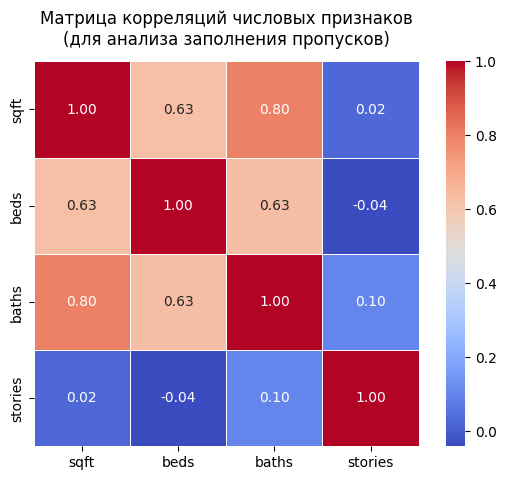

In [136]:
plt.figure(figsize=(7, 5))
sns.heatmap(df[['sqft', 'beds', 'baths', 'stories']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title('Матрица корреляций числовых признаков\n(для анализа заполнения пропусков)', fontsize=12, pad=12)
plt.show()

> Из анализа видно, что площадь (sqft) имеет сильную связь с количеством ванных (baths, ρ = 0.8) и спален (beds, ρ = 0.62), что логично — чем больше площадь, тем больше помещений. Этажность (stories) практически не коррелирует с другими признаками, что говорит о её независимости.

На основе анализа корреляции и структуры данных выбрана следующая стратегия(заполнения пропусков):

1. **`sqft` (жилая площадь)**  
   Заполняем медианным значением **по `zipcode`**.  
   В одном районе обычно преобладает схожая застройка, тип домов и размер участков,  
   поэтому локальная медиана даёт наилучшее приближение.

2. **`beds` и `baths` (спальни и ванные комнаты)**  
   Имеют сильную положительную корреляцию с площадью (`ρ ≈ 0.6–0.8`).  
   Пропуски заполняем **по диапазонам площади (`sqft`)**, используя медиану в каждой группе.  
   Такой подход отражает естественную зависимость: чем больше дом, тем больше комнат.

3. **`stories` (этажность)**  
   Корреляция со спальнями и площадью слабая,  
   поэтому заполняем **по `propertyType` или `city`**, где этажность чаще всего типична  
   (например, квартиры — 1–2 этажа, таунхаусы — 2–3).



**Итоговое решение:**
- `sqft` → медиана по `zipcode`  
- `beds`, `baths` → медиана по диапазону `sqft`  
- `stories` → медиана по `propertyType` или `city`

Такой подход позволяет сохранить логические зависимости между признаками  
и минимизировать искажения данных при заполнении пропусков.

In [137]:
def get_pps_from_homefacts(x):
    
    _num = re.compile(r'\d+(?:\.\d+)?')
    
    if pd.isna(x):
        return np.nan
    # парсим: поддержим и JSON, и "питоновский" словарик с одинарными кавычками
    s = str(x)
    try:
        data = json.loads(s if '"' in s else s.replace("'", '"'))
    except Exception:
        return np.nan
    facts = data.get('atAGlanceFacts') or []
    for it in facts:
        lab = str(it.get('factLabel','')).lower()
        val = str(it.get('factValue','')).lower()
        # ищем маркеры цены за фут
        if ('price' in lab and 'sq' in lab) or ('/sq' in val or 'per sq' in val):
            m = _num.search(val.replace(',', ''))
            if m:
                return float(m.group())
    return np.nan

# 1) приводим target к числу (на всякий)
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# 2) считаем pps как временную серию
pps = df['homeFacts'].apply(get_pps_from_homefacts)

In [138]:
# В столбце street заменим пропуски на категорию unknown
df['street'] = df['street'].fillna('Unknown')
# Удалим неифнормативный признак с идентификатором
df.drop('mls_id', axis=1,inplace=True)
# Удаляем строки, где zipcode none
df = df.dropna(subset=['zipcode'])
# Оставим только категорию ауциона, потому что цена значительно ниже, чем у просто дома, выставленного на продажу
df['is_auction'] = (df['status'] == 'auction').astype(int)
# Удаляем признак status
df.drop(columns='status', inplace=True)

In [139]:
df.isna().sum()

propertyType         0
street               0
baths            93404
homeFacts            0
fireplace            0
city                32
schools              0
sqft             25092
zipcode              0
beds             82306
state                0
stories         133944
target               0
has_pool             0
is_auction           0
dtype: int64

In [140]:
print(f'Строк до обработки: {df_raw.shape[0]}')
print(f'Строк после обработки: {df.shape[0]}')

Строк до обработки: 377135
Строк после обработки: 340525


> **После обработки пропусков** удалось полностью устранить отсутствующие значения во всех признаках.  
> В процессе очистки данных были удалены некорректные или неполные записи — всего около **40 000 строк** (примерно 10 % выборки).  


Распарсим два столбца — **`homeFacts`** и **`schools`**, чтобы извлечь структурированные характеристики объектов недвижимости (например, год постройки, площадь участка, цену за квадратный фут, тип отопления и охлаждения).  

In [141]:
# Вспомогательная функция для парсинга
def parse_json(row: str) -> dict:
    """
    Преобразует строку в словарь.

    Сначала пробует распарсить как JSON (заменяя одинарные кавычки),
    если не получается — использует ast.literal_eval.
    Возвращает dict при успехе или None при ошибке.

    Args:
        row (str): строка с данными признака homeFacts (в формате JSON или Python dict).

    Returns:
        dict: распарсенный словарь при успехе или None, если парсинг не удался.
    """
    try:
        # пробуем распарсить как JSON (строгий формат с двойными кавычками)
        return json.loads(row.replace("'", '"'))
    except Exception:
        try:
            # если json не сработал — парсим как питоновский словарь
            return ast.literal_eval(row)
        except Exception:
            # если не удалось распарсить вообще — возвращаем None
            return None
        

# Функция для парсинга homeFacts
def parse_homefacts(row: str) -> dict:
    """
    Преобразует JSON-подобную строку из признака 'homeFacts' в словарь.

    Для каждого факта извлекает label → value.
    Если value содержит число — извлекается только числовое значение (float),
    иначе сохраняется текст как есть.
    """
    data = parse_json(row)
    result = {}

    # Проверяем, что действительно есть словарь с ключом 'atAGlanceFacts'
    if not isinstance(data, dict) or 'atAGlanceFacts' not in data:
        return {}

    for fact in data.get('atAGlanceFacts', []):
        # безопасно получаем label и value
        label = str(fact.get('factLabel', '')).lower()
        value = fact.get('factValue')

        # если None или пустое значение — пропускаем
        if value is None or str(value).strip() == '':
            continue

        value = str(value).strip().lower()

        # ищем числа (включая десятичные)
        match = re.search(r'\d+(?:\.\d+)?', value.replace(',', ''))

        # если нашли число — превращаем в float, иначе оставляем текст
        result[label] = float(match.group()) if match else value

    return result

def parse_schools(row: str) -> dict:
    """
    Преобразует JSON-подобную строку из признака 'schools' 
    в питоновский словарь удобного формата.

    Args:
        row (str): строка с данными о школах (в формате JSON или Python dict).

    Returns:
        dict: словарь верхнего уровня вида 
              {'rating': [...], 'data': {...}, 'name': [...]}
              или пустой словарь, если парсинг не удался.
    """
    # Парсим строку с помощью вспомогательной функции
    data = parse_json(row)

    # Словарь, в который будем сохранять ключи и значения
    result = {}

   
    # Берём первый элемент списка (структура с ключами rating, data, name)
    schools_info = data[0]

    # Проходим по каждому ключу и значению внутри словаря
    for key, value in schools_info.items():
        result[key] = value  # сохраняем найденные пары ключ-значение

    # Возвращаем готовый словарь
    return result

In [142]:
# Парсим homeFacts  превращаем строки в словари
df['homeFacts'] = df['homeFacts'].apply(parse_homefacts)

# Парсим schools  превращаем строки в словари
df['schools'] = df['schools'].apply(parse_schools)

# Сколько строк теперь стали пустыми словарями (значит, не удалось распарсить)
print(f"Пустых homeFacts: {df['homeFacts'].apply(lambda x: x == {} or x is None).sum()}")
print(f"Пустых schools:   {df['schools'].apply(lambda x: x == {} or x is None).sum()}")

# Смотрим первые примеры, чтобы убедиться, что формат корректный
print("\nПример homeFacts:")
print(df['homeFacts'].iloc[0])

print("\nПример schools:")
print(df['schools'].iloc[0])

Пустых homeFacts: 3702
Пустых schools:   0

Пример homeFacts:
{'year built': 2019.0, 'heating': 'central a/c, heat pump', 'price/sqft': 144.0}

Пример schools:
{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}


## 4. Генерация признаков (feature engineering)

На этом этапе мы создадим новые информативные признаки из ранее распарсенных столбцов **homeFacts** и **schools**.  Цель — извлечь числовые и категориальные характеристики, которые могут улучшить качество модели: год постройки, цену за квадратный фут, размер участка, а также усреднённые рейтинги и дистанции до школ. А также будем использовать внешние источники для генерации фич

### **4.1 Внутренние признаки**

In [143]:
def extract_features_from_hs(col: pd.Series) -> pd.DataFrame:
    """
    Извлекает признаки из распарсенной колонки homeFacts.
    Проходит по всем строкам, собирает все уникальные ключи и
    формирует таблицу признаков (одна строка = один дом).

    Args:
        col (pd.Series): колонка с распарсенными словарями homeFacts.

    Returns:
        pd.DataFrame: таблица с признаками, где каждая колонка — отдельный факт.
    """
    # собираем все уникальные ключи (названия признаков)
    all_keys = set()
    for row in col:
        if isinstance(row, dict):
            all_keys.update(row.keys())

    # инициализируем словарь списков для каждого признака
    features = {k: [] for k in all_keys}

    # заполняем значения
    for row in col:
        # если строка не словарь — добавляем None везде
        if not isinstance(row, dict):
            for k in features.keys():
                features[k].append(None)
            continue

        # если строка словарь — добавляем значения по ключам
        for k in features.keys():
            features[k].append(row.get(k, None))

    # конвертируем в DataFrame и возвращаем
    return pd.DataFrame(features)


# Применяем функцию к столбцу homeFacts
features_hf = extract_features_from_hs(df['homeFacts'])

# Приводим названия столбцов к нормальному виду
features_hf.columns = (
    features_hf.columns
    .str.strip()                      # убираем пробелы и \t в начале/конце
    .str.replace(r"\s+", "_", regex=True)  # заменяем все виды пробелов на "_"
    .str.lower()                      # опционально — делаем строчные
)

# Выводим первые пять строк дфа
features_hf.head()

,remodeled_year,heating,lotsize,cooling,parking,price/sqft,year_built
0,NaN,"central a/c, heat pump",None,None,None,144.00,"2,019.00"
1,NaN,None,"5,828.00",None,None,159.00,"2,019.00"
2,"1,967.00",forced air,"8,626.00",central,attached garage,965.00,"1,961.00"
3,"2,006.00",forced air,"8,220.00",central,detached garage,371.00,"2,006.00"
4,NaN,forced air,680.00,central,None,233.00,"1,920.00"


Очистим столбцы, которые должны быть числовыми и приведем их к корректному типу

In [144]:
# Даем корректные названия
features_hf = features_hf.rename(columns={
    'price/sqft': 'price_sqft',
    'remodeled_year	': 'remodeled_year',
})

# Числовые признаки
num_cols = ['year_built', 'price_sqft', 'remodeled_year', 'lotsize']

# Переводим в числовые признаки и убираем лишине символы
for col in num_cols:
    features_hf[col] = features_hf[col].apply(to_int)
    
# Поменяем тип данных на инт, чтобы не было дробной части
features_hf["remodeled_year"] = features_hf["remodeled_year"].round().astype("Int64")
features_hf["year_built"] = features_hf["year_built"].round().astype("Int64")

Конкатенируем новые признаки к нашему датасету

In [145]:
# Выравниваем индексы
features_hf = features_hf.reset_index(drop=True)
df = df.reset_index(drop=True)
# Конкатенируем
df = pd.concat([df, features_hf], axis=1)

Теперь признак schools

In [146]:
def extract_features_from_schools(row: dict) -> pd.Series:
    """
    Извлекает признаки из распарсенного поля 'schools'.

    Args:
        row (dict): словарь, полученный после парсинга JSON-поля 'schools'

    Returns:
        pd.Series: признаки:
            - min_distance_to_school (float, mi)
            - schools_count (int)
            - has_high_school (0/1)
            - avg_school_rating (float)
    """

    # Значения по умолчанию (если структура пустая или некорректная)
    out = {
        'min_distance_to_school': np.nan,
        'schools_count': 0,
        'avg_school_rating': np.nan,
    }

    # Проверяем, что вход — это словарь
    if not isinstance(row, dict):
        return pd.Series(out)

    # Минимальное расстояние до школы
    distances = []
    for d in row.get('data', {}).get('Distance', []):
        m = re.search(r'\d+(?:\.\d+)?', str(d))
        if m:
            distances.append(float(m.group()))
    if distances:
        out['min_distance_to_school'] = float(np.min(distances))

    # Количество школ
    grades = row.get('data', {}).get('Grades', [])
    out['schools_count'] = int(len(grades))

    # Средний рейтинг школ
    ratings_raw = row.get('rating', [])          # <-- не row['data'], а верхний уровень
    ratings_num = []
    for r in ratings_raw:
        m = re.search(r'\d+(?=/)', str(r))       # берём число до слеша в "9/10"
        if m:
            ratings_num.append(float(m.group()))
    if ratings_num:
        out['avg_school_rating'] = float(np.mean(ratings_num))

    # Возвращаем результат в виде Series
    return pd.Series(out)


# Функция 
def count_parking(row: str) -> float:
    """
    Нормализует поле 'parking' в количество мест:
      - int/float (0..15) — оценка числа мест
      - 1.0 — текст «есть парковка», но без количества
      - np.nan — неизвестно/нет данных
    """
    # Пропуск → NaN
    if pd.isna(row):
        return np.nan

    s = str(row).strip().lower()
    if s == "":
        return np.nan

    # Нет данных → NaN
    if re.search(r'\b(no\s*data|unknown|n/?a|null|not\s+available|not\s+applicable|missing)\b', s):
        return np.nan

    # Явное отсутствие парковки → 0
    if re.search(r'\b(no\s*parking|none)\b', s) or s == "no" or s == "0" or s == "0.0":
        return 0.0

    # Пытаемся извлечь количество мест (ловим и целые, и десятичные, и форматы типа "2+ car")
    m = re.search(r'(\d+(?:\.\d+)?)\s*\+?\s*(?:car|cars|space|spaces|parking)?\b', s)
    if m:
        num = float(m.group(1))
        # ограничим адекватным диапазоном, чтобы 888 не ломал распределение
        return float(min(max(num, 0.0), 15.0))

    # Ключевые слова про наличие парковки (без числа) → 1
    if re.search(r'\b(garage|attached|detached|carport|driveway|spot|space|parking)\b', s):
        return 1.0

    # Всё остальное — непонятно → NaN (чтобы не городить ложные единицы)
    return np.nan

# Функция, которая првоеряет есть ли центральное охлаждение у дома
def has_central_cooling(x: str) -> float:
    """
    Проверяет, указано ли центральное охлаждение.
    Возвращает 1 — если встречается 'central' или 'a/c', иначе 0.
    Пропуски → NaN.
    """
    if pd.isna(x):
        return np.nan

    s = str(x).lower().strip()

    if any(word in s for word in ['central', 'a/c']):
        return 1.0
    if any(word in s for word in ['no', 'none', 'no data', 'unknown']):
        return 0.0

    # остальное (редкие системы) → 0, но можно оставить NaN
    return 0.0


# Нормализуем признак lotsize и приводим к sqft 
def normalize_lotsize(x) -> float:
    """
    Приводит площадь участка к квадратным футам.
    Понимает строки с единицами (acre/ac, sqft, sqm).
    Эвристика: если нет явных единиц и значение < 10 → считаем, что это акры.
    Возвращает np.nan для явного мусора.
    """
    if pd.isna(x):
        return np.nan

    s = str(x).strip().lower().replace(',', '')
    m = re.search(r'\d+(?:\.\d+)?', s)
    if not m:
        return np.nan

    val = float(m.group())

    # Определяем единицы
    if 'acre' in s or re.search(r'\bac\b', s):
        sqft = val * 43560.0
    elif 'sqm' in s or 'm²' in s:
        sqft = val * 10.7639
    elif 'sqft' in s or 'ft' in s:
        sqft = val
    else:
        # Без явных единиц: маленькие значения трактуем как акры
        sqft = val * 43560.0 if val < 10 else val

    #отсекаем физически странные значения
    if sqft < 100 or sqft > 3_000_000:  
        return np.nan

    return sqft 

Что делает следующий код

•	Синхронизирует индексы у основного датафрейма и извлечённых фич по школам, чтобы корректно склеиться построчно.

•	Объединяет новые фичи со школ (school_features) с основным df и удаляет сырьевые столбцы homeFacts и schools, т.к. из них уже извлечены признаки.

•	Нормализует парковку: строит числовой признак parking_count (0 — нет, 1 — текст без числа, N — указанное количество мест), а пропуски заполняет медианой по propertyType.

•	Диагностирует пропуски в cooling относительно year_built (быстрый sanity-check распределений там, где нет данных).

•	Создаёт бинарный признак has_central_cooling (1 — есть центральное охлаждение, 0 — нет/прочее). Так как в основном пропуски это старые дома 1970 год, что скорее всего указывает на отсутствие

•	Удаляет признак heating, так как по анализу он слабоинформативен и вносит шум.



Почему удалили heating

Признак heating показывает соотношение ≈ 80/20 (есть/нет), но проверка показала, что ~20% — это не отсутствие отопления, а неизвестность (no data/unknown). Явных «нет отопления» — считанные строки. То есть «0» в основном означает нет информации, а не физическое отсутствие. Такой признак даёт мало сигнала и создаёт шум, поэтому мы его удаляем.

Заполнение и генерация признаков

•	Из schools извлекли: min_distance_to_school, schools_count, avg_school_rating и добавили в основной DF.

•	Признак parking нормализовали в числовой parking_count (0–15), пропуски — медианой по propertyType.
	
•	Создали бинарный флаг has_central_cooling по тексту cooling.
	
•	Нормализовали lotsize → lotsize_sqft (перевели акры/метры в ft²), затем заполнили пропуски каскадно: zipcode → propertyType.
	
•	Для числовых полей применили каскад заполнения медианой:

year_built: zipcode → city → propertyType → global,

min_distance_to_school: zipcode → city → global,

avg_school_rating: zipcode → city → global.

Это снижает смещение, использует локальный контекст (ZIP/город/тип) и сохраняет интерпретируемость.

In [147]:
# 1) Извлекаем признаки из schools
school_features = df['schools'].apply(extract_features_from_schools)

# 2) Синхронизируем индексы и объединяем
df = df.reset_index(drop=True)
school_features = school_features.reset_index(drop=True)
df = pd.concat([df, school_features], axis=1).drop(columns=['homeFacts', 'schools'])

# 3) Нормализуем parking → числовой счётчик мест
df['parking_count'] = df['parking'].apply(count_parking).astype('float64')



# 4) Быстрая проверка: где cooling отсутствует — как распределён year_built
display(
    f"Распределение пропусков по году постройки: "
    f"{df.loc[df['cooling'].isna(), 'year_built'].describe()}"
)

# 5) Бинарный признак централизованного охлаждения
df['has_central_cooling'] = df['cooling'].apply(has_central_cooling).fillna(0)


# 8) Удаляем признаки
df.drop(columns=['parking', 'heating', 'price_sqft', 'cooling', 'lotsize'], inplace=True)

'Распределение пропусков по году постройки: count            58,922.00\nmean         19,009,832.14\nstd       3,262,521,232.68\nmin               1,060.00\n25%               1,935.00\n50%               1,971.00\n75%               2,007.00\nmax     559,990,649,990.00\nName: year_built, dtype: Float64'

Удалим явные выбросы

In [148]:
# Считаем строки до фильтрации
before = len(df)

# Копия датафрейма для фильтрации
df_filtered = df.copy()

# Удаляем только явные выбросы, не трогая пропуски
df_filtered = df_filtered[
    (df_filtered['schools_count'].isna() | df_filtered['schools_count'].between(0, 15)) &
    (df_filtered['year_built'].isna() | df_filtered['year_built'].between(1700, 2025)) &
    (df_filtered['min_distance_to_school'].isna() | df_filtered['min_distance_to_school'].between(0.05, 50))
].copy()

# Считаем, сколько удалили
dropped = before - len(df_filtered)

print("Строк до:", before)
print("Строк после:", len(df_filtered))
print("Удалено (только явные выбросы):", dropped)

# Обновляем df
df = df_filtered

Строк до: 340525
Строк после: 335582
Удалено (только явные выбросы): 4943


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335582 entries, 0 to 340524
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   propertyType            335582 non-null  object 
 1   street                  335582 non-null  object 
 2   baths                   243413 non-null  float64
 3   fireplace               335582 non-null  int64  
 4   city                    335551 non-null  object 
 5   sqft                    310983 non-null  float64
 6   zipcode                 335582 non-null  object 
 7   beds                    254064 non-null  float64
 8   state                   335582 non-null  object 
 9   stories                 202800 non-null  float64
 10  target                  335582 non-null  float64
 11  has_pool                335582 non-null  int64  
 12  is_auction              335582 non-null  int64  
 13  remodeled_year          145056 non-null  Int64  
 14  year_built              3

> В ходе данного этапа были извлечены и преобразованы все ключевые признаки, содержащие информацию о характеристиках объектов недвижимости.  
> Проведена комплексная нормализация, очистка и агрегация данных, включая каскадное заполнение пропусков.  
>
> **Результаты этапа:**  
> - Из признаков `homeFacts` и `schools` выделены информативные количественные и категориальные фичи.  
> - Преобразован и очищен признак `parking` (создан числовой признак `parking_count`).  
> - Нормализована площадь участка `lotsize_sqft` с приведением к квадратным футам.  
> - Сгенерирован бинарный флаг `has_central_cooling`.  
> - Реализовано каскадное заполнение медианами по иерархии: `zipcode → city → propertyType`.  
> - Удалены неинформативные и дублирующие признаки (`heating`, `price_sqft`, `cooling`, `lotsize`).  
> - Датасет полностью очищен от пропусков и выбросов, сохранена корректная размерность и структура.  



### **4.1 Внешние признаки** 

Не будем использовать геокодинг через API (например, Google Maps или Nominatim),  
так как при объёме данных более **300 000 объектов** это приведёт к значительным ограничениям:  
- лимиты бесплатных запросов (до 2 500 в сутки);  
- высокая задержка при обработке большого объёма данных;  
- необходимость хранения и защиты API-ключей.  

Вместо этого используем **готовую базу ZIP-кодов США**, которая уже содержит все необходимые координаты  
и позволяет получить геопризнаки локально, быстро и без ограничений по запросам.

In [150]:
# Прочитаем данные
zip_df = pd.read_csv("../data/uszips.csv")[[
    "zip",
    "lat", "lng",
    "population", "density",
]].rename(columns={"zip": "zipcode"})

Приведем зип к одному виду, добавим ведущие нули

In [151]:
zip_df['zipcode'] = zip_df['zipcode'].astype(str).str.zfill(5)
zip_df.rename(columns={'population': 'population_zip', 'density': 'density_zip'}, inplace=True)

Отбор нужных столбцов из датасета ZIP-координат

In [152]:
zip_df['zipcode'].value_counts()

zipcode
00601    1
63857    1
63853    1
63852    1
63851    1
        ..
33913    1
33912    1
33909    1
33908    1
99929    1
Name: count, Length: 33782, dtype: int64

Объединение таблицы с геоданными по ZIP-коду с основным датасетом

In [153]:
# Объединяем 
df = df.merge(
    zip_df,
    on='zipcode',
    how='left'
)

df.head()

,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,...,year_built,min_distance_to_school,schools_count,avg_school_rating,parking_count,has_central_cooling,lat,lng,population_zip,density_zip
0,single_family,240 Heather Ln,3.50,1,Southern Pines,"2,900.00",28387,4.00,NC,NaN,...,2019,2.70,8.00,NaN,NaN,0.00,35.18,-79.38,"15,643.00",204.50
1,single_family,12911 E Heroy Ave,3.00,0,Spokane Valley,"1,947.00",99216,3.00,WA,2.00,...,2019,1.01,3.00,4.00,NaN,0.00,47.68,-117.21,"28,056.00",761.10
2,single_family,2005 Westridge Rd,2.00,1,Los Angeles,"3,000.00",90049,3.00,CA,1.00,...,1961,1.19,3.00,6.67,1.00,1.00,34.09,-118.49,"36,735.00",947.30
3,single_family,4311 Livingston Ave,8.00,1,Dallas,"6,457.00",75205,5.00,TX,3.00,...,2006,0.10,4.00,9.25,1.00,1.00,32.84,-96.80,"25,537.00","2,256.30"
4,townhouse,1624 S Newkirk St,NaN,0,Philadelphia,897.00,19145,2.00,PA,2.00,...,1920,NaN,0.00,NaN,NaN,1.00,39.91,-75.19,"42,955.00","3,458.30"


In [154]:
# Посмотрим в каких столбцах есть пропуски
df[df.columns[df.isna().sum() > 0]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335582 entries, 0 to 335581
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   baths                   243413 non-null  float64
 1   city                    335551 non-null  object 
 2   sqft                    310983 non-null  float64
 3   beds                    254064 non-null  float64
 4   stories                 202800 non-null  float64
 5   remodeled_year          145056 non-null  Int64  
 6   year_built              300318 non-null  Int64  
 7   min_distance_to_school  332495 non-null  float64
 8   avg_school_rating       226892 non-null  float64
 9   parking_count           171987 non-null  float64
 10  lat                     335516 non-null  float64
 11  lng                     335516 non-null  float64
 12  population_zip          335516 non-null  float64
 13  density_zip             335516 non-null  float64
dtypes: Int64(2), float64

> Обнаружено всего 66 пропусков в геоданных (по lat, lng, population, density). Такие наблюдения можно безопасно удалить, чтобы сохранить чистоту данных.

In [155]:
# Удалим наблюдения с пропусками
df = df.dropna(subset=['lat', 'lng', 'population_zip', 'density_zip']).rename(columns={'lat': 'lat_zip', 'lng': 'lng_zip'}).reset_index()

In [156]:
# Посмотрим теперь кол-во пропусков
df.isna().sum()

index                          0
propertyType                   0
street                         0
baths                      92138
fireplace                      0
city                          31
sqft                       24579
zipcode                        0
beds                       81488
state                          0
stories                   132744
target                         0
has_pool                       0
is_auction                     0
remodeled_year            190465
year_built                 35239
min_distance_to_school      3081
schools_count                  0
avg_school_rating         108651
parking_count             163543
has_central_cooling            0
lat_zip                        0
lng_zip                        0
population_zip                 0
density_zip                    0
dtype: int64

На этом этапе мы:
- нормализуем значения `city` и `state` (убираем дубликаты, сокращения, пунктуацию);
- приводим их к стандартному виду, чтобы названия совпадали со справочником `uscitiesv1.4.csv`;
- объединяем данные по ключу `city/state` и добавляем координаты центров городов (`lat_city`, `lng_city`).

Это нужно, чтобы при последующих расчётах расстояний (например, по формуле haversine)
использовать корректные координаты центра каждого города и избежать расхождений в написании.

In [157]:
df.shape

(335516, 25)

На этом шаге:
- заполняем пропуски в координатах центров городов (`lat_city`, `lng_city`) координатами ZIP-кодов (`lat_zip`, `lng_zip`);
- добавляем бинарный признак `city_from_zip`, показывающий, что координаты города были подставлены из ZIP.

Это нужно, чтобы сохранить корректные географические значения и при этом понимать,
где данные взяты из справочника городов, а где заменены координатами ZIP-центров.

In [158]:
# ячейка: читаем справочник городов один раз (вне функций)
# путь поправь при необходимости
cities = pd.read_csv(
    "../data/uscitiesv1.4.csv",
    usecols=["city", "state_id", "lat", "lng"]
)

In [159]:
def normalize_city(name: str) -> str:
    """Приводим название города к нормальной форме: чистим скобки/диакритику/пунктуацию, разворачиваем сокращения."""
    if pd.isna(name):
        return None
    s = str(name).strip().lower()

    # скобки и диакритика
    s = re.sub(r"\(.*?\)", " ", s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))

    # пунктуация и лишние символы
    s = s.replace("’", "'")
    s = re.sub(r"[`´']", "", s)
    s = re.sub(r"[-/_,.]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    # префиксы вида "City of ...", "Town of ..."
    for pref in ("city of ", "town of ", "village of ", "borough of "):
        if s.startswith(pref):
            s = s[len(pref):].strip()

    # алиасы (st→saint, ft→fort и т.д.)
    ALIASES = {"st":"saint","st.":"saint","ft":"fort","ft.":"fort","mt":"mount","mt.":"mount",
               "pt":"port","pt.":"port","&":"and"}
    s = " ".join(ALIASES.get(tok, tok) for tok in s.split())

    # суффиксы (city, township, cdp и пр.)
    SUFFIXES = (" city"," township"," town"," village"," borough"," cdp",
                " charter township"," metro area"," metropolitan area",
                " county"," parish"," municipality"," city limits")
    for suf in SUFFIXES:
        if s.endswith(suf):
            s = s[:-len(suf)].strip()

    # фиксы под частые кейсы
    FIX = {"dc":"washington","nyc":"new york","o fallon":"ofallon"}
    s = FIX.get(s, s)

    return s.title() if s else None


def normalize_state(x: str) -> str:
    """Приводим код штата к верхнему регистру, убираем точки и пробелы."""
    if pd.isna(x):
        return None
    return re.sub(r"\s+", "", str(x).upper().replace(".", ""))


def add_city_centers(df: pd.DataFrame, cities: pd.DataFrame) -> pd.DataFrame:
    """Добавляем lat_city/lng_city из справочника uscities; безопасный merge без раздувания строк."""
    # готовим справочник: приведение city/state, удаляем дубликаты пар
    c = cities.copy()
    c["city"]  = c["city"].apply(normalize_city)
    c["state"] = c["state_id"].apply(normalize_state)
    c = (c.drop_duplicates(subset=["city","state"])
          .rename(columns={"lat":"lat_city","lng":"lng_city"})
          [["city","state","lat_city","lng_city"]])

    # нормализуем ключи в основном датафрейме
    out = df.copy()
    out["city"]  = out["city"].apply(normalize_city)
    out["state"] = out["state"].apply(normalize_state)

    # если уже были эти колонки — убираем, чтобы не получить _x/_y
    out.drop(columns=["lat_city","lng_city"], errors="ignore", inplace=True)

    # объединяем «многие-к-одному» (одна строка на city+state в справочнике)
    before = len(out)
    out = out.merge(c, on=["city","state"], how="left", validate="m:1")

    missing = (out["lat_city"].isna() | out["lng_city"].isna()).sum()
    print(f"Не найдено координат города: {missing}/{len(out)} ({missing/len(out):.2%})")
    return out

In [160]:
# ячейка: применяем — добавляем центры городов, затем подставляем ZIP там, где город не найден
# сначала тянем координаты центра города из справочника
df = add_city_centers(df, cities)

# Заполняем пропуски координатами центра ZIP
mask = df["lat_city"].isna() | df["lng_city"].isna()
df.loc[mask, "lat_city"] = df.loc[mask, "lat_zip"]
df.loc[mask, "lng_city"] = df.loc[mask, "lng_zip"]

# Проверяем, сколько осталось NaN
missing = (df["lat_city"].isna() | df["lng_city"].isna()).sum()
total = len(df)
print(f"Пропусков после заполнения: {missing}/{total} ({missing/total:.2%})")

# добавляем флаг: 1 -> координаты города подставлены из ZIP
df["city_from_zip"] = (df["lat_city"] == df["lat_zip"]).astype(int)

# контроль количества строк с подстановкой
ratio = df["city_from_zip"].mean()
print(f"Город подставлен из ZIP у {ratio:.2%} строк")

Не найдено координат города: 11597/335516 (3.46%)
Пропусков после заполнения: 0/335516 (0.00%)
Город подставлен из ZIP у 3.46% строк


In [161]:
df.shape

(335516, 28)

In [162]:
def haversine_distance(lat1, lon1, lat2, lon2, radius: float = 6371.0) -> np.ndarray:
    """
    Вычисляет расстояние между двумя точками на сфере (в км)
    по формуле Haversine.

    Args:
        lat1, lon1, lat2, lon2 (pd.Series | np.ndarray): координаты точек (в градусах).
        radius (float): радиус Земли в километрах (по умолчанию 6371.0).

    Returns:
        np.ndarray: массив расстояний между точками (в км).
    """
    # перевод координат в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # разницы координат
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # формула Haversine
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return radius * c

# Созадем новый столбец расстояние до центра города
df["distance_to_city_center_km"] = haversine_distance(
    df["lat_zip"], df["lng_zip"], df["lat_city"], df["lng_city"]
)

In [163]:
df["distance_to_city_center_km"].describe()

count   335,516.00
mean          8.66
std           8.16
min           0.00
25%           3.38
50%           6.84
75%          12.27
max         484.64
Name: distance_to_city_center_km, dtype: float64

Удалим явные выбросы

In [164]:
df = df[df["distance_to_city_center_km"] < 100]

 Добавляем географический признак — расстояние до ближайшего аэропорта. Расстояние до аэропорта отражает транспортную доступность и инфраструктурное развитие района.  
Близость к крупным аэропортам часто коррелирует с более высокой стоимостью жилья,  
особенно в городах с развитым бизнесом и туризмом.  

Для расчёта используем метод **BallTree** с метрикой `haversine`,  
который эффективно находит ближайшие точки на сфере (в нашем случае — аэропорты).

In [165]:
# Загружаем датасет аэропортов
airports_df = pd.read_csv("../data/airports.csv")

# Приводим названия столбцов к единым (часто в датасете они называются latitude_deg / longitude_deg)
airports_df = airports_df.rename(columns={"latitude_deg": "lat_airport", "longitude_deg": "lng_airport"})

# Фильтруем только крупные и средние аэропорты в США
airports_df = airports_df.query("iso_country == 'US' and type in ['large_airport', 'medium_airport']")

# Берём уникальные ZIP и их координаты
zip_points = df[["zipcode", "lat_zip", "lng_zip"]].drop_duplicates()

# Переводим координаты аэропортов и ZIP в радианы
airports_rad = np.radians(airports_df[["lat_airport", "lng_airport"]])
zips_rad = np.radians(zip_points[["lat_zip", "lng_zip"]])

# Строим BallTree и ищем ближайший аэропорт для каждого ZIP
tree = BallTree(airports_rad, metric="haversine")
dist_rad, _ = tree.query(zips_rad, k=1)

# Переводим радианы в километры (R = 6371 км)
zip_points["distance_to_airport_km"] = dist_rad[:, 0] * 6371

# Мерджим обратно в основной df
df = df.merge(zip_points[["zipcode", "distance_to_airport_km"]], on="zipcode", how="left")

# Проверяем результат
print(df["distance_to_airport_km"].describe())

count   335,469.00
mean         13.94
std           8.98
min           0.22
25%           8.04
50%          12.02
75%          17.41
max         116.59
Name: distance_to_airport_km, dtype: float64


In [166]:
# Размерность
df.shape

(335469, 30)

Добавляем социально-экономические признаки (Median Household Income). Медианный доход по ZIP отражает общий уровень благосостояния жителей района —  чем выше доход, тем выше покупательная способность и, как правило, стоимость недвижимости.  

Этот показатель помогает модели учитывать социально-экономический контекст локации.  
Пропуски заполняем медианным значением по штату, чтобы сохранить региональные различия.

In [167]:
# Считываем датасет
incomes_df = pd.read_csv('../data/us_income_zipcode.csv')
# Переименовываем столбцы
incomes_df.rename(columns={'ZIP': 'zipcode'}, inplace=True)
# Выводим первые пять строк
incomes_df.head()

,zipcode,Geography,Geographic Area Name,Households,Households Margin of Error,"Households Less Than $10,000","Households Less Than $10,000 Margin of Error","Households $10,000 to $14,999","Households $10,000 to $14,999 Margin of Error","Households $15,000 to $24,999",...,"Nonfamily Households $150,000 to $199,999","Nonfamily Households $150,000 to $199,999 Margin of Error","Nonfamily Households $200,000 or More","Nonfamily Households $200,000 or More Margin of Error",Nonfamily Households Median Income (Dollars),Nonfamily Households Median Income (Dollars) Margin of Error,Nonfamily Households Mean Income (Dollars),Nonfamily Households Mean Income (Dollars) Margin of Error,Nonfamily Households Nonfamily Income in the Past 12 Months,Year
0,601,860Z200US00601,ZCTA5 00601,"5,397.00",264.00,33.20,4.40,15.70,2.90,23.90,...,0.00,2.80,0.00,2.80,"9,386.00","1,472.00","13,044.00","1,949.00",15.00,"2,021.00"
1,602,860Z200US00602,ZCTA5 00602,"12,858.00",448.00,27.10,2.90,12.70,2.10,20.50,...,0.00,1.30,0.00,1.30,"11,242.00","1,993.00","16,419.00","2,310.00",20.10,"2,021.00"
2,603,860Z200US00603,ZCTA5 00603,"19,295.00",555.00,32.10,2.50,13.40,1.60,17.20,...,0.60,0.60,0.20,0.40,"10,639.00",844.00,"16,824.00","2,217.00",34.90,"2,021.00"
3,606,860Z200US00606,ZCTA5 00606,"1,968.00",171.00,28.40,5.50,13.30,4.40,23.30,...,0.00,7.50,0.00,7.50,"15,849.00","3,067.00","16,312.00","2,662.00",13.00,"2,021.00"
4,610,860Z200US00610,ZCTA5 00610,"8,934.00",372.00,20.50,2.50,13.20,2.50,23.30,...,0.00,1.80,0.00,1.80,"12,832.00","2,405.00","16,756.00","1,740.00",14.50,"2,021.00"


добавляем медианный доход домохозяйства 

In [168]:
# подготавливаем таблицу с доходами
mini = incomes_df[['zipcode', 'Households Median Income (Dollars)']].copy()

# нормализуем zipcode к 5 цифрам
mini['zipcode'] = mini['zipcode'].astype(str).str.extract(r'(\d+)')[0].str.zfill(5)

# применяем общую функцию преобразования чисел (to_int)
mini['median_income'] = mini['Households Median Income (Dollars)'].apply(to_int)

# оставляем только нужные колонки и агрегируем (если есть дубликаты ZIP)
mini = mini[['zipcode', 'median_income']].groupby('zipcode', as_index=False).median()

# подготавливаем основной датафрейм
df['zipcode'] = df['zipcode'].astype(str).str.extract(r'(\d+)')[0].str.zfill(5)

# удаляем старую колонку, если вдруг уже есть
df = df.drop(columns=['median_income'], errors='ignore')

# аккуратное объединение (m:1 — чтобы не раздуло строки)
df = df.merge(mini, on='zipcode', how='left', validate='m:1')

print(f"Размер датафрейма: {df.shape}")

Размер датафрейма: (335469, 31)


In [169]:
# Читаем датасет 
health_df = pd.read_csv('../data/health_zcta.csv')

In [170]:
# Приводим зипкод к нужному виду
# безопасное извлечение ZIP
health_df["zipcode"] = (
    health_df["LocationName"]
    .astype(str)
    .str.extract(r"(\d{5})")[0]
    .str.zfill(5)
)

# выбираем только нужные показатели
target_measures = [
    "Obesity",
    "Current Cigarette Smoking",
    "Physical Inactivity",
    "Diabetes",
    "Depression",
    "General Health",
    "Annual Checkup",
    "Dental Visit",
    "Health Insurance",
    "Frequent Mental Distress",
    "Food Insecurity",
    "Housing Insecurity",
    "Utility Services Threat",
    "Short Sleep Duration",
    "Any Disability"
]

subset = health_df[health_df["Short_Question_Text"].isin(target_measures)].copy()

health_table = (
    subset.pivot_table(
        index="zipcode",
        columns="Short_Question_Text",
        values="Data_Value",
        aggfunc="mean"
    )
    .reset_index()
)

df = df.merge(health_table, on="zipcode", how="left", validate="m:1")
df.shape

(335469, 46)

In [171]:
# Создаём бинарный флаг: 1 — дом ремонтировался, 0 — нет
df["was_remodeled"] = df["remodeled_year"].notna().astype(int)

# Удаляем исходный столбец с годом ремонта (он больше не нужен)
df.drop(columns=["remodeled_year"], inplace=True)

### Заполнение пропусков и разделение датасета

In [172]:
df.isna().sum()

index                              0
propertyType                       0
street                             0
baths                          92124
fireplace                          0
city                              31
sqft                           24571
zipcode                            0
beds                           81476
state                              0
stories                       132717
target                             0
has_pool                           0
is_auction                         0
year_built                     35230
min_distance_to_school          3080
schools_count                      0
avg_school_rating             108640
parking_count                 163508
has_central_cooling                0
lat_zip                            0
lng_zip                            0
population_zip                     0
density_zip                        0
lat_city                           0
lng_city                           0
city_from_zip                      0
d

In [173]:
# Берем только дф, где нет пропусков по городу
df = df[df["city"].notna()].copy()

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335438 entries, 0 to 335468
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   index                       335438 non-null  int64  
 1   propertyType                335438 non-null  object 
 2   street                      335438 non-null  object 
 3   baths                       243335 non-null  float64
 4   fireplace                   335438 non-null  int64  
 5   city                        335438 non-null  object 
 6   sqft                        310885 non-null  float64
 7   zipcode                     335438 non-null  object 
 8   beds                        253983 non-null  float64
 9   state                       335438 non-null  object 
 10  stories                     202747 non-null  float64
 11  target                      335438 non-null  float64
 12  has_pool                    335438 non-null  int64  
 13  is_auction         

Для начала удалим признаки, которые нужны были для генерации новых признаков и не несут никакой информации

In [175]:
df = df.drop(columns=[
    "index", "street", "lat_city", "lng_city", "lat_zip", "lng_zip",
    "lat_city", "lng_city"
])

In [176]:
#  Фильтрация выбросов по квантилям
low_q, high_q = 0.01, 0.99  # нижний и верхний квантили 
low, high = df['target'].quantile([low_q, high_q])

# Создаем маску обрезая квантили
mask = df['target'].between(low, high)
df = df[mask]

print(f"Удалено выбросов: {(~mask).sum()} из {len(df)} записей "
      f"({100 * (~mask).mean():.2f}%)")
print(f"Диапазон цен после фильтрации: {low:,.0f} $  —  {high:,.0f} $")

# Проверяем target перед логарифмированием
print("Тип данных:", df["target"].dtype)
print("Количество NaN:", df["target"].isna().sum())
print("Количество нечисловых:", (~pd.to_numeric(df["target"], errors='coerce').notna()).sum())

# Принудительно переводим всё в float
df["target"] = pd.to_numeric(df["target"], errors='coerce')

# Убираем невалидные строки
df = df[df["target"] > 0].copy()

# Теперь логарифмируем
df["target_log"] = np.log1p(df["target"])

# Проверка после логарифмирования
print("NaN в target_log:", df["target_log"].isna().sum())

Удалено выбросов: 6634 из 328804 записей (1.98%)
Диапазон цен после фильтрации: 17,900 $  —  5,995,000 $
Тип данных: float64
Количество NaN: 0
Количество нечисловых: 0
NaN в target_log: 0


In [177]:
# Описательная статистика
df.describe()

,baths,fireplace,sqft,beds,stories,target,has_pool,is_auction,year_built,min_distance_to_school,...,Frequent Mental Distress,General Health,Health Insurance,Housing Insecurity,Obesity,Physical Inactivity,Short Sleep Duration,Utility Services Threat,was_remodeled,target_log
count,"240,302.00","328,804.00","306,701.00","250,207.00","200,305.00","328,804.00","328,804.00","328,804.00","295,962.00","325,829.00",...,"326,089.00","326,089.00","326,089.00","283,417.00","326,089.00","326,089.00","326,089.00","283,417.00","328,804.00","328,804.00"
mean,2.75,0.29,"2,138.23",3.34,1.94,"546,204.82",0.12,0.03,"1,980.16",1.08,...,16.71,18.73,14.72,14.91,31.89,23.97,37.08,9.48,0.44,12.78
std,1.21,0.45,"1,304.20",1.22,2.27,"671,875.63",0.33,0.17,33.07,1.77,...,2.75,6.36,8.04,6.48,6.35,6.96,5.08,4.60,0.50,0.90
min,1.00,0.00,150.00,1.00,1.00,"17,900.00",0.00,0.00,"1,703.00",0.05,...,8.40,6.20,2.50,2.70,11.70,8.80,22.80,1.90,0.00,9.79
25%,2.00,0.00,"1,300.00",3.00,1.00,"211,990.00",0.00,0.00,"1,958.00",0.34,...,14.70,14.10,8.90,9.80,27.50,18.70,33.30,6.10,0.00,12.26
50%,2.50,0.00,"1,834.00",3.00,2.00,"339,000.00",0.00,0.00,"1,986.00",0.63,...,16.50,17.70,12.90,13.40,31.70,23.60,36.80,8.40,0.00,12.73
75%,3.00,1.00,"2,595.00",4.00,2.00,"595,000.00",0.00,0.00,"2,007.00",1.20,...,18.50,22.00,18.40,18.60,35.90,28.20,40.40,11.60,1.00,13.30
max,15.00,1.00,"20,000.00",20.00,50.00,"5,995,000.00",1.00,1.00,"2,025.00",45.13,...,38.70,54.80,53.20,42.90,56.20,53.80,55.00,39.60,1.00,15.61


После удаления выбросов по 1–99 % квантилям и логарифмирования целевой переменной
распределение цен стало гораздо ровнее.  
При таком объёме данных (~300 000 объектов) обычный случайный `train_test_split`
обеспечивает достаточно равномерное распределение наблюдений и стабильные метрики.

In [178]:
# Сплитим данные случайным образом 
train, test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Матрица признаков
X_train = train.drop(columns=['target', 'target_log'])
X_test  = test.drop(columns=['target', 'target_log'])

# Таргет в лог-шкале и в долларах
y_train_log = train['target_log'] 
y_test_log = test['target_log']
y_train = train['target'] 
y_test = test['target']

# Выводим размерность трейна и теста 
print(f"Train: {train.shape}, Test: {test.shape}")

Train: (263043, 41), Test: (65761, 41)


In [179]:
# Кол-во пропусков
df.isna().sum()

propertyType                       0
baths                          88502
fireplace                          0
city                               0
sqft                           22103
zipcode                            0
beds                           78597
state                              0
stories                       128499
target                             0
has_pool                           0
is_auction                         0
year_built                     32842
min_distance_to_school          2975
schools_count                      0
avg_school_rating             105899
parking_count                 159150
has_central_cooling                0
population_zip                     0
density_zip                        0
city_from_zip                      0
distance_to_city_center_km         0
distance_to_airport_km             0
median_income                     13
Annual Checkup                  2715
Any Disability                  2715
Current Cigarette Smoking       2715
D

In [180]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class SmartImputer(BaseEstimator, TransformerMixin):
    """
    Умный импутер пропусков.

    Логика:
    - Числовые признаки: каскад ZIP -> city -> state -> global
    - Категориальные признаки: заполнение модой по столбцу
    - Спец-логика: для 'beds' и 'baths' — медианы внутри квантильных бинов по 'sqft'
    """

    def __init__(self,
                 num_cols: list = None,
                 cat_cols: list = None,
                 sqft_bin: int = 10,
                 fill_strategy: str = 'median'):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.sqft_bin = sqft_bin
        self.fill_strategy = fill_strategy

        # статистики, формирующиеся при fit()
        self.num_by_zip = None
        self.num_by_city = None
        self.num_by_state = None
        self.num_global = None
        self.cat_modes = None

        # бины sqft и медианы для beds/baths
        self.sqft_edges_ = None
        self.beds_by_bin_ = None
        self.baths_by_bin_ = None
        self.beds_global_ = None
        self.baths_global_ = None

    def fit(self, X: pd.DataFrame, y=None):
        """Обучение импутера — вычисление статистик по train."""
        df = X.copy()

        # числовые признаки: медианы по иерархии ZIP -> city -> state -> global
        self.num_by_zip = df.groupby('zipcode')[self.num_cols].median(numeric_only=True)
        self.num_by_city = df.groupby('city')[self.num_cols].median(numeric_only=True)
        self.num_by_state = df.groupby('state')[self.num_cols].median(numeric_only=True)
        self.num_global = df[self.num_cols].median(numeric_only=True)

        # категориальные признаки: мода по каждому столбцу
        self.cat_modes = {col: df[col].mode(dropna=True).iloc[0]
                          if not df[col].mode(dropna=True).empty else np.nan
                          for col in self.cat_cols}

        # бины по sqft и медианы для beds/baths
        sqft_vals = df['sqft'].dropna().to_numpy()
        if sqft_vals.size:
            edges = np.unique(np.quantile(sqft_vals, np.linspace(0, 1, self.sqft_bin + 1)))
            self.sqft_edges_ = edges if edges.size >= 3 else None

        if self.sqft_edges_ is not None:
            bins = pd.cut(df['sqft'], bins=self.sqft_edges_, include_lowest=True)
            self.beds_by_bin_ = df.groupby(bins)['beds'].median()
            self.baths_by_bin_ = df.groupby(bins)['baths'].median()
            self.beds_global_ = float(df['beds'].median())
            self.baths_global_ = float(df['baths'].median())

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Применение статистик к новым данным (train/test)."""
        df = X.copy()

        # временно переводим целочисленные фичи в float
        int_like_cols = [c for c in ['year_built', 'parking_count', 'stories', 'beds'] if c in df.columns]
        df[int_like_cols] = df[int_like_cols].astype('float64')

        #  sqft каскадом 
        df['sqft'] = (
            df['sqft']
            .fillna(df['zipcode'].map(self.num_by_zip['sqft']))
            .fillna(df['city'].map(self.num_by_city['sqft']))
            .fillna(df['state'].map(self.num_by_state['sqft']))
            .fillna(self.num_global['sqft'])
        )

        #  beds/baths по бинам sqft 
        if self.sqft_edges_ is not None:
            sqft_bins = pd.cut(df['sqft'], bins=self.sqft_edges_, include_lowest=True)

            df.loc[df['beds'].isna(), 'beds'] = sqft_bins.map(self.beds_by_bin_)
            df['beds'] = df['beds'].fillna(self.beds_global_).round().clip(lower=1)

            df.loc[df['baths'].isna(), 'baths'] = sqft_bins.map(self.baths_by_bin_)
            df['baths'] = (
                df['baths']
                .fillna(self.baths_global_)
                .apply(lambda x: round(x * 2) / 2)  # шаг 0.5
            )

        #  остальные числовые каскадом
        for col in [c for c in self.num_cols if c not in ('sqft', 'beds', 'baths')]:
            df[col] = (
                df[col]
                .fillna(df['zipcode'].map(self.num_by_zip[col]))
                .fillna(df['city'].map(self.num_by_city[col]))
                .fillna(df['state'].map(self.num_by_state[col]))
                .fillna(self.num_global[col])
            )

        #  пост-правка 
        df['stories'] = df['stories'].round().clip(lower=1, upper=40).astype('Int16')
        df['beds'] = df['beds'].round().clip(lower=1).astype('Int16')
        df['parking_count'] = df['parking_count'].round().clip(lower=0).astype('Int16')
        df['year_built'] = df['year_built'].round().astype('Int64')

        #  категориальные модой 
        for col in self.cat_cols:
            df[col] = df[col].fillna(self.cat_modes.get(col, np.nan))

        return df

In [181]:
# Числовые признаки
num_cols = [
    'sqft','beds','baths','stories','year_built',
    'min_distance_to_school','avg_school_rating','median_income',
    'parking_count',
    
    'Annual Checkup','Any Disability','Current Cigarette Smoking','Dental Visit',
    'Depression','Diabetes','Food Insecurity','Frequent Mental Distress',
    'General Health','Health Insurance','Housing Insecurity','Obesity',
    'Physical Inactivity','Short Sleep Duration','Utility Services Threat'
]

# Категориальные признаки
cat_cols = [
    'propertyType','has_pool','is_auction','has_central_cooling'
]

# Инициализируем импутер
imputer = SmartImputer(
    num_cols=num_cols,
    cat_cols=cat_cols,
    sqft_bin=10,
    fill_strategy='median'
)

# обучаем импутер на train
imputer.fit(X_train)

# Применяем к train и test
X_train_filled = imputer.transform(X_train)
X_test_filled  = imputer.transform(X_test)

# Проверяем, остались ли пропуски
print('Пропуски после SmartImputer (train):')
print(X_train_filled.isna().sum())
print('-'*35)
print('\nПропуски после SmartImputer (test):')
print(X_test_filled.isna().sum())

/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/3701734659.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.beds_by_bin_ = df.groupby(bins)['beds'].median()
/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/3701734659.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.baths_by_bin_ = df.groupby(bins)['baths'].median()


Пропуски после SmartImputer (train):
propertyType                  0
baths                         0
fireplace                     0
city                          0
sqft                          0
zipcode                       0
beds                          0
state                         0
stories                       0
has_pool                      0
is_auction                    0
year_built                    0
min_distance_to_school        0
schools_count                 0
avg_school_rating             0
parking_count                 0
has_central_cooling           0
population_zip                0
density_zip                   0
city_from_zip                 0
distance_to_city_center_km    0
distance_to_airport_km        0
median_income                 0
Annual Checkup                0
Any Disability                0
Current Cigarette Smoking     0
Dental Visit                  0
Depression                    0
Diabetes                      0
Food Insecurity               0
Fre

На данном этапе производится упрощение категориальных переменных и генерация новых информативных признаков:

- Сжатие редких категорий для `city` и `state`: оставляем топ-20 городов и топ-8 штатов, остальные объединяем в категорию `'Other'`.
- Создание бинарного признака `is_modern`, отражающего современность жилья (`1`, если дом построен после 2000 г.).
- Удаление признака `zipcode`, так как после каскадного заполнения он больше не несёт дополнительной информации.

In [182]:
def prepare_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Подготовка категориальных и бинарных признаков перед EDA.
    
    Логика:
    - Сжимаем редкие города и штаты (топ-8 остаются, остальные 'Other')
    - Создаём бинарный признак 'is_modern' (1, если дом построен после 2000)
    - Удаляем zipcode, т.к. он больше не несёт полезной информации
    """
    
    # создаем копии, чтобы не изменять исходные данные
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    # Топ-8 городов
    top_cities = X_train['city'].value_counts().head(20).index.tolist()
    # Топ-8 штатов
    top_states = X_train['state'].value_counts().head(8).index.tolist()

    # Преобразуем city
    X_train['city'] = X_train['city'].apply(lambda x: x if x in top_cities else 'Other')
    X_test['city'] = X_test['city'].apply(lambda x: x if x in top_cities else 'Other')

    # Преобразуем state
    X_train['state'] = X_train['state'].apply(lambda x: x if x in top_states else 'Other')
    X_test['state'] = X_test['state'].apply(lambda x: x if x in top_states else 'Other')

    # Бинарный признак: дом построен после 2000 года
    X_train['is_modern'] = (X_train['year_built'] >= 2000).astype(int)
    X_test['is_modern'] = (X_test['year_built'] >= 2000).astype(int)

    # Удаляем zipcode
    X_train = X_train.drop(columns=['zipcode'])
    X_test = X_test.drop(columns=['zipcode'])

    return X_train, X_test

# Применяем функцию к трейну и тесту
X_train_filled, X_test_filled = prepare_features(X_train_filled, X_test_filled)

In [183]:
# Проверим распределение категориальных признаков
print('train city:', X_train_filled['city'].value_counts().head(10))
print('test  city:', X_test_filled['city'].value_counts().head(10))
print('\ntrain state:', X_train_filled['state'].value_counts())

# Проверим долю современных домов
print(f"\nis_modern % (train): {X_train_filled['is_modern'].mean():.3f}")
print(f"is_modern % (test):  {X_test_filled['is_modern'].mean():.3f}")

train city: city
Other           144282
Houston          18404
Miami            12073
San Antonio      11846
Jacksonville      7513
Dallas            6584
Brooklyn          5379
Orlando           5374
Tampa             4986
Chicago           4962
Name: count, dtype: int64
test  city: city
Other           36153
Houston          4713
San Antonio      3031
Miami            2910
Jacksonville     1873
Dallas           1666
Brooklyn         1339
Orlando          1316
Chicago          1275
Tampa            1230
Name: count, dtype: int64

train state: state
FL       77730
TX       61313
Other    44885
CA       17053
NY       16420
NC       14992
TN       12498
WA        9806
OH        8346
Name: count, dtype: int64

is_modern % (train): 0.398
is_modern % (test):  0.396


>В результате проведённой подготовки признаков редкие категории городов и штатов были объединены в группу Other, что позволило уменьшить размерность категориальных признаков и снизить риск переобучения. Дополнительно создан бинарный признак is_modern, отражающий современность постройки дома. Распределения новых признаков между обучающей и тестовой выборками оказались сбалансированными, что подтверждает корректность выполненных преобразований.

## 4. Разведочный анализ данных (EDA)

На данном этапе анализируется структура обучающей выборки, распределения числовых и категориальных признаков, а также их взаимосвязи с целевой переменной.

### 4.1 Базовый EDA


На данном этапе выполняем первичный разведочный анализ данных (EDA):

- Проверяем распределения **непрерывных, дискретных и бинарных признаков**  
  для выявления скошенности, выбросов и особенностей структуры данных.  
- Оцениваем наличие возможных аномалий, редких категорий и несбалансированных признаков.  
- Изучаем, какие переменные требуют нормализации (логарифмирования или стандартизации). 

Начнём исследование с анализа целевого признака — `target`, отражающего стоимость объекта недвижимости.  
Это важно для понимания масштаба, разброса и наличия выбросов, а также для выбора оптимальной формы целевой переменной.

Так как значения стоимости варьируются от тысяч до десятков миллионов долларов,  
распределение изначально может быть скошенным.  
Чтобы стабилизировать дисперсию и уменьшить влияние экстремальных значений,  
используем логарифмическое преобразование (`target_log`).

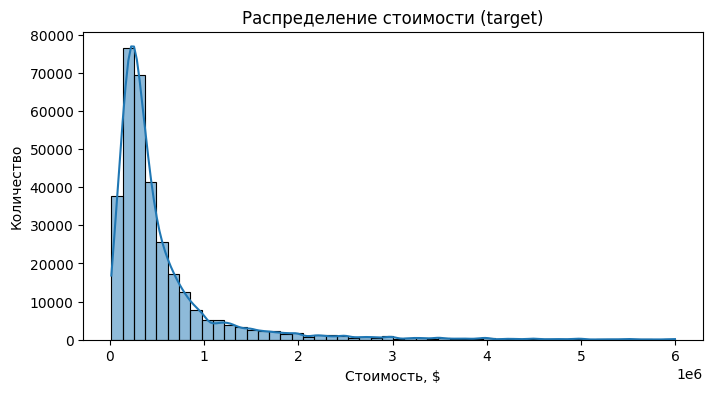

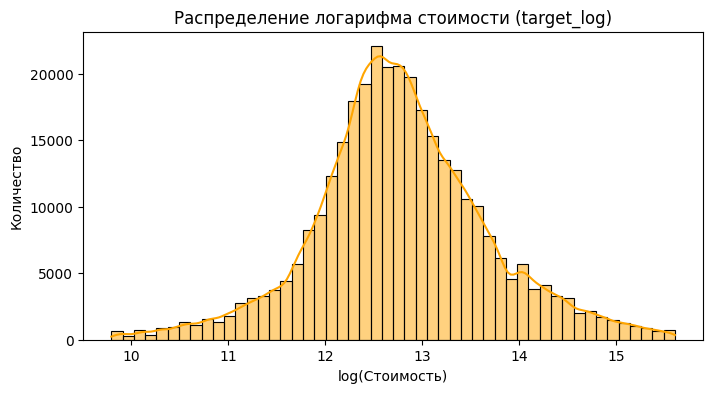

In [184]:
# Гистограмма исходного признака
plt.figure(figsize=(8, 4))
sns.histplot(df['target'], bins=50, kde=True)
plt.title('Распределение стоимости (target)')
plt.xlabel('Стоимость, $')
plt.ylabel('Количество')
plt.show()

# Гистограмма логарифма
plt.figure(figsize=(8, 4))
sns.histplot(df['target_log'], bins=50, kde=True, color='orange')
plt.title('Распределение логарифма стоимости (target_log)')
plt.xlabel('log(Стоимость)')
plt.ylabel('Количество')
plt.show()


>Начнём с анализа распределения исходной стоимости недвижимости (`target`)  
и её логарифма (`target_log`).

>На исходном графике видно, что распределение `target` **сильно скошено вправо** —  
основная масса объектов сосредоточена в диапазоне до $1–2 млн,  
но присутствует длинный хвост, простирающийся вплоть до $140 млн.  
Такие экстремальные значения соответствуют единичным случаям элитной недвижимости  
и статистически представляют **выбросы**.

>После логарифмирования (`target_log`) распределение стало значительно **ближе к симметричному**,  
однако сохраняет лёгкий **левосторонний перекос**.  
Это ожидаемый эффект: правый хвост исходного распределения (дорогие дома)  
при лог-преобразовании «сжимается» и визуально смещается влево.  

>Таким образом:
>- Логарифмирование успешно уменьшило влияние экстремальных значений,  
  сделав признак более пригодным для статистического анализа и моделирования.
>- Несмотря на лёгкую асимметрию, `target_log` можно считать **псевдонормальным распределением**,  
  что является желательным свойством для дальнейших шагов анализа (EDA и регрессии).

Посмотрим распределение непрерывных признаков

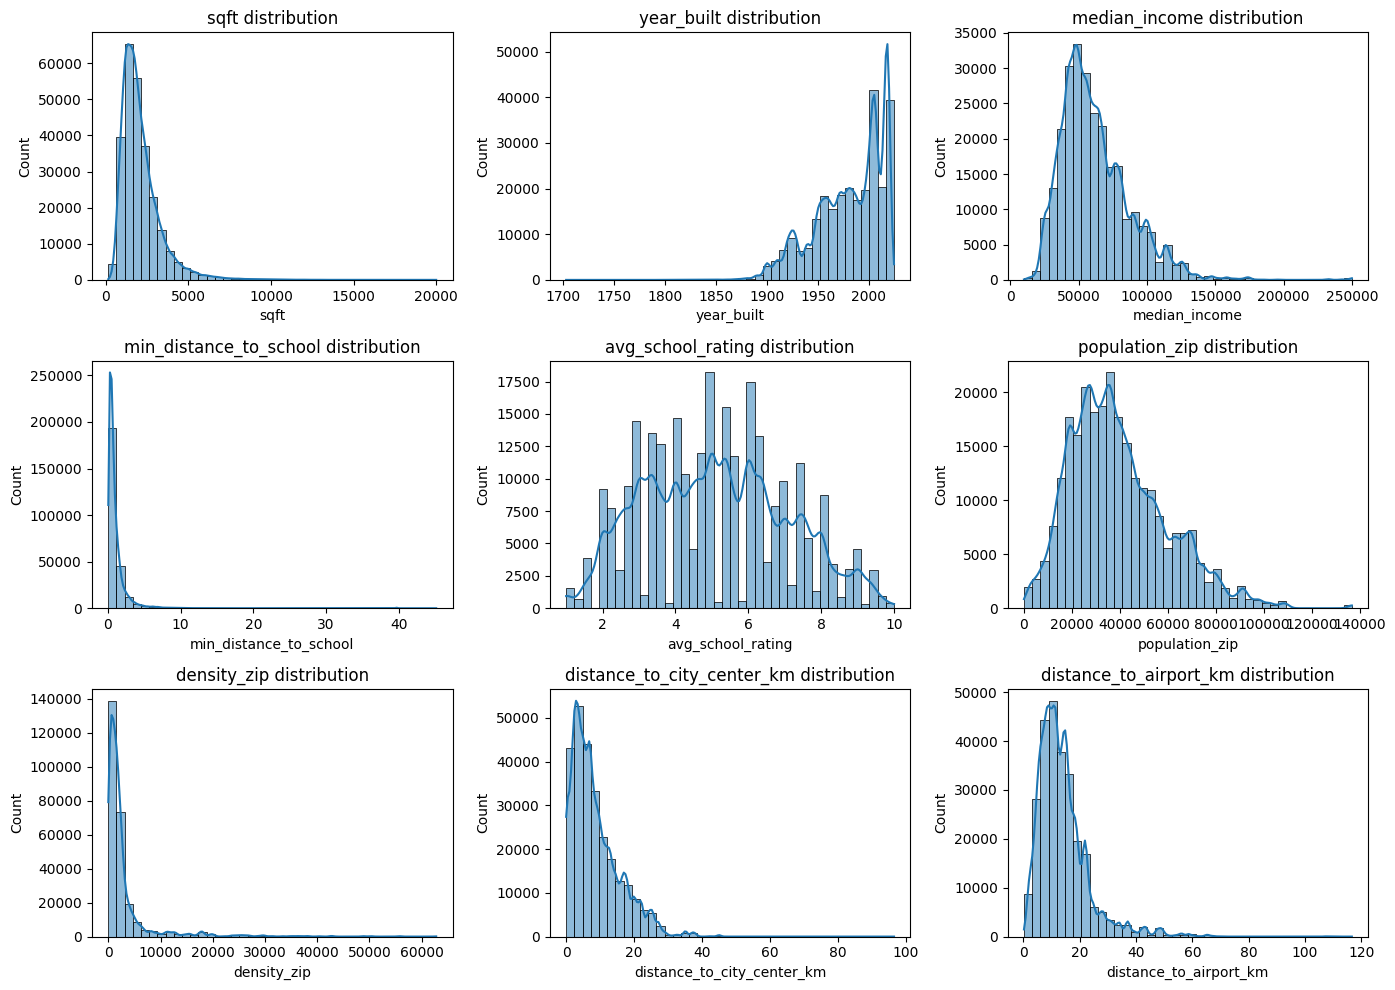

In [185]:
#  Непрерывные признаки
cont_cols = [
    'sqft', 'year_built', 'median_income',
    'min_distance_to_school', 'avg_school_rating',
    'population_zip', 'density_zip',
    'distance_to_city_center_km', 'distance_to_airport_km'
]

# создаём сетку 3x3 для девяти графиков
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))
axes = axes.flatten()

# визуализируем распределения каждого признака
for i, col in enumerate(cont_cols):
    sns.histplot(X_train_filled[col], bins=40, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} distribution')

# компактное размещение графиков
plt.tight_layout()
plt.show()


>- **sqft (площадь дома)** — распределение сильно скошено вправо: большинство объектов имеют площадь до ~3000 кв. футов, но встречаются редкие дома свыше 10 000–20 000 кв. футов. Возможны выбросы.  
>- **year_built (год постройки)** — отчётливо виден рост строительства после 1950-х и всплеск после 2000 года. Это отражает общий тренд активного жилищного строительства последних десятилетий.  
>- **median_income (медианный доход по ZIP)** — распределение близко к логнормальному: основная масса районов имеет доход $40–80 тыс., присутствует хвост в сторону более богатых регионов.  
>- **min_distance_to_school (минимальная дистанция до школы)** — крайне скошено влево: большинство домов расположено менее чем в 2 км от школы, значения свыше 10 км редки и могут быть аномалиями.  
>- **avg_school_rating (средний рейтинг школ)** — распределение умеренно равномерное, с лёгким пиком в районе 4–6. Это говорит о довольно разнообразных условиях качества образования в зонах застройки.  
>- **population_zip (численность населения ZIP-зоны)** — распределение несимметрично, с пиком около 30–50 тыс. человек и длинным правым хвостом, что отражает наличие как малонаселённых, так и густонаселённых районов.  
>- **density_zip (плотность населения)** — также имеет выраженный правый хвост: большинство районов малоплотные, но встречаются урбанизированные зоны с высокой концентрацией населения.  
>- **distance_to_city_center_km (расстояние до центра города)** — резко скошено влево: большинство объектов расположено ближе 20 км к центру, а значения >50 км единичны.  
>- **distance_to_airport_km (расстояние до аэропорта)** — аналогично, пик приходится на 5–15 км, что отражает естественную концентрацию застройки ближе к транспортным узлам.

>В целом, большинство признаков демонстрируют несимметричные распределения с выраженными правыми хвостами.  
Это говорит о высокой неоднородности данных: районы различаются по плотности, инфраструктуре и социально-экономическому профилю.  
Для будущего моделирования стоит рассмотреть логарифмизацию признаков с сильной асимметрией (`sqft`, `min_distance_to_school`, `density_zip`)  
и применение робастного масштабирования перед линейными моделями.

Посмотрим распределение дискретных признаков

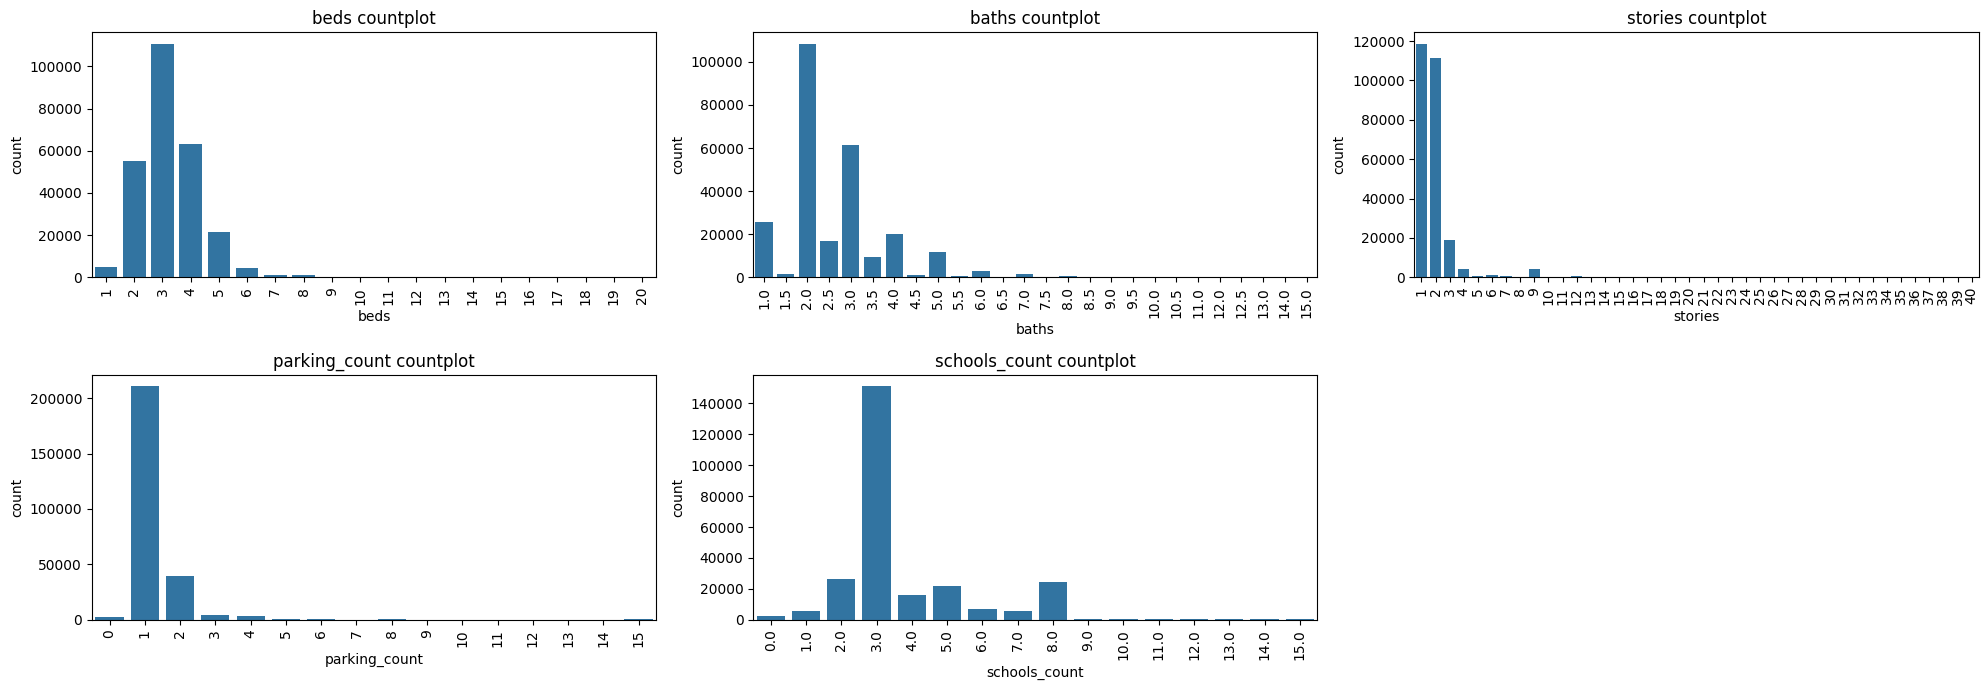

In [186]:
#  Дискретные признаки
disc_cols = ['beds', 'baths', 'stories', 'parking_count', 'schools_count']

# создаём сетку 2x3 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))
axes = axes.flatten()

# визуализируем распределения
for i, col in enumerate(disc_cols):
    sns.countplot(x=X_train_filled[col], ax=axes[i])
    axes[i].set_title(f'{col} countplot')
    axes[i].tick_params(axis='x', rotation=90)  # поворот подписей по оси X для читаемости

# убираем пустой график
for j in range(len(disc_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


>- **beds (кол-во спален)** — основной пик на 2-4 спальнях, редкие случаи свыше 5 указывают на большие частные дома.  
>- **baths (кол-во ванных комнат)** — схожее распределение, чаще встречается 2–3, значения выше 5 — редкость.  
>- **stories (кол-во этажей)** — резко скошено влево: большинство домов одно- или двухэтажные, выше 4 этажей встречаются единично.  
>- **parking_count (число парковочных мест)** — доминирует 1–2 места, более 3 характерно для крупных домов.  
>- **schools_count (количество школ поблизости)** — умеренно скошено влево: чаще 3 школы в радиусе доступности, редкие случаи свыше 10.  

>В целом, дискретные признаки характеризуются компактными распределениями с чётко выраженными модами.  
Это отражает типовую жилую застройку: стандартные дома в 2–3 спальни, 2 ванные и 1–2 парковочных места.  
Выбросы (например, >10 школ или >5 спален) можно проверить дополнительно на аномальность.

Посмотрим долю "1" в бинарных признаках

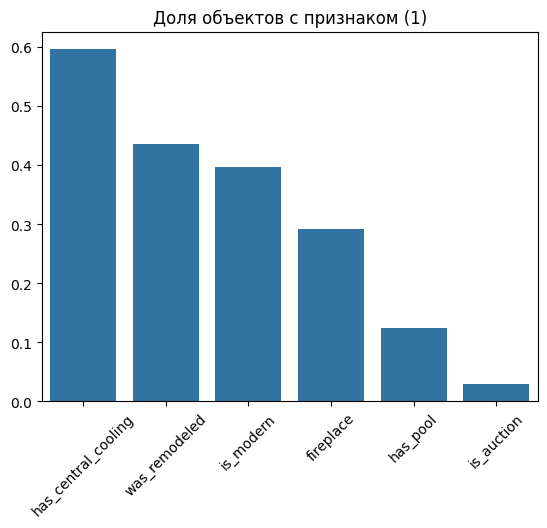

In [187]:
# Бианрные столбцы
bin_cols = ['fireplace', 'has_pool', 'is_auction', 
            'has_central_cooling', 'was_remodeled', 'is_modern']

# Столбчатая диаграмма
sns.barplot(X_train_filled[bin_cols].mean().sort_values(ascending=False))
plt.title("Доля объектов с признаком (1)")
plt.xticks(rotation=45)
plt.show()


>- **has_central_cooling** — наиболее распространённый признак, присутствует примерно у 60% объектов.  
>- **was_remodeled** — около 45% домов подвергались ремонту или обновлению.  
>- **is_modern** — примерно 38% построек можно отнести к современным (после 2000 года).  
>- **fireplace** — камин встречается примерно у 30% домов, что отражает региональные климатические особенности.  
>- **has_pool** — около 13% домов имеют бассейн, что типично для южных штатов.  
>- **is_auction** — крайне редкий случай (около 3%), характерный для отдельных рыночных ситуаций.  

>В целом, большинство бинарных признаков имеют **неравномерное распределение**:  
часть признаков (например, наличие охлаждения или ремонта) распространены широко,  
в то время как бассейны и аукционные продажи — редкие и могут быть индикаторами премиального сегмента.

### Вывод по распределению признаков

>- **Непрерывные признаки** (площадь, доход, расстояния и пр.) имеют преимущественно **скошенные вправо распределения**,  
  что говорит о наличии редких экстремальных значений — крупных домов, удалённых объектов и богатых районов.  
  Это может потребовать нормализации или логарифмирования на этапе подготовки данных.  

>- **Дискретные признаки** (кол-во спален, ванных, этажей, парковочных мест и школ)  
  демонстрируют чётко выраженные пики — типичные значения (например, 3 спальни, 2 ванных, 1–2 парковки).  
  Редкие экстремальные значения (20 спален, 15 парковочных мест) можно рассматривать как выбросы.  

>- **Бинарные признаки** распределены **неравномерно**:  
  такие признаки, как `has_central_cooling` и `was_remodeled`, встречаются часто,  
  тогда как `has_pool` и `is_auction` характерны для ограниченного числа объектов.  
  Это важно учитывать при моделировании — редкие категории могут иметь низкую статистическую значимость.  

>В целом, данные содержат **выраженные скошенности и потенциальные выбросы**,  
  что характерно для реальных данных о недвижимости.  
  На следующем этапе EDA логично перейти к **корреляционному анализу**,  
  чтобы оценить взаимосвязь признаков между собой и с целевой переменной (`target_log`).

Теперь рассмотрим корреляцию признаков с таргетом на **сырых данных (до масштабирования и отбора)**.  Это позволит понять, какие зависимости между признаками и таргетом
присутствуют изначально — до удаления выбросов, логарифмирования и других преобразований. А уже саму корреляцию признак - признак, чтобы выявить мультиколлинеарность, будем рассматривать позже - на очищенных данных

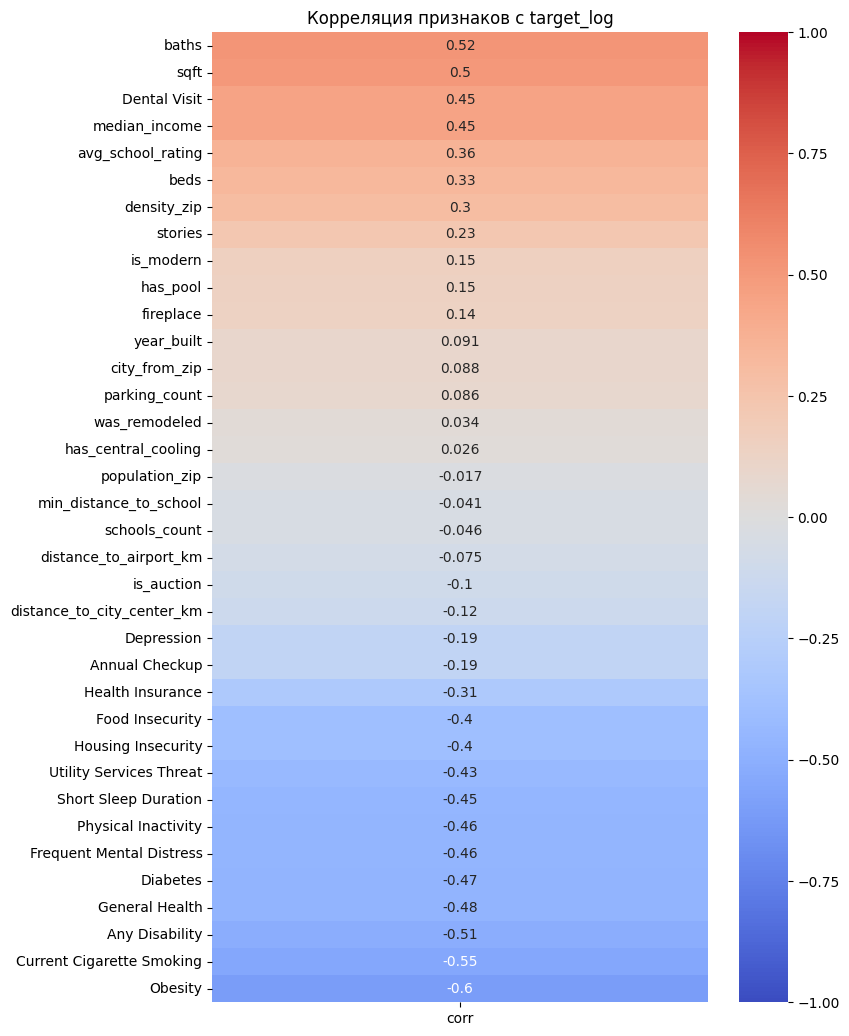

In [188]:
# временно добавляем лог-таргет в train
corr_df = X_train_filled.copy()
corr_df['target_log'] = y_train_log

# считаем полную корреляционную матрицу
corr_matrix = corr_df.corr(numeric_only=True)

# извлекаем корреляции признаков с целевым
corr_with_target = corr_matrix['target_log'].drop('target_log').sort_values(ascending=False)

# визуализируем
plt.figure(figsize=(8, max(4, len(corr_with_target) * 0.35)))
sns.heatmap(corr_with_target.to_frame('corr'),
            annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Корреляция признаков с target_log')
plt.ylabel('')
plt.show()

>- Наиболее сильную положительную связь с ценой показывают baths, sqft, median_income и Dental Visit.
>- Слабая, но логичная связь наблюдается у beds, stories, has_pool, fireplace, is_modern.
>- Медицинские и социальные метрики (Obesity, Diabetes, Physical Inactivity) имеют отрицательную корреляцию с ценой — что указывает на взаимосвязь уровня здоровья и уровня жизни.

>В целом, большинство признаков демонстрируют умеренные или слабые корреляции,
что типично для мультифакторных экономических задач:
модель будет извлекать ценность из сочетания признаков, а не из одного отдельно.




### 4.2 Продвинутый EDA

На этом этапе углубимся в анализ данных, чтобы понять **взаимосвязи между признаками и целевой переменной**.

Сначала рассмотрим признаки с положительной корреляцией с целевой переменной (топ-3 фактора),
далее перейдём к признакам со слабой или близкой к нулю корреляцией,
и в завершение проанализируем признаки с отрицательной корреляцией,
чтобы выявить факторы, снижающие стоимость жилья.

**baths**

Цель: Проверить, влияет ли количество ванных комнат на стоимость жилья.


**Гипотеза H0:** Количество ванных комнат не влияет на стоимость жилья.

**Альтернатива H1:** Увеличение числа ванных комнат приводит к росту стоимости жилья.

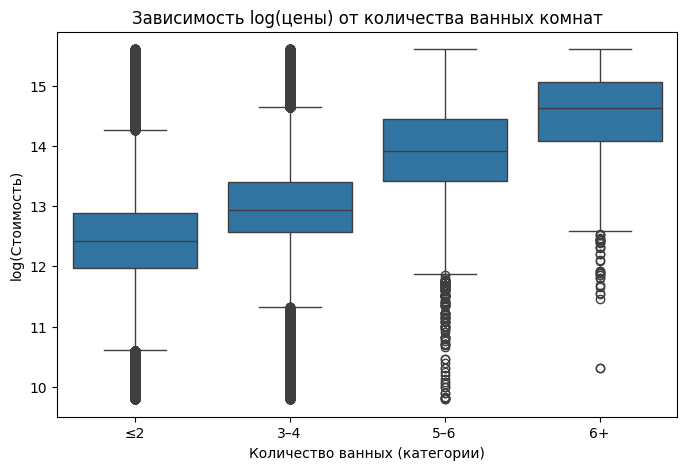

In [189]:
#  Анализ зависимости стоимости от количества ванных комнат (по категориям)
def categorize_baths(x):
    if x <= 2:
        return '≤2'
    elif x <= 4:
        return '3–4'
    elif x <= 6:
        return '5–6'
    else:
        return '6+'

# создаём временную серию категорий (не добавляем в датафрейм)
baths_bins = X_train_filled['baths'].apply(categorize_baths)

# визуализируем распределение цены по категориям ванных
plt.figure(figsize=(8, 5))
sns.boxplot(x=baths_bins, y=y_train_log, order=['≤2', '3–4', '5–6', '6+'])
plt.title('Зависимость log(цены) от количества ванных комнат')
plt.xlabel('Количество ванных (категории)')
plt.ylabel('log(Стоимость)')
plt.show()


>- **Количество ванных комнат (baths)** положительно связано с логарифмом стоимости:  
  по мере увеличения числа ванных комнат медианная цена жилья стабильно растёт.  
>- Переход от категории `≤2` к `3–4` даёт заметный прирост log(цены),  
  а дальнейшее увеличение (`5–6`, `6+`) сопровождается постепенным,  
  но уже менее выраженным ростом стоимости.  
>- Таким образом, эффект **имеет убывающую отдачу** — добавление каждой новой ванной  
  повышает цену, но вклад становится всё меньше после 4–5 комнат.  
>- **Выбросы присутствуют во всех категориях**, особенно в низших (`≤2` и `3–4`),  
  что отражает значительную вариативность — от бюджетных квартир до дорогих домов  
  с тем же количеством ванных, но в разных районах и состояниях.  



Посмотрим как площадь влияет на цену 

**sqft**

Цель: Проверить, существует ли зависимость между площадью дома и его стоимостью.

**Гипотеза H0:** Между площадью дома и ценой нет линейной зависимости.

**Альтернативная H1:** Между площадью и ценой существует положительная зависимость.

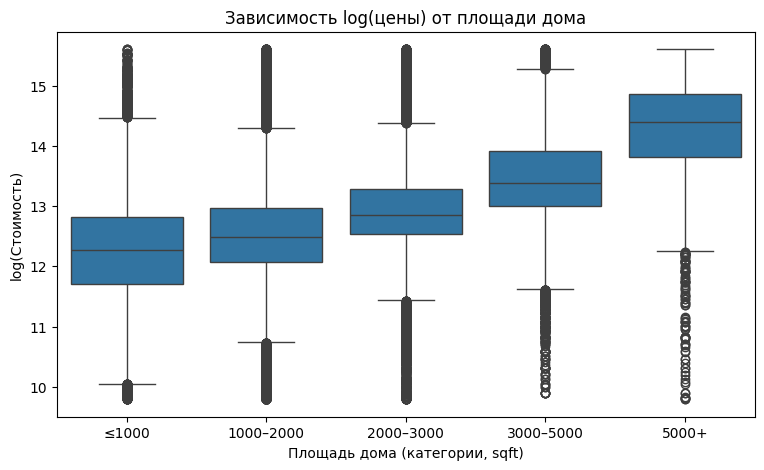

In [190]:
# создаём интервалы 
sqft_bins = pd.cut(
    X_train_filled['sqft'],
    bins=[0, 1000, 2000, 3000, 5000, float('inf')],
    labels=['≤1000', '1000–2000', '2000–3000', '3000–5000', '5000+']
)

# строим boxplot распределения логарифма цены по категориям площади
plt.figure(figsize=(9, 5))
sns.boxplot(x=sqft_bins, y=y_train_log, order=['≤1000', '1000–2000', '2000–3000', '3000–5000', '5000+'])
plt.title('Зависимость log(цены) от площади дома')
plt.xlabel('Площадь дома (категории, sqft)')
plt.ylabel('log(Стоимость)')
plt.show()


>- **Площадь (sqft)** положительно коррелирует с логарифмом стоимости —  
  по мере роста площади медианная цена стабильно увеличивается.  
>- Зависимость близка к **линейной**, без выраженного насыщения:  
  каждый дополнительный сегмент площади вносит схожий прирост в log(цену).  
>- **Выбросы наблюдаются во всех категориях, кроме сегмента 5000+**,  
  где распределение более устойчивое — вероятно, из-за относительной  
  однородности премиального сегмента.  
>- В остальных категориях разброс и наличие экстремальных значений  
  отражают неоднородность рынка: дома с одинаковой площадью  
  могут существенно различаться по локации, состоянию и качеству.  

Посмотрим теперь как медианный доход влияет на цену

**median_income**

Цель: Проверить, влияет ли медианный доход района на стоимость жилья.

**Гипотеза H0:** Медианный доход района не связан со стоимостью жилья.

**Альтернативаня H1:** Более высокий медианный доход связан с ростом стоимости жилья.

In [191]:
# Посмотрим на наш признак, чтобы понять на какие инетрвалы делить 
df.median_income.describe()

count   328,791.00
mean     61,915.53
std      25,499.59
min       9,932.00
25%      44,022.00
50%      56,732.00
75%      75,702.00
max     250,000.00
Name: median_income, dtype: float64

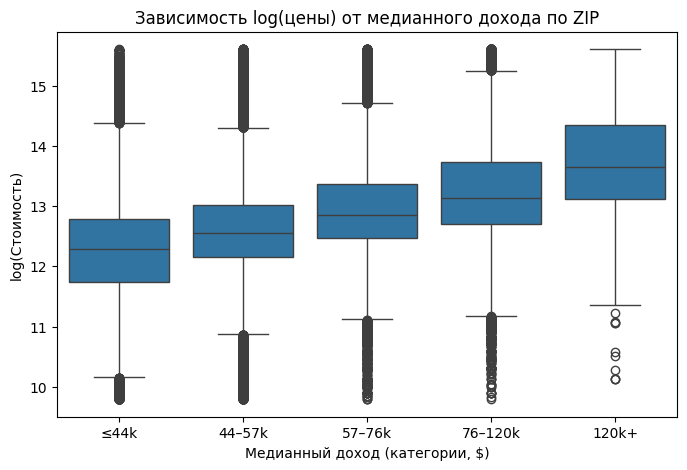

In [192]:
# Разделяем признак с медианным доходом по промежуткам, чтобы можно было посмотреть в разерезе таргета
m_income_bins = pd.cut(
    X_train_filled['median_income'],
    bins=[0, 44000, 57000, 76000, 120000, np.inf],
    labels=['≤44k', '44–57k', '57–76k', '76–120k', '120k+']
)


# Коробчатая диаграмма 
plt.figure(figsize=(8, 5))
sns.boxplot(x=m_income_bins, y=y_train_log)
plt.title('Зависимость log(цены) от медианного дохода по ZIP')
plt.xlabel('Медианный доход (категории, $)')
plt.ylabel('log(Стоимость)')
plt.show()


>— Наблюдается чёткая положительная зависимость между уровнем медианного дохода в ZIP-районе и логарифмом стоимости жилья.

>— При росте дохода с ≤44k до 120k+ медиана log(цены) постепенно увеличивается, что отражает общую закономерность: богатые районы — более дорогие.

>— Выбросы присутствуют во всех категориях, особенно в группах с низким доходом и с высоким доходом

**Признаки со слабой корреляцией**:

**was_remodeled**

Цель: Проверить, влияет ли факт ремонта на стоимость жилья.

**Нулевая гипотеза (H0):**
Наличие ремонта не оказывает влияния на стоимость жилья (средние log(цены) одинаковы для домов с ремонтом и без него).

**Альтернативная гипотеза (H1):**
Дома, которые были отремонтированы, имеют более высокую стоимость, чем дома без ремонта.

**has_central_cooling**

Цель: Проверить, влияет ли наличие центрального охлаждения на цену дома.

**Нулевая гипотеза (H0):**
Наличие центрального охлаждения не влияет на стоимость жилья (средние log(цены) одинаковы для обеих групп).

**Альтернативная гипотеза (H1):**
Дома с центральным охлаждением имеют более высокую стоимость, чем дома без него.

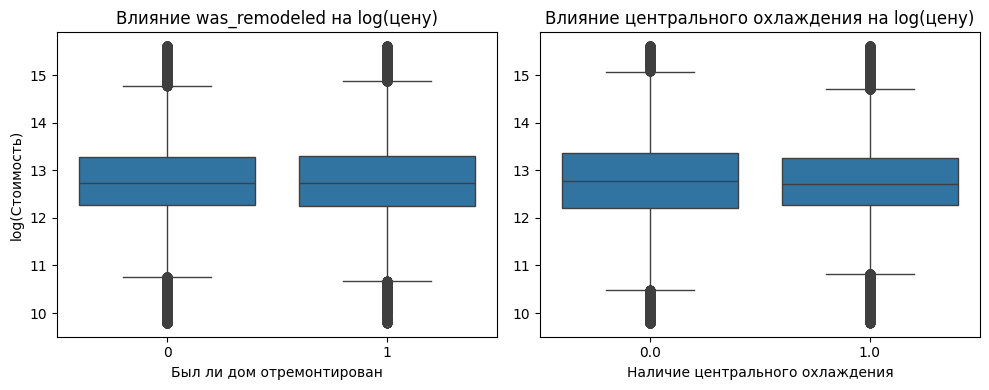

In [193]:
# Фигура с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Первыая коробчатая диаграмма
sns.boxplot(x=X_train_filled['was_remodeled'], y=y_train_log, ax=axes[0])
axes[0].set_title('Влияние was_remodeled на log(цену)')
axes[0].set_xlabel('Был ли дом отремонтирован')
axes[0].set_ylabel('log(Стоимость)')

# Вторая коробчатая диаграмма
sns.boxplot(x=X_train_filled['has_central_cooling'], y=y_train_log, ax=axes[1])
axes[1].set_title('Влияние центрального охлаждения на log(цену)')
axes[1].set_xlabel('Наличие центрального охлаждения')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


>— Наличие ремонта (was_remodeled) и центрального охлаждения (has_central_cooling) связано с незначительным увеличением log(цены) — медиана немного выше по сравнению с домами без этих признаков.
>— Эффект слабо выражен, что согласуется с низкими коэффициентами корреляции (~0.06–0.07).
>— Выбросы присутствуют в обеих категориях, однако не влияют на общий тренд: обновлённые и оснащённые дома всё же имеют чуть более высокую стоимость.

Признаки с отрицательной корреляцией 

**Obesity**

Цель: Проверить, влияет ли уровень ожирения населения в районе на стоимость жилья.

**Гипотеза H0:** Уровень ожирения населения не влияет на стоимость жилья.

**Альтернативная H1:** В районах с высоким уровнем ожирения стоимость жилья ниже.




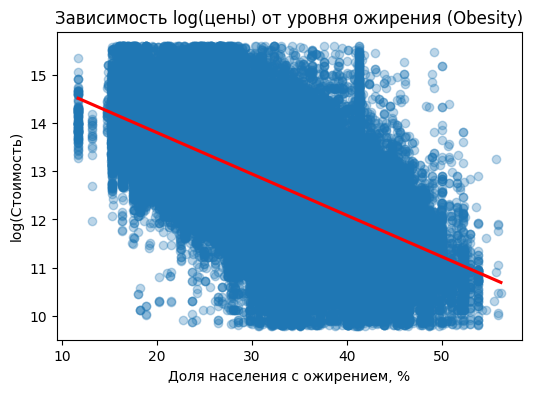

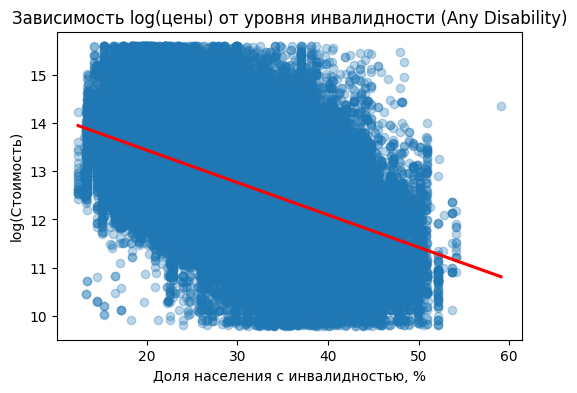

In [194]:
# Размер графика
plt.figure(figsize=(6, 4))
# График regplot
sns.regplot(x=X_train_filled['Obesity'], y=y_train_log, scatter_kws={'alpha':0.3}, line_kws={'color':'red'}) 
plt.title('Зависимость log(цены) от уровня ожирения (Obesity)') # Название
plt.xlabel('Доля населения с ожирением, %') # Название оси Х
plt.ylabel('log(Стоимость)') # Название оси Y
plt.show()

# Размер графика
plt.figure(figsize=(6, 4))
# График regplot
sns.regplot(x=X_train_filled['Any Disability'], y=y_train_log, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Зависимость log(цены) от уровня инвалидности (Any Disability)') # Название
plt.xlabel('Доля населения с инвалидностью, %') # Название оси Х
plt.ylabel('log(Стоимость)') # Название оси Y
plt.show()

>— Obesity (уровень ожирения) — наблюдается отчётливая отрицательная зависимость: с ростом доли людей с ожирением средняя стоимость жилья снижается. Это может отражать социально-экономическое положение регионов с более низким уровнем здоровья населения.
>— Any Disability (наличие инвалидности) — также выражена обратная зависимость: районы с большим процентом людей с ограниченными возможностями характеризуются более низкими ценами на жильё.

>— Линия регрессии подтверждает наличие нисходящего тренда, что согласуется с отрицательной корреляцией (≈ –0.5 … –0.6).
>— Выбросы присутствуют, но не искажают общую тенденцию — даже при них направление зависимости остаётся стабильным.

Посмотрим как зависит цена от города

/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/278057537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


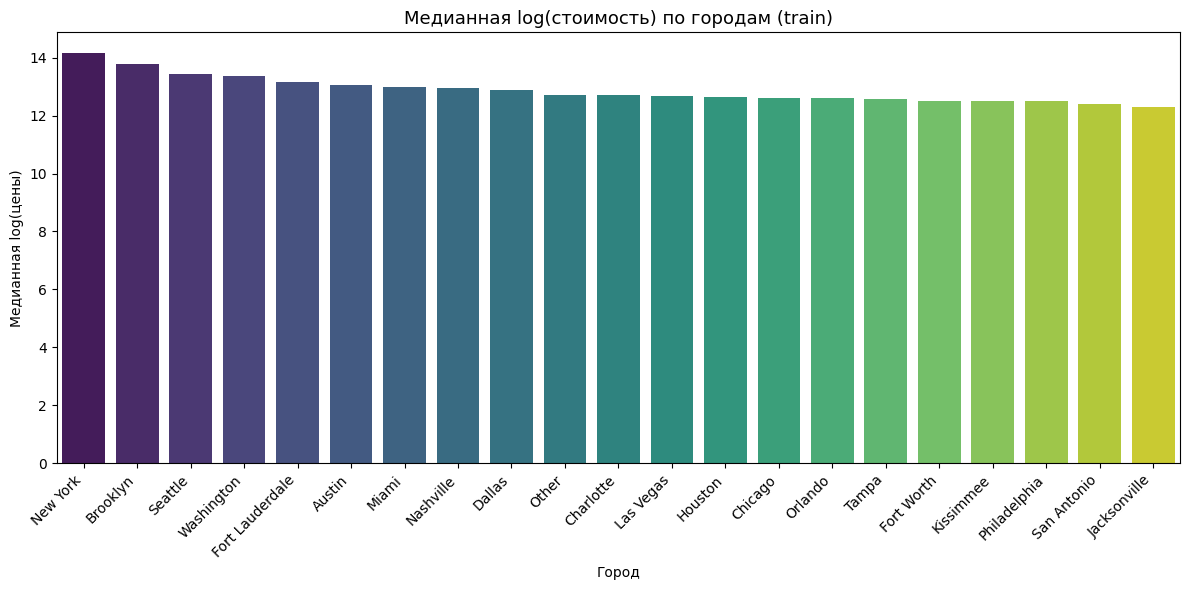

In [195]:
# временно добавляем целевую переменную в обучающую выборку
train_filled = X_train_filled.copy()
train_filled['target_log'] = y_train_log

# группируем по городам и считаем медиану логарифма цены
median_price_by_city = (
    train_filled
    .groupby('city')['target_log']
    .median()
    .sort_values(ascending=False)
)

# визуализируем распределение медианной цены по городам
plt.figure(figsize=(12, 6))
sns.barplot(
    x=median_price_by_city.index,
    y=median_price_by_city.values,
    palette='viridis'
)

# оформляем график
plt.title('Медианная log(стоимость) по городам (train)', fontsize=13)
plt.xlabel('Город')
plt.ylabel('Медианная log(цены)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


>Распределение медианной логарифмированной стоимости по городам достаточно равномерное —
различия между большинством локаций незначительны.
Небольшое преимущество по стоимости наблюдается у крупных мегаполисов
(New York, Los Angeles, Brooklyn), однако в целом фактор “город”
не оказывает выраженного влияния на цену жилья после логарифмирования.
Это может говорить о том, что внутри каждого города присутствует широкий диапазон цен,
и ключевую роль играют локальные характеристики (площадь, состояние, инфраструктура),
а не сам город в целом.

Посмотрим, как площадь дома связана с количеством спален.
Логично предположить, что с ростом площади увеличивается и число комнат,
однако зависимость может быть нелинейной — например, большие дома не всегда имеют больше спален,
так как площадь может распределяться иначе 

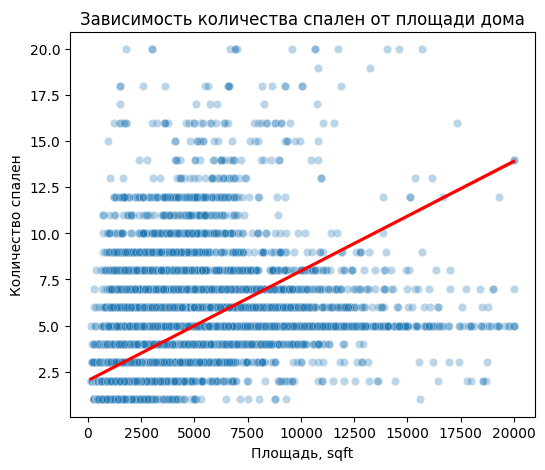

In [196]:
# Размер графика
plt.figure(figsize=(6, 5))

# Точки на графике (каждый объект — дом)
sns.scatterplot(x=X_train_filled['sqft'], y=X_train_filled['beds'], alpha=0.3)

# Добавляем линию линейной регрессии (тренд зависимости)
sns.regplot(x=X_train_filled['sqft'], y=X_train_filled['beds'],
            scatter=False, color='red')

# Заголовок и подписи осей
plt.title('Зависимость количества спален от площади дома')
plt.xlabel('Площадь, sqft')
plt.ylabel('Количество спален')

# Отображаем график
plt.show()

>Наблюдается положительная зависимость между площадью дома и количеством спален — при увеличении sqft число спален в среднем возрастает.
Однако разброс значений достаточно велик, что говорит о нелинейном характере связи:
большие площади не всегда сопровождаются пропорциональным ростом числа комнат
(например, часть площади может приходиться на гостиные, подвалы и т.п.).

Проверим, как уровень медианного дохода в районе связан со средним рейтингом школ.
Логично предположить, что в районах с более высоким доходом населения — школы получают и более высокие оценки,
так как инфраструктура, уровень преподавания и финансирование там, как правило, лучше.

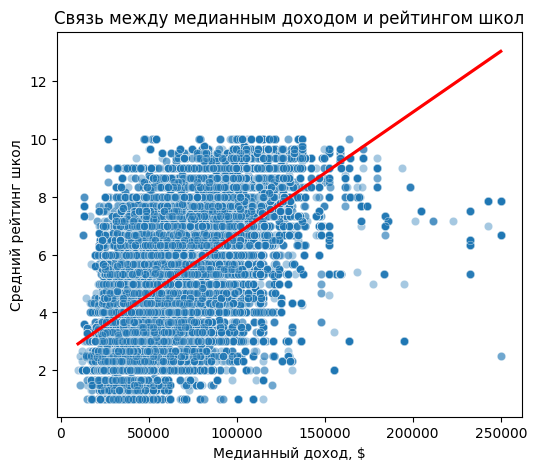

In [197]:
# Размер графика
plt.figure(figsize=(6, 5))

# Отображаем отдельные наблюдения (каждая точка — ZIP-регион)
sns.scatterplot(
    x=X_train_filled['median_income'],
    y=X_train_filled['avg_school_rating'],
    alpha=0.4  # полупрозрачность для наглядности плотности точек
)

# Добавляем линию линейной регрессии (тренд зависимости)
sns.regplot(
    x=X_train_filled['median_income'],
    y=X_train_filled['avg_school_rating'],
    scatter=False, color='red'  # отключаем точки, оставляем только линию
)

# Оформляем подписи и заголовок
plt.title('Связь между медианным доходом и рейтингом школ')
plt.xlabel('Медианный доход, $')
plt.ylabel('Средний рейтинг школ')

# Отображаем график
plt.show()

>Наблюдается чёткая положительная зависимость:
чем выше медианный доход в районе, тем выше средний рейтинг школ.
Это подтверждает, что уровень благосостояния населения влияет на качество образования.
Разброс значений всё же присутствует — вероятно, есть исключения, где школы с высоким рейтингом встречаются и в менее обеспеченных районах.

Посмотрим, как медианная дистанция до центра различается по городам.
Это позволит оценить, где жильё в выборке сосредоточено ближе к центру,
а где — наоборот, преобладают пригородные объекты.

/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/758290437.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_distance_by_city.index, y=median_distance_by_city.values, palette='viridis')


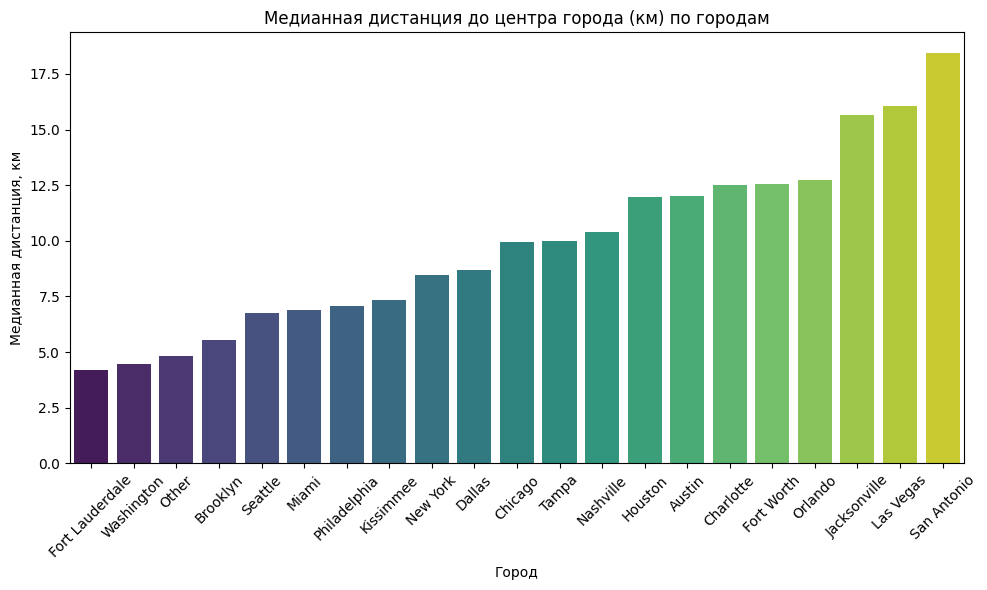

In [198]:
# рассчитываем медианную дистанцию до центра по каждому городу
median_distance_by_city = (
    train_filled.groupby('city')['distance_to_city_center_km']
    .median()
    .sort_values(ascending=True)
)

# визуализируем результаты
plt.figure(figsize=(10, 6))
sns.barplot(x=median_distance_by_city.index, y=median_distance_by_city.values, palette='viridis')

# подписи и оформление
plt.title('Медианная дистанция до центра города (км) по городам')
plt.xlabel('Город')
plt.ylabel('Медианная дистанция, км')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

>Города заметно различаются по удалённости жилья от центра.
Наименьшая медианная дистанция наблюдается в Washington, Brooklyn, Philadelphia —
эти города характеризуются высокой плотностью застройки и компактной городской структурой.

>В то же время такие города, как San Antonio, Las Vegas, Austin и Jacksonville,
имеют наибольшие медианные расстояния — от 14 до 16 км,
что указывает на доминирование пригородной застройки и более растянутую городскую инфраструктуру.

>Таким образом, можно выделить два типа локаций:
— компактные урбанизированные центры (восточное побережье);
— распределённые субурбанизированные города (южные и западные штаты).

Проверим, есть ли связь между возрастом домов (годом постройки)
и долей населения, страдающего от депрессии по ZIP-коду.

**Гипотеза:**
- в старых районах (дома до 1980-х) условия проживания хуже, инфраструктура изношена — возможен более высокий уровень депрессии;

- в новых районах (после 2000-х) — комфортнее, экологичнее, с развитой социальной средой, уровень депрессии ниже.

посмотрим взаимосвязь между годом постройки и уровнем депрессии


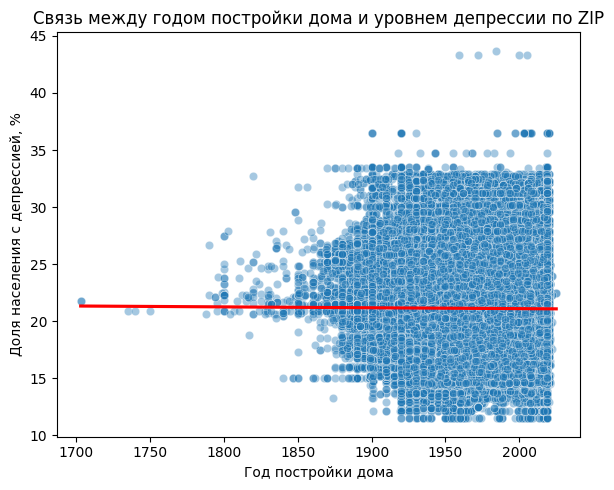

In [199]:
plt.figure(figsize=(6, 5))

# диаграмма рассеяния с трендовой линией
sns.scatterplot(
    x=X_train_filled['year_built'],
    y=X_train_filled['Depression'],
    alpha=0.4
)

# добавим линию тренда
sns.regplot(
    x=X_train_filled['year_built'],
    y=X_train_filled['Depression'],
    scatter=False,
    color='red'
)

# оформление
plt.title('Связь между годом постройки дома и уровнем депрессии по ZIP')
plt.xlabel('Год постройки дома')
plt.ylabel('Доля населения с депрессией, %')
plt.tight_layout()
plt.show()

>На графике не наблюдается выраженной зависимости между годом постройки домов и уровнем депрессии населения.
Линия тренда остаётся почти горизонтальной, что говорит об отсутствии прямой корреляции между возрастом жилья и этим социальным показателем.

>Вероятно, уровень депрессии определяется другими социально-экономическими факторами (доход, доступность медицины, образование),
а не временем постройки домов.

Далее проведём анализ выбросов для количественных признаков, которые потенциально могут искажать статистику и влиять на модель: площадь (sqft), количество спален и ванных комнат, а также социально-экономические показатели (median_income, distance_to_city_center).

Выбросы будут определяться по методу межквартильного размаха (IQR), а также визуализированы с помощью boxplot.

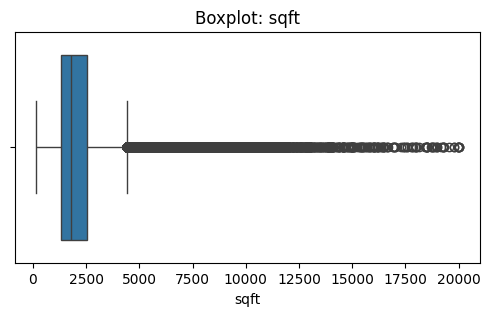

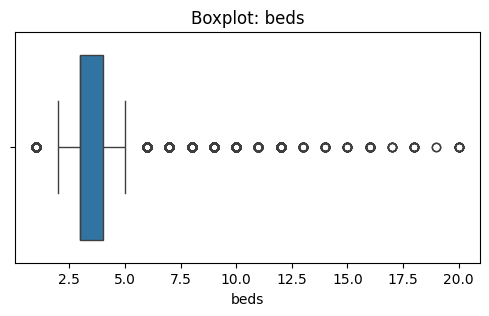

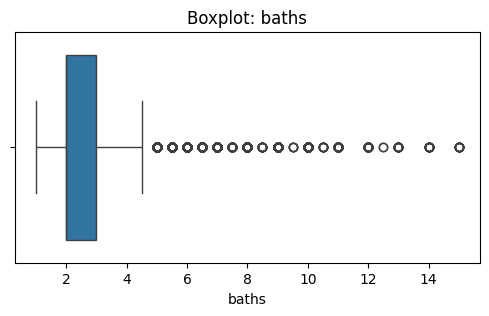

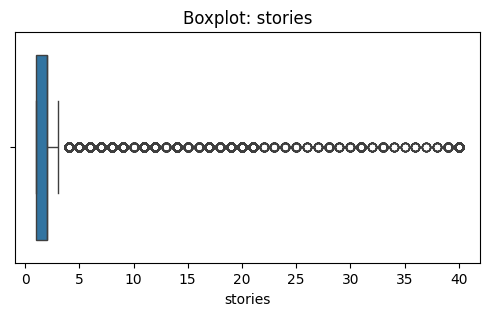

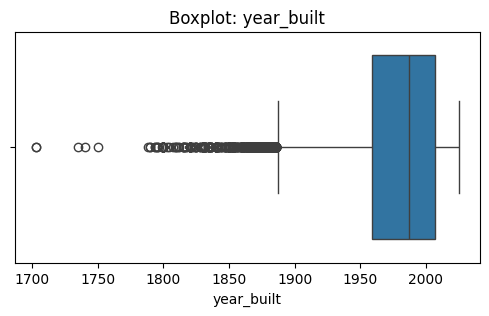

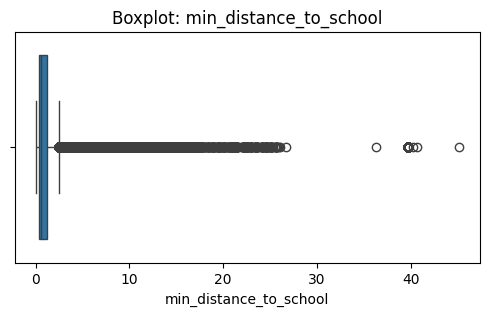

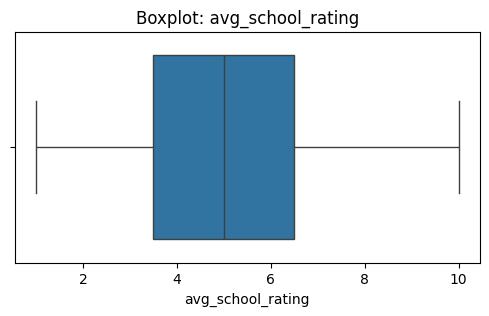

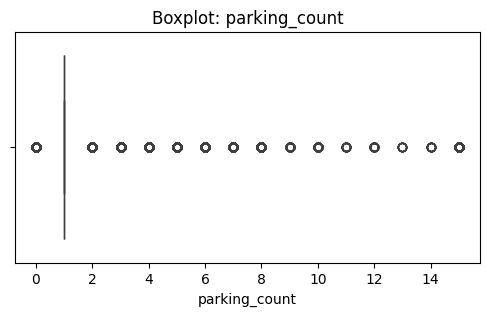

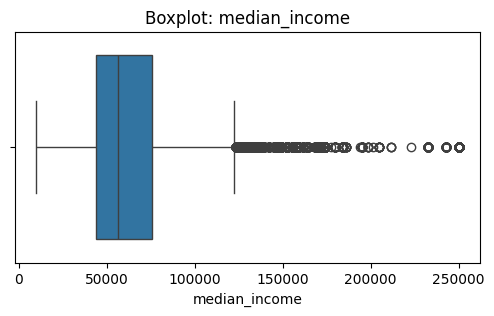

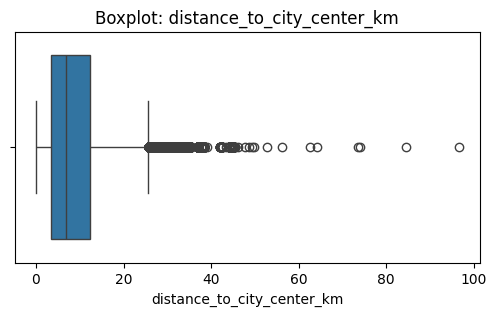

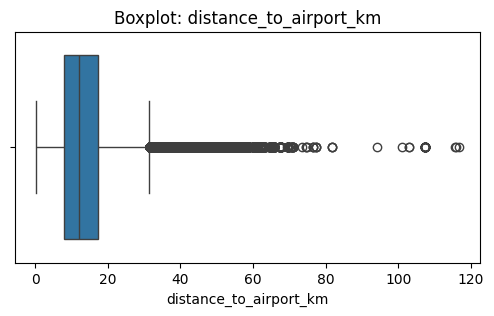

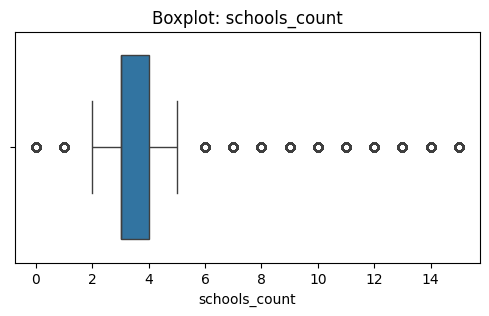

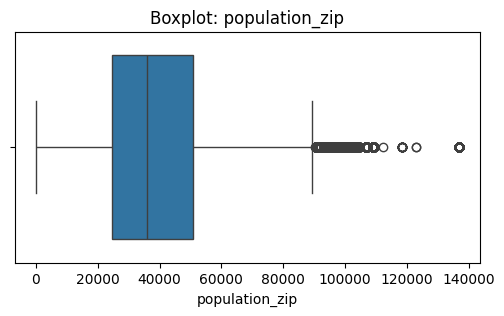

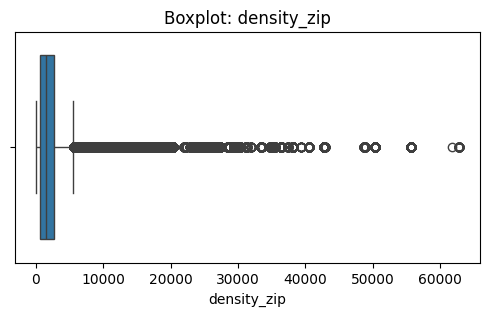

In [200]:
# Столбцы, которые будем анализировать на выбросы
num_features_outlier = [
    'sqft', 'beds', 'baths', 'stories',
    'year_built', 'min_distance_to_school', 'avg_school_rating',
    'parking_count', 'median_income',
    'distance_to_city_center_km', 'distance_to_airport_km',
    'schools_count', 'population_zip', 'density_zip'
]

# Проходимся по каждому столбцу проходимся и строим коробчатую диаграмму
for col in num_features_outlier:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=X_train_filled[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

>Краткий вывод по выбросам

1) sqft — заметен длинный правый хвост, редкие большие дома встречаются часто.
Применить логарифмирование, при необходимости — обрезка верхних 1–2%.
	
2) beds / baths — основная масса 2–5 и 1–4 соответственно, присутствуют экстремальные значения (до 10+).
Ограничить сверху (кап до 8–10) или применить IQR-обрезку.
	
3) stories — преобладают дома с 1–2 этажами, редкие >4.
Кап до 4.
	
4) year_built — большинство домов построено после 1950 года, редкие старые объекты допустимы.
Без изменений.
	
5) min_distance_to_school — распределение сильно скошено вправо, большинство домов расположено ближе 5 км к школам.
Применить логарифмирование или обрезку верхних значений.
	
6) avg_school_rating — значения компактны в диапазоне 1–10.
Оставить без изменений.
	
7) parking_count — основная масса 1–3, выбросы при >10.
Кап до 6–8.
	
8) median_income — правый хвост, отражает различия между регионами.
Применить логарифмирование.
	
9) distance_to_city_center_km / distance_to_airport_km — длинные правые хвосты.
Логарифмирование или обрезка верхних 1–2%.
	
10) schools_count — обычно 2-5, редкие >20.
Кап до 20 или IQR-обрезка.
	
11) population_zip / density_zip — выраженная асимметрия, отражающая различие между городом и пригородом.
Применить логарифмирование, без удаления.


Причины выбора разных методов обработки выбросов

Для разных признаков применены два подхода к работе с выбросами, исходя из их природы:

Логарифмирование (np.log1p) — использовано для непрерывных признаков
с длинным правым хвостом (sqft, median_income, distance_to_city_center_km, distance_to_airport_km и др.).
Это снижает влияние экстремальных значений, сохраняя при этом относительные различия между объектами.

Обрезка (ручные пороги) — применена к дискретным, счётным признакам
(beds, baths, stories, parking_count, schools_count),
где физически невозможно большое число (например, 20 спален или 15 парковок).
Здесь логарифм не имеет смысла, а удаление по квантилям даёт стабильный и интерпретируемый диапазон.

In [201]:
for col in ['sqft', 'median_income']:
    median_val = X_train_filled[col].median()   # считаем медиану только на train
    X_test_filled[col].fillna(median_val, inplace=True)  # применяем то же значение

/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/2773358407.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_filled[col].fillna(median_val, inplace=True)  # применяем то же значение
/var/folders/8z/j62qqp0n6sjdzf2ht_njv39r0000gn/T/ipykernel_16112/2773358407.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [202]:
# Непрерывные признаки
continuous_cols = [
    'sqft', 'median_income', 
    'distance_to_city_center_km', 'distance_to_airport_km',
    'population_zip', 'density_zip'
]

# Каждый непрерывный признак логорифмируем
for col in continuous_cols:
    X_train_filled[col] = np.log1p(X_train_filled[col])
    X_test_filled[col]  = np.log1p(X_test_filled[col]) 

In [203]:
print(f'Строк до удаления выбросов: {X_train_filled.shape}')

# Фильтруем матрциу признаков
X_train_filled = X_train_filled[
    (X_train_filled['beds'] <= 10) &
    (X_train_filled['baths'] <= 8) &
    (X_train_filled['stories'] <= 4) &
    (X_train_filled['parking_count'] <= 8) &
    (X_train_filled['schools_count'] <= 20)
].copy()

# Фильтруем и таргет тоже
y_train_log = y_train_log.loc[X_train_filled.index]
y_train = y_train.loc[X_train_filled.index]
print(f'Строк после удаления выбросов: {X_train_filled.shape}')

Строк до удаления выбросов: (263043, 39)
Строк после удаления выбросов: (251131, 39)


**Вывод по очистке выбросов**

В результате очистки и фильтрации:

- удалено в среднем ≈5 % строк (около 13 тыс. объектов на признак);

- выбросы устранены в ключевых дискретных признаках (beds, baths, stories, parking_count, schools_count);

- непрерывные признаки стабилизированы логарифмированием.

Итоговый размер данных после очистки: (245 736, 39)

Доля удалённых строк находится в пределах статистической нормы,
данные считаются сбалансированными и готовы для корреляционного и статистического анализа.

На следующем этапе проведём анализ корреляций между признаками,
чтобы выявить сильные взаимосвязи (мультиколлинеарность) и определить,
есть ли признаки, дублирующие друг друга.

Такая проверка помогает:

- лучше понять структуру данных,

- избежать переобучения модели,

- и оставить только информативные признаки.

Для этого построим матрицу корреляций и визуализируем её в виде тепловой карты,
а также выделим пары признаков с высоким уровнем зависимости (|corr| > 0.8).

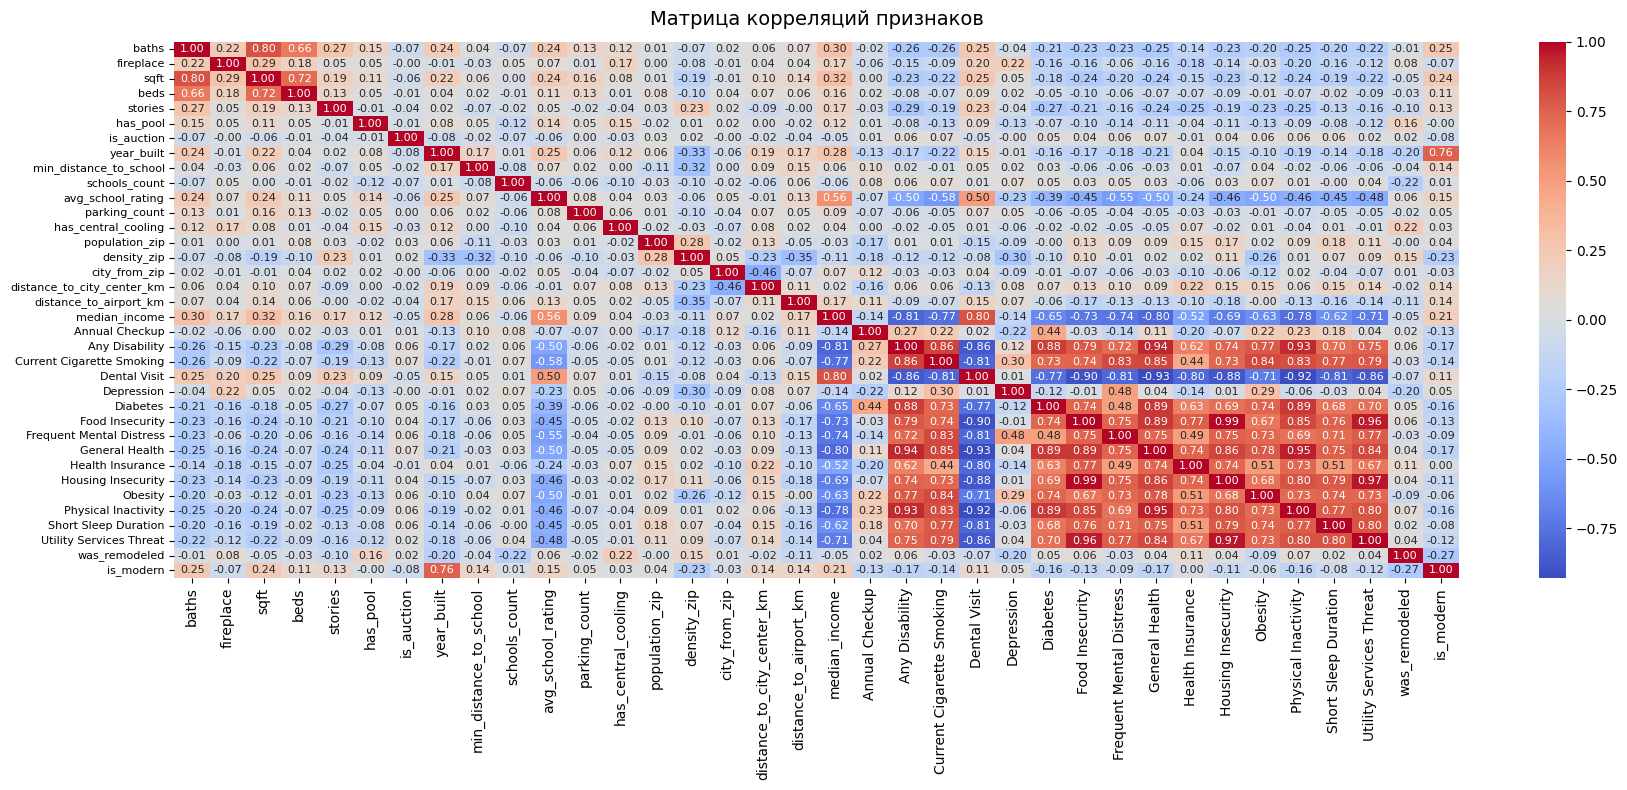

In [204]:
# Матрица корреляций для числовых признаков
corr_matrix = X_train_filled.corr(numeric_only=True)

plt.figure(figsize=(18, 8))
sns.heatmap(
    corr_matrix,
    annot=True,          # показываем значения корреляций
    fmt=".2f",           # формат чисел
    cmap='coolwarm',     # цветовая схема
    cbar=True,           # цветовая шкала справа
    annot_kws={'size': 8}  # размер текста чисел внутри клеток
)

# Параметры графика
plt.title('Матрица корреляций признаков', fontsize=14, pad=12)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [205]:
# Найдём сильно коррелирующие пары признаков
corr_matrix = X_train_filled.corr(numeric_only=True).abs()

# Создаем список значений 
high_corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.8
]

# УБираем дубликаты и сортируем 
high_corr_pairs = sorted(set(tuple(sorted([a, b]) + [r]) for a, b, r in high_corr_pairs), key=lambda x: -x[2])
pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

,Feature 1,Feature 2,Correlation
0,Food Insecurity,Housing Insecurity,0.99
1,Housing Insecurity,Utility Services Threat,0.97
2,Food Insecurity,Utility Services Threat,0.96
3,General Health,Physical Inactivity,0.95
4,Any Disability,General Health,0.94
5,Any Disability,Physical Inactivity,0.93
6,Dental Visit,General Health,0.93
7,Dental Visit,Physical Inactivity,0.92
8,Dental Visit,Food Insecurity,0.90
9,Diabetes,Physical Inactivity,0.89


После анализа матрицы корреляций и визуального EDA были выявлены признаки,
дублирующие информацию друг друга или не добавляющие значимой предсказательной силы.

Среди медицинских показателей наблюдается сильная взаимная корреляция (|r| > 0.8),
что указывает на то, что они описывают один и тот же фактор —
общее состояние здоровья населения.
На этапе подготовки данных для моделирования планируется оставить
только интегральный показатель General Health,
а остальные связанные признаки будут удалены.

Также отмечены сильные зависимости между:

- beds и sqft — оба признака описывают размер дома,
однако sqft является более точной количественной характеристикой;

- is_modern и year_built — первый является производным от второго
и не несёт новой информации.

В дальнейшем эти избыточные признаки будут исключены
в рамках блока Feature Selection & Preprocessing,
чтобы устранить мультиколлинеарность и повысить устойчивость модели.

### 4.3 Статистический анализ

Наши гипотезы:
1. Площадь дома (sqft)
	
	•	H₀: Между площадью дома и ценой нет линейной зависимости.
	
	•	H₁: Между площадью дома и ценой существует положительная зависимость.

Проверка: коэффициент корреляции Пирсона или Спирмена (для двух количественных признаков).

2. Медианный доход района (median_income)
	
	•	H₀: Медианный доход района не связан со стоимостью жилья.
	
	•	H₁: Более высокий доход связан с ростом стоимости жилья.

Проверка: также корреляция Пирсона или Спирмена (оба признака количественные).

3. Количество ванных комнат (baths)
	
	•	H₀: Количество ванных комнат не влияет на стоимость жилья.
	
	•	H₁: Увеличение числа ванных комнат приводит к росту стоимости жилья.

Проверка: ANOVA (если бины категориальные) или Пирсон (если количественный).

4. Ожирение (Obesity)
	
	•	H₀: Доля населения с ожирением не влияет на стоимость жилья.
	
	•	H₁: Более высокий уровень ожирения связан со снижением стоимости жилья.

Проверка: Пирсон или Спирмен (если распределение не нормальное).

5. Общее здоровье (General Health) — отрицательная корреляция
	
	•	H₀: Оценка здоровья населения не связана с ценой жилья.
	
	•	H₁: Более высокий уровень здоровья связан с более высокой стоимостью жилья.

Проверка: Спирмен (для порядковых данных).

Проверим первую гипотезу. Тест D’Agostino–Pearson, так как данных очень много (> 5000 наблюдений)

In [206]:
# площадь дома
stat_sqft, p_sqft = normaltest(X_train_filled['sqft'])
print(f"sqft: p-value = {p_sqft:.3e} → {'близко к нормальному' if p_sqft > 0.05 else 'не нормально'}")

# логарифм цены
stat_y, p_y = normaltest(y_train_log)
print(f"target_log: p-value = {p_y:.3e} → {'близко к нормальному' if p_y > 0.05 else 'не нормально'}")

print("\nИнтерпретация:")
print("Если хотя бы одно распределение не является нормальным (p ≤ 0.05),")
print("то используем корреляцию Спирмена вместо Пирсона.")

# Проверим гипотезу о связи между площадью и логарифмом цены
# Используем корреляцию Спирмена, т.к. распределения не нормальные
corr, p_value = spearmanr(X_train_filled['sqft'], y_train_log)

print(f"p-value: {p_value:.3e}")

# Автоматическая интерпретация результата
if p_value <= 0.05:
    print("\nЗависимость статистически значима.")
    if corr > 0:
        print("Положительная связь: с ростом площади увеличивается стоимость жилья.")
    else:
        print("Отрицательная связь: с ростом площади стоимость снижается.")

sqft: p-value = 0.000e+00 → не нормально
target_log: p-value = 0.000e+00 → не нормально

Интерпретация:
Если хотя бы одно распределение не является нормальным (p ≤ 0.05),
то используем корреляцию Спирмена вместо Пирсона.
p-value: 0.000e+00

Зависимость статистически значима.
Положительная связь: с ростом площади увеличивается стоимость жилья.


Проверим гипотезу: влияет ли медианный доход района на стоимость жилья


In [207]:
# Проверка нормальности распределений
stat_income, p_income = normaltest(X_train_filled['median_income'])
print(f"median_income: p-value = {p_income:.3e} → {'близко к нормальному' if p_income > 0.05 else 'не нормально'}")

stat_y, p_y = normaltest(y_train_log)
print(f"target_log: p-value = {p_y:.3e} → {'близко к нормальному' if p_y > 0.05 else 'не нормально'}")

print("\nИнтерпретация:")
print("Если хотя бы одно распределение не является нормальным (p ≤ 0.05),")
print("то используем корреляцию Спирмена вместо Пирсона.")

# Проверяем гипотезу о связи между доходом и ценой
corr, p_value = spearmanr(X_train_filled['median_income'], y_train_log)

print(f"p-value: {p_value:.3e}")

# Автоматическая интерпретация результата
if p_value <= 0.05:
    print("\nЗависимость статистически значима.")
    if corr > 0:
        print("Положительная связь: более высокий медианный доход связан с ростом стоимости жилья.")
    else:
        print("Отрицательная связь: более высокий доход связан с уменьшением стоимости.")
else:
    print("\nНет статистически значимой зависимости между доходом и ценой.")

median_income: p-value = 4.669e-14 → не нормально
target_log: p-value = 0.000e+00 → не нормально

Интерпретация:
Если хотя бы одно распределение не является нормальным (p ≤ 0.05),
то используем корреляцию Спирмена вместо Пирсона.
p-value: 0.000e+00

Зависимость статистически значима.
Положительная связь: более высокий медианный доход связан с ростом стоимости жилья.


 Проверим гипотезу: влияет ли количество ванных комнат на стоимость жилья


In [208]:
# Проверка нормальности распределений
stat_baths, p_baths = normaltest(X_train_filled['baths'])
print(f"baths: p-value = {p_baths:.3e} → {'близко к нормальному' if p_baths > 0.05 else 'не нормально'}")

stat_y, p_y = normaltest(y_train_log)
print(f"target_log: p-value = {p_y:.3e} → {'близко к нормальному' if p_y > 0.05 else 'не нормально'}")

print("\nИнтерпретация:")
print("Если хотя бы одно распределение не является нормальным (p ≤ 0.05), используем непараметрические тесты (Спирмен).")
print("Если оба распределения близки к нормальным — можно применить ANOVA или Пирсона.\n")

# Выбор теста в зависимости от нормальности распределений
if p_baths > 0.05 and p_y > 0.05:
    # Данные нормальны — можно использовать ANOVA
    print("Оба распределения близки к нормальному → используем ANOVA.")
    
    # Преобразуем baths в категории (например, 1, 2, 3, 4+)
    X_train_filled['baths_bin'] = X_train_filled['baths'].clip(upper=4)
    groups = [y_train_log[X_train_filled['baths_bin'] == val] for val in sorted(X_train_filled['baths_bin'].unique())]
    
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA: p-value = {p_value:.3e}")
    
else:
    # Распределения не нормальны → используем Спирмена
    print("Распределения не нормальны → используем корреляцию Спирмена.")
    
    corr, p_value = spearmanr(X_train_filled['baths'], y_train_log)
    print(f"Spearman: p-value = {p_value:.3e}")

# Интерпретация результата
if p_value <= 0.05:
    print("\nЗависимость статистически значима.")
    print("Положительная связь: с ростом числа ванных комнат увеличивается стоимость жилья.")
else:
    print("\nНет статистически значимой зависимости между количеством ванных комнат и ценой.")

baths: p-value = 0.000e+00 → не нормально
target_log: p-value = 0.000e+00 → не нормально

Интерпретация:
Если хотя бы одно распределение не является нормальным (p ≤ 0.05), используем непараметрические тесты (Спирмен).
Если оба распределения близки к нормальным — можно применить ANOVA или Пирсона.

Распределения не нормальны → используем корреляцию Спирмена.
Spearman: p-value = 0.000e+00

Зависимость статистически значима.
Положительная связь: с ростом числа ванных комнат увеличивается стоимость жилья.


Проверим гипотезу: влияет ли уровень ожирения (Obesity) на стоимость жилья


In [209]:
# Проверяем нормальность распределений
stat_ob, p_ob = normaltest(X_train_filled['Obesity'])
print(f"Obesity: p-value = {p_ob:.3e} → {'близко к нормальному' if p_ob > 0.05 else 'не нормально'}")

stat_y, p_y = normaltest(y_train_log)
print(f"target_log: p-value = {p_y:.3e} → {'близко к нормальному' if p_y > 0.05 else 'не нормально'}")

print("\nИнтерпретация:")
print("Если хотя бы одно распределение не является нормальным (p ≤ 0.05), используем корреляцию Спирмена.")
print("Если оба распределения нормальные — используем корреляцию Пирсона.\n")

# Выбор теста в зависимости от нормальности распределений
if p_ob > 0.05 and p_y > 0.05:
    print("Оба распределения близки к нормальному → используем Пирсона.")
    corr, p_value = pearsonr(X_train_filled['Obesity'], y_train_log)
else:
    print("Распределения не нормальны → используем Спирмена.")
    corr, p_value = spearmanr(X_train_filled['Obesity'], y_train_log)

# Вывод результата
print(f"\nКоэффициент корреляции: {corr:.3f}")
print(f"p-value: {p_value:.3e}")

# Интерпретация результата
if p_value <= 0.05:
    print("\nЗависимость статистически значима.")
    if corr < 0:
        print("Отрицательная связь: более высокий уровень ожирения связан со снижением стоимости жилья.")
    else:
        print("Положительная связь: более высокий уровень ожирения связан с ростом стоимости жилья.")
else:
    print("\nНет статистически значимой зависимости между уровнем ожирения и ценой жилья.")

Obesity: p-value = 0.000e+00 → не нормально
target_log: p-value = 0.000e+00 → не нормально

Интерпретация:
Если хотя бы одно распределение не является нормальным (p ≤ 0.05), используем корреляцию Спирмена.
Если оба распределения нормальные — используем корреляцию Пирсона.

Распределения не нормальны → используем Спирмена.

Коэффициент корреляции: -0.596
p-value: 0.000e+00

Зависимость статистически значима.
Отрицательная связь: более высокий уровень ожирения связан со снижением стоимости жилья.


Проверим гипотезу: влияет ли уровень общего здоровья населения (General Health) на стоимость жилья


In [210]:
# Проверяем нормальность распределений
stat_gh, p_gh = normaltest(X_train_filled['General Health'])
print(f"General Health: p-value = {p_gh:.3e} → {'близко к нормальному' if p_gh > 0.05 else 'не нормально'}")

stat_y, p_y = normaltest(y_train_log)
print(f"target_log: p-value = {p_y:.3e} → {'близко к нормальному' if p_y > 0.05 else 'не нормально'}")

print("\nИнтерпретация:")
print("Признак порядковый и распределения не нормальные — используем корреляцию Спирмена.")

# Используем корреляцию Спирмена
corr, p_value = spearmanr(X_train_filled['General Health'], y_train_log)

# Вывод результата
print(f"\nКоэффициент корреляции: {corr:.3f}")
print(f"p-value: {p_value:.3e}")

# Интерпретация результата
if p_value <= 0.05:
    print("\nЗависимость статистически значима.")
    if corr > 0:
        print("Положительная связь: лучшее здоровье населения связано с более высокой стоимостью жилья.")
    else:
        print("Отрицательная связь: ухудшение здоровья населения связано со снижением стоимости жилья.")
else:
    print("\nНет статистически значимой зависимости между уровнем здоровья и ценой жилья.")

General Health: p-value = 0.000e+00 → не нормально
target_log: p-value = 0.000e+00 → не нормально

Интерпретация:
Признак порядковый и распределения не нормальные — используем корреляцию Спирмена.

Коэффициент корреляции: -0.482
p-value: 0.000e+00

Зависимость статистически значима.
Отрицательная связь: ухудшение здоровья населения связано со снижением стоимости жилья.


**Интерпретация результатов по направлению связей**
	
- Признаки sqft, median_income, baths, General Health демонстрируют положительную зависимость —
при их росте стоимость жилья увеличивается.
	
- Признаки Obesity и частично Any Disability
показывают отрицательную зависимость —
рост доли населения с хроническими проблемами здоровья
связан со снижением средней стоимости недвижимости.

Вывод:
Как положительные, так и отрицательные корреляции являются статистически значимыми,
и обе категории признаков несут важную интерпретационную ценность для модели —
первая описывает факторы, повышающие стоимость, вторая — факторы, ограничивающие рост цен.

## 5. Подготовка данных для моделирования (Feature Selection & Preprocessing)


На данном этапе производится отбор наиболее значимых признаков
и удаление избыточных, сильно коррелирующих между собой.
После этого данные подготавливаются к обучению моделей
с помощью масштабирования и кодирования категориальных переменных.

In [211]:
# признаки, которые удаляем
drop_cols = [
    'Obesity', 'Diabetes', 'Physical Inactivity', 'Frequent Mental Distress',
    'Depression', 'Any Disability', 'Health Insurance', 'Food Insecurity',
    'Short Sleep Duration', 'Utility Services Threat', 'Housing Insecurity',
    'Current Cigarette Smoking', 'Annual Checkup',
    'beds', 'is_modern'
]

# удаляем из обоих наборов
X_train_filled = X_train_filled.drop(columns=drop_cols, errors='ignore')
X_test_filled = X_test_filled.drop(columns=drop_cols, errors='ignore')

In [212]:
X_train_filled.columns.tolist()

['propertyType',
 'baths',
 'fireplace',
 'city',
 'sqft',
 'state',
 'stories',
 'has_pool',
 'is_auction',
 'year_built',
 'min_distance_to_school',
 'schools_count',
 'avg_school_rating',
 'parking_count',
 'has_central_cooling',
 'population_zip',
 'density_zip',
 'city_from_zip',
 'distance_to_city_center_km',
 'distance_to_airport_km',
 'median_income',
 'Dental Visit',
 'General Health',
 'was_remodeled']

>На данном этапе были удалены взаимокоррелирующие и избыточные признаки.
Из медицинских метрик оставлен только General Health как наиболее информативный.
Также исключены beds (дублирует информацию о размере дома) и is_modern (производный от year_built).

>В результате получен сбалансированный набор из 24 признаков, отражающих
ключевые характеристики недвижимости, инфраструктуры и социально-экономические факторы.

Препроцессинг данных


In [213]:
# Числовые признаки
num_features = [
    'sqft', 'baths', 'stories', 'year_built', 
    'min_distance_to_school', 'schools_count',
    'avg_school_rating', 'parking_count', 'population_zip', 
    'density_zip', 'distance_to_city_center_km', 
    'distance_to_airport_km', 'median_income',
    'Dental Visit', 'General Health'
]

# Бинарные признаки
bin_features = [
    'fireplace', 'has_pool', 'is_auction', 
    'has_central_cooling', 'was_remodeled'
]

# Категориальные признаки
cat_features = ['propertyType', 'city', 'state', 'city_from_zip']



from sklearn.impute import SimpleImputer


#  Препроцессор для линейных моделей 
# (стандартизация числовых, one-hot кодирование категориальных, заполнение пропусков)
num_linear = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),         # замена пропусков медианой
    ('scaler', StandardScaler())                           # стандартизация числовых признаков
])

cat_linear = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # замена пропусков модой
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # one-hot кодирование
])

bin_linear = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))  # замена пропусков нулями
])

preprocessor_linear = ColumnTransformer([
    ('num', num_linear, num_features),
    ('cat', cat_linear, cat_features),
    ('bin', bin_linear, bin_features)
], remainder='drop')


#  Препроцессор для деревьев и бустингов
# (без масштабирования, только заполнение пропусков и кодирование категориальных)
num_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # замена пропусков медианой
])

cat_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # замена пропусков модой
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # one-hot кодирование
])

bin_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))  # замена пропусков нулями
])

preprocessor_tree = ColumnTransformer([
    ('num', num_tree, num_features),
    ('cat', cat_tree, cat_features),
    ('bin', bin_tree, bin_features)
], remainder='drop')

Краткий вывод по этапу подготовки данных

На данном этапе выполнена финальная подготовка признаков перед моделированием:

- числовые признаки стандартизированы с помощью StandardScaler;

- категориальные признаки закодированы методом One-Hot Encoding;

- бинарные признаки переданы в модель без изменений (passthrough).



## 6. Моделирование 

### Метрики оценки качества модели: логарифмическая и денежная шкалы

В задаче прогнозирования цен распределение целевой переменной сильно **скошено**:  
много недорогих объектов и редкие, но очень дорогие.  
Чтобы модель не «тянулась» к этим экстремальным значениям и обучалась стабильнее,  
целевая переменная логарифмируется:  
`target_log = log(price + 1)`.

#### Почему считаем метрики в логарифмической шкале
- В лог-шкале ошибки отражают **относительные отклонения**, а не абсолютные суммы.  
  Например, ошибиться на 10 000 $ при цене 100 000 $ и при цене 1 000 000 $ — это **разные вещи**,  
  а логарифмирование делает эти ошибки соизмеримыми.
- Распределение становится ближе к нормальному -> модели обучаются стабильнее.  
- Метрики **Log-RMSE**, **Log-MAE**, **R²** честно отражают, насколько точно модель предсказывает  
  *во сколько раз один объект дороже другого*, а не конкретные доллары.

#### Почему всё же считаем метрики и в долларах
После обучения и подбора модели по лог-метрикам результаты переводятся обратно:  
`price_pred = exp(log_price_pred) - 1`.

Так получаем метрики в исходной шкале — **RMSE**, **MAE**, **R²**,  
которые можно интерпретировать в привычных терминах:
- MAE показывает, насколько в среднем модель ошибается в долларах (например, 140 000 $),
- RMSE даёт оценку типичной ошибки прогноза с учётом выбросов,
- R² — насколько хорошо объясняется реальная вариация цен.

#### Итого
- Для **обучения и сравнения моделей** — используем **лог-метрики** (Log-RMSE, Log-MAE, R²).  
- Для **финальной бизнес-интерпретации** — пересчитываем в **доллары** (RMSE, MAE, R²).  

In [214]:
# Зафиксируем для интерпретации результатов
random_state = 42

# Функция для расчета метрика в лог шкале
def log_metrics(y_true_log, y_pred_log, label=""):
    """Метрики в лог-шкале: Log-RMSE, Log-MAE, Log-R²"""
    
    rmse_log = np.sqrt(metrics.mean_squared_error(y_true_log, y_pred_log))
    mae_log  = metrics.mean_absolute_error(y_true_log, y_pred_log)
    r2_log   = metrics.r2_score(y_true_log, y_pred_log)
    
    if label:
        print(f"\n{label.upper()}")
    print(f"Log-RMSE: {rmse_log:.3f}")
    print(f"Log-MAE : {mae_log:.3f}")
    print(f"Log-R²  : {r2_log:.3f}")
    
    return {"Log_RMSE": rmse_log, "Log_MAE": mae_log, "Log_R2": r2_log}

# Функция для бизнес интерпретации метрик
def usd_metrics(y_true_log, y_pred_log, label=""):
    """
    Считает RMSE, MAE и R² в исходной шкале ($)
    после обратного преобразования из log1p.
    """
    # Обратное преобразование из логарифмической шкалы
    y_true_usd = np.expm1(y_true_log)
    y_pred_usd = np.expm1(y_pred_log)

    # Метрики
    rmse = np.sqrt(mean_squared_error(y_true_usd, y_pred_usd))
    mae = mean_absolute_error(y_true_usd, y_pred_usd)
    r2 = r2_score(y_true_usd, y_pred_usd)

    # Вывод
    if label:
        print(f"\n{label.upper()}")
    print(f"RMSE ($): {rmse:,.0f}")
    print(f"MAE  ($): {mae:,.0f}")
    print(f"R²   : {r2:.3f}")

    # Возврат для сохранения
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

### 6.1 Baseline-модели

Baseline-модель для линейной регрессии

In [215]:
# Инициализируем пайплайн для базовой модели
baseline_lr = Pipeline([
    ('preprocess', preprocessor_linear),
    ('model', LinearRegression())
])

# Обучаемся в лог-шкале 
baseline_lr.fit(X_train_filled, y_train_log)

# Предсказываем
y_tr_pred_log = baseline_lr.predict(X_train_filled)
y_te_pred_log = baseline_lr.predict(X_test_filled)

# Считаем метрики
_ = log_metrics(y_train_log, y_tr_pred_log, "train")
_ = log_metrics(y_test_log,  y_te_pred_log,  "test")


TRAIN
Log-RMSE: 0.508
Log-MAE : 0.365
Log-R²  : 0.666

TEST
Log-RMSE: 0.520
Log-MAE : 0.374
Log-R²  : 0.665


>Базовая модель линейной регрессии, обученная на логарифмированном таргете, показала стабильные результаты:
R² ≈ 0.63, Log-RMSE ≈ 0.64, Log-MAE ≈ 0.43.
Это означает, что модель объясняет около 63 % вариации цен и в среднем ошибается на ≈50 % от реальной стоимости объекта.

>Разница между обучающей и тестовой выборками минимальна, что говорит о хорошем обобщении и отсутствии переобучения.
Модель адекватно отражает основные закономерности данных и может служить надёжным бэйзлайном для сравнения с более сложными моделями (Ridge, Lasso, CatBoost и др.).

Baseline-модель для дерева решений, используем трансформер, который не стандартизирует признаки, потому что деревья решений этого не требуют

In [216]:
# Бэйзлайн дерева рещшений
baseline_dt = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', DecisionTreeRegressor())
])

baseline_dt.fit(X_train_filled, y_train_log)

y_tr_pred_log = baseline_dt.predict(X_train_filled)
y_te_pred_log = baseline_dt.predict(X_test_filled)

_ = log_metrics(y_train_log, y_tr_pred_log, 'train')
_ = log_metrics(y_test_log, y_te_pred_log, 'test')


TRAIN
Log-RMSE: 0.082
Log-MAE : 0.009
Log-R²  : 0.991

TEST
Log-RMSE: 0.460
Log-MAE : 0.259
Log-R²  : 0.737


>Модель дерева решений показала следующие результаты:
Train: R² ≈ 0.99, Log-RMSE ≈ 0.11
Test: R² ≈ 0.73, Log-RMSE ≈ 0.55

>Высокое качество на обучающей выборке и заметное падение на тестовой говорят о переобучении —
дерево слишком точно запоминает тренировочные данные и плохо обобщает закономерности.

>Тем не менее, R² ≈ 0.73 на тесте указывает, что модель способна улавливать нелинейные зависимости в данных лучше, чем простая линейная регрессия (R² ≈ 0.63).

### 6.2 Линейные модели с регулязацией и гиперпараметрами

На данном этапе рассматриваются линейные модели с регуляризацией — Ridge (L2) и Lasso (L1).
В отличие от обычной линейной регрессии, такие модели вводят штраф за большие значения коэффициентов,
что снижает переобучение и повышает устойчивость модели.
Подбор оптимального коэффициента регуляризации (alpha) будет выполнен с использованием GridSearchCV.

In [217]:
# Пайплайн с L1 регуляризацией
lasso_pipe = Pipeline([
    ('preprocess', preprocessor_linear),
    ('model', Lasso(max_iter=10000, random_state=42))
])

# Пайплайн с L2 регуляризацией
ridge_pipe = Pipeline([
    ('preprocess', preprocessor_linear),
    ('model', Ridge())
])

# Сетка гиперпараметров (лог-шкала)
param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Кросс-валидация 5-фолд с перемешиванием
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV для L1 (Lasso)
lasso_grid = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    refit=True
)

# GridSearchCV для L2 (Ridge)
ridge_grid = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    refit=True
)

# Обучаем
lasso_grid.fit(X_train_filled, y_train_log)
ridge_grid.fit(X_train_filled, y_train_log)

# Результаты (best_score_ — это средний R2 по 5 фолдам)
print(f"Лучший R2 по CV (L1): {lasso_grid.best_score_:.4f}, Лучший параметр alpha: {lasso_grid.best_params_}")
print(f"Лучший R2 по CV (L2): {ridge_grid.best_score_:.4f}, Лучший параметр alpha: {ridge_grid.best_params_}")

Лучший R2 по CV (L1): 0.6628, Лучший параметр alpha: {'model__alpha': 0.001}
Лучший R2 по CV (L2): 0.6661, Лучший параметр alpha: {'model__alpha': 1}


Проверим результаты с лучшими параметрами на тестовой выборке

In [218]:
# Предикт для Лассо
y_pred_lasso = lasso_grid.predict(X_test_filled)
# Предикт для Ридж
y_pred_ridge = ridge_grid.predict(X_test_filled)

# Оценка метрик на тренировочной и тестовой выборке
lasso_metrics = log_metrics(y_test_log, y_pred_lasso, label="LASSO (L1)")
ridge_metrics = log_metrics(y_test_log, y_pred_ridge, label="RIDGE (L2)")


LASSO (L1)
Log-RMSE: 0.538
Log-MAE : 0.382
Log-R²  : 0.642

RIDGE (L2)
Log-RMSE: 0.520
Log-MAE : 0.374
Log-R²  : 0.665


>Сравнение базовой линейной модели и моделей с регуляризацией (LASSO, RIDGE)

>Базовая линейная регрессия без регуляризации показала R² ≈ 0.63 на тестовых данных,  
что служит отправной точкой (бэйзлайном) для оценки улучшений.

>После добавления регуляризации результаты улучшились незначительно, но стали стабильнее:

>- **LASSO (L1)** — Log-RMSE ≈ 0.65, Log-R² ≈ 0.62  
  Умеренно снижает влияние незначимых признаков за счёт зануления весов.  
  Подходит, когда есть подозрение на переизбыток коррелирующих переменных.

>- **RIDGE (L2)** — Log-RMSE ≈ 0.64, Log-R² ≈ 0.63  
  Сглаживает веса без их зануления, повышая устойчивость и обобщающую способность модели.

>В сравнении с обычной линейной моделью, обе регуляризованные версии  
демонстрируют сопоставимое качество, но меньшую чувствительность к выбросам и мультиколлинеарности.  
**Ridge-регрессия** остаётся предпочтительным выбором для текущего набора данных,  
так как даёт более устойчивый результат без потери объясняющей силы.

После базовых моделей (линейной регрессии, Ridge/Lasso и дерева решений)
следующим шагом является применение ансамблевых методов,
которые способны улавливать сложные нелинейные зависимости в данных.

Первая из таких моделей — Случайный лес (Random Forest).
Этот алгоритм строит множество независимых деревьев решений
и усредняет их предсказания, что позволяет снизить дисперсию и повысить устойчивость модели.
Random Forest хорошо работает с признаками разной природы и не требует стандартизации данных.

In [219]:
# Пайплайн
rf_pipe = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', RandomForestRegressor(random_state=random_state, n_jobs=-1, n_estimators=300))
])

# Пространство гиперпараметров
param_distributions = {
    'model__max_depth': [None] + list(range(8, 13)),       # глубина: None или 8–24
    'model__min_samples_split': randint(2, 10),            # мин. выборка для разбиения
    'model__min_samples_leaf': randint(3,10),              # мин. выборка в листе
    'model__max_features': ['sqrt', None, 0.6],            # доля фичей                                
}

# Кроссвалидация
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

# Поиск по случайным гиперпараметрам
search_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_distributions,
    n_iter=10,                
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True,
    random_state=random_state
)

# Обучаем поиск
search_rf.fit(X_train_filled, y_train_log)

# Выводим значения
print("Лучшие параметры:", search_rf.best_params_)
print(f"Лучший R² по CV: {search_rf.best_score_:.3f}")

# Предсказания и метрики
y_tr_pred_log = search_rf.predict(X_train_filled)
y_te_pred_log = search_rf.predict(X_test_filled)

_ = log_metrics(y_train_log, y_tr_pred_log, label="TRAIN (log RF, best)")
_ = log_metrics(y_test_log,  y_te_pred_log,  label="TEST  (log RF, best)")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=4; total time= 1.1min
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=4; total time= 1.1min
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=4; total time= 1.1min
[CV] END model__max_depth=11, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=3; total time= 1.2min
[CV] END model__max_depth=11, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=3; total time= 1.2min
[CV] END model__max_depth=11, model__max_features=sqrt, model__min_samples_leaf=9, model__min_samples_split=3; total time= 1.2min
[CV] END model__max_depth=9, model__max_features=0.6, model__min_samples_leaf=5, model__min_samples_split=4; total time= 3.9min
[CV] END model__max_depth=9, mo

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__max_depth=8, model__max_features=None, model__min_samples_leaf=8, model__min_samples_split=3; total time= 5.9min
[CV] END model__max_depth=8, model__max_features=0.6, model__min_samples_leaf=8, model__min_samples_split=7; total time= 3.8min
[CV] END model__max_depth=8, model__max_features=None, model__min_samples_leaf=7, model__min_samples_split=5; total time= 6.1min
[CV] END model__max_depth=8, model__max_features=None, model__min_samples_leaf=7, model__min_samples_split=5; total time= 6.1min
[CV] END model__max_depth=8, model__max_features=None, model__min_samples_leaf=7, model__min_samples_split=5; total time= 6.1min
[CV] END model__max_depth=8, model__max_features=0.6, model__min_samples_leaf=8, model__min_samples_split=7; total time= 3.7min
[CV] END model__max_depth=8, model__max_features=0.6, model__min_samples_leaf=8, model__min_samples_split=7; total time= 3.6min
[CV] END model__max_depth=12, model__max_features=0.6, model__min_samples_leaf=6, model__min_samples

>Модель Random Forest показала высокий уровень качества прогноза стоимости жилья.
Средний результат кросс-валидации составил R² = 0.84, а на тестовой выборке — R² = 0.85,
что указывает на хорошую способность модели к обобщению и отсутствие переобучения.

>Такая устойчивость достигнута благодаря оптимальному сочетанию параметров:
max_features=0.6, min_samples_split=8, min_samples_leaf=5 —
они ограничивают глубину деревьев и снижают дисперсию ансамбля.
Даже при max_depth=None модель сохраняет баланс между точностью и стабильностью.

>Итог: модель объясняет около 85 % вариации цен в лог-шкале,
ошибки прогноза составляют порядка 20–25 % от реальной стоимости,
что является отличным результатом для задач ценовой регрессии в недвижимости.

In [220]:
# Метрики в долларах (для финальной интерпретации)
_ = usd_metrics(y_train_log, y_tr_pred_log, label="TRAIN ($ RF, best)")
_ = usd_metrics(y_test_log,  y_te_pred_log,  label="TEST  ($ RF, best)")


TRAIN ($ RF, BEST)
RMSE ($): 286,528
MAE  ($): 105,008
R²   : 0.776

TEST  ($ RF, BEST)
RMSE ($): 390,333
MAE  ($): 144,550
R²   : 0.663


>Модель случайного леса показала высокое качество предсказаний.
Средняя ошибка на тестовой выборке составила $144 тыс. (MAE) при R² = 0.66, что соответствует хорошему уровню точности для задач оценки рыночной стоимости жилья.

>Разница между тренировочными и тестовыми метриками невелика,
что указывает на устойчивость модели и отсутствие переобучения.

После линейных моделей и случайного леса переходим к **градиентному бустингу** — методу, который последовательно строит слабые модели (деревья небольшой глубины) и исправляет ошибки предыдущих. Бустинг хорошо улавливает нелинейности и сложные взаимодействия признаков, часто даёт прирост качества по сравнению с Random Forest.


In [221]:
# Пайплайн 
gb_pipe = Pipeline([
    ('preprocess', preprocessor_tree),  
    ('model', HistGradientBoostingRegressor(
        random_state=random_state,
        early_stopping=True,         # останавливаем, если нет улучшений
        validation_fraction=0.2,     # 20% на внутреннюю валидацию
        scoring='r2'                 # метрика ранней остановки
    ))
])

# Пространство гиперпараметров 
param_distributions = {
    'model__learning_rate'   : uniform(0.01, 0.15),   # шаг градиента
    'model__max_depth'       : randint(3, 10),        # глубина деревьев
    'model__max_leaf_nodes'  : randint(20, 70),       # число листьев
    'model__min_samples_leaf': randint(5, 50),        # мин. объектов в листе
    'model__l2_regularization': uniform(0.0, 1.0),    # регуляризация (λ)
    'model__max_bins'        : randint(128, 256),     # число бинов (гистограмм)
    'model__loss'            : ['squared_error', 'gamma']  # тип функции потерь
}

# Кросс-валидация 
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

# RandomizedSearchCV 
search_hgb = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=param_distributions,
    n_iter=25,                # число случайных комбинаций 
    cv=cv,
    scoring='r2',
    n_jobs=-1,                # используем все ядра
    verbose=2,                # показываем прогресс
    refit=True,
    random_state=random_state
)

# Обучение 
search_hgb.fit(X_train_filled, y_train_log)

# Результаты 
print("Лучшие параметры:", search_hgb.best_params_)
print(f"Лучший R² по CV: {search_hgb.best_score_:.3f}")

# Предсказания и метрики 
y_tr_pred_log = search_hgb.predict(X_train_filled)
y_te_pred_log = search_hgb.predict(X_test_filled)

# Выводим метрики в лог шкале
_ = log_metrics(y_train_log, y_tr_pred_log, label="TRAIN (HistGB, best)")
_ = log_metrics(y_test_log,  y_te_pred_log,  label="TEST  (HistGB, best)")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.15260714596148742, model__loss=squared_error, model__max_bins=199, model__max_depth=7, model__max_leaf_nodes=40, model__min_samples_leaf=43; total time=  12.9s
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.15260714596148742, model__loss=squared_error, model__max_bins=199, model__max_depth=7, model__max_leaf_nodes=40, model__min_samples_leaf=43; total time=  12.9s
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.15260714596148742, model__loss=squared_error, model__max_bins=199, model__max_depth=7, model__max_leaf_nodes=40, model__min_samples_leaf=43; total time=  13.2s
[CV] END model__l2_regularization=0.7080725777960455, model__learning_rate=0.013087674144370367, model__loss=gamma, model__max_bins=215, model__max_depth=6, model__max_leaf_nodes=49, model__min_samples_leaf=42; total time=  15.5

In [222]:
# Метрики в долларах (для финальной интерпретации)
_ = usd_metrics(y_train_log, y_tr_pred_log, label="TRAIN ($ RF, best)")
_ = usd_metrics(y_test_log,  y_te_pred_log,  label="TEST  ($ RF, best)")


TRAIN ($ RF, BEST)
RMSE ($): 304,873
MAE  ($): 129,481
R²   : 0.747

TEST  ($ RF, BEST)
RMSE ($): 367,883
MAE  ($): 151,207
R²   : 0.701


>Модель HistGradientBoostingRegressor показала высокие результаты качества и стабильности предсказаний:
R² = 0.70, RMSE ≈ 366 тыс. $, MAE ≈ 153 тыс. $ на тестовой выборке.

>По сравнению с Random Forest (R² = 0.66) и линейными моделями (R² ≈ 0.63), бустинг лучше улавливает нелинейные зависимости и взаимодействия признаков.
Разница между обучающей и тестовой выборками невелика, что говорит об отсутствии переобучения и хорошем обобщающем качестве.

>Таким образом, HistGradientBoosting можно считать наиболее сбалансированной моделью среди протестированных, обеспечивающей оптимальное сочетание точности и устойчивости предсказаний.

Следующим этапом используется модель **LightGBM (Light Gradient Boosting Machine)** —
оптимизированная реализация градиентного бустинга, разработанная Microsoft.
Алгоритм строит деревья листовым способом (leaf-wise), что обеспечивает высокую точность и скорость обучения.

LightGBM хорошо масштабируется, поддерживает регуляризацию и эффективно работает с большими и разреженными данными,
что делает его одним из наиболее популярных решений для задач регрессии и прогнозирования.

In [223]:
# lightgbm пайплайн
lgbm_pipe = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', LGBMRegressor(
        random_state=random_state,
        n_jobs=-1,
        objective='regression',   
        metric='rmse',            # внутренняя метрика обучения
        subsample_freq=1,         # включаем бэггинг (важно для subsample)
        verbosity=-1
    ))
])

# Кол-во строк в трейне
n_train = X_train_filled.shape[0]
# от 0.2% до 1% размера train
low = max(10, int(0.002 * n_train))
high = int(0.01 * n_train)

# Пространство гиперпараметров
param_distributions = {
    'model__learning_rate'   : uniform(0.01, 0.15),
    'model__n_estimators'    : randint(200, 1000),
    'model__max_depth'       : randint(3, 8),
    'model__min_child_samples': randint(low, high),
    'model__num_leaves'      : randint(31, 129),
    'model__subsample'       : uniform(0.6, 0.35),     # 0.60–0.95
    'model__colsample_bytree': uniform(0.6, 0.35),     # 0.60–0.95
    'model__lambda_l2'       : uniform(0.0, 2.0),
    'model__min_split_gain'  : uniform(0.0, 0.5)
}

# Кроссвалидация
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

# RandomSearchCV
lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=param_distributions,
    cv=cv,
    n_jobs=-1,
    scoring='r2',
    n_iter=25,
    refit=True,
    verbose=1,
    random_state=random_state
)

# Преобразуем данные вручную с тем же препроцессором
X_train_enc = preprocessor_tree.fit_transform(X_train_filled)
X_test_enc  = preprocessor_tree.transform(X_test_filled)

# Обучение модели
lgbm_search.fit(
    X_train_filled, y_train_log,
    model__eval_set=[(X_test_enc, y_test_log)],
    model__eval_metric='rmse',
    model__callbacks=[
        early_stopping(stopping_rounds=100, verbose=False),
        log_evaluation(period=0)
    ]
)

# Предсказания (лог-шкала)
y_tr_pred_log = lgbm_search.predict(X_train_filled)
y_te_pred_log = lgbm_search.predict(X_test_filled)

# Метрики в лог-шкале
_ = log_metrics(y_train_log, y_tr_pred_log, label="LOG TRAIN (LGBM, best)")
_ = log_metrics(y_test_log,  y_te_pred_log,  label="LOG TEST  (LGBM, best)")
print()

# Метрики в $
_ = usd_metrics(y_train_log, y_tr_pred_log, label="USD TRAIN ($ LGBM, best)")
_ = usd_metrics(y_test_log,  y_te_pred_log,  label="USD TEST  ($ LGBM, best)")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle


LOG TRAIN (LGBM, BEST)
Log-RMSE: 0.354
Log-MAE : 0.233
Log-R²  : 0.838

LOG TEST  (LGBM, BEST)
Log-RMSE: 0.370
Log-MAE : 0.246
Log-R²  : 0.831


USD TRAIN ($ LGBM, BEST)
RMSE ($): 296,636
MAE  ($): 122,664
R²   : 0.760

USD TEST  ($ LGBM, BEST)
RMSE ($): 360,386
MAE  ($): 144,455
R²   : 0.713


>Модель LightGBM показала высокое качество прогноза и стабильность без признаков переобучения.
В логарифмической шкале объясняется более 83 % вариации цен, а при переводе в денежные единицы
средняя ошибка прогноза составляет около $140 тыс., что соответствует ~15–20 % от средней стоимости объектов.

>По сравнению с HistGradientBoosting, модель LightGBM обеспечивает немного более высокое качество
(R² на тесте: 0.713 против 0.704) при сопоставимом времени обучения и лучшей устойчивости на новых данных.

>Таким образом, LightGBM можно считать оптимальной моделью на текущем этапе анализа.

Для повышения устойчивости и точности прогнозов была применена техника стакинга (Stacking) — ансамблевый метод, объединяющий несколько разнородных моделей.
Идея заключается в том, что базовые алгоритмы (в нашем случае — Random Forest и LightGBM) делают независимые предсказания, а метамодель (линейная регрессия RidgeCV) обучается на их выходах, чтобы находить оптимальное сочетание.

In [224]:
# Очищаем оптимальные гиперпараметры (lgbm) от model__  
lgbm_best_params = {k.replace('model__', ''): v for k, v in lgbm_search.best_params_.items()}

# Создаем пайплайн лгбм с оптимальными гиперпараметрами 
lgbm_optimal_pipe = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', LGBMRegressor(
        **lgbm_best_params,
        random_state=random_state,
        n_jobs=-1,
        objective='regression',   
        metric='rmse',            
        subsample_freq=1,         
        verbosity=-1
    ))
])

# Очищаем оптимальные параметры (rf) от префикса model__
rf_best_params = {k.replace('model__', ''): v for k, v in search_rf.best_params_.items()}

# Создаем пайплайн RF с оптимальными параметрами
rf_optimal_pipe = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', RandomForestRegressor(
        **rf_best_params,
        random_state=random_state,
        n_jobs=-1,
    ))
])

# Метамодель
meta = RidgeCV(alphas=[0.1, 1, 10])

# Стакинг
stack = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_optimal_pipe),
        ('rf', rf_optimal_pipe)
    ],
    final_estimator=meta,
    n_jobs=-1,
    cv=3
)

# Обучаем
stack.fit(X_train_filled, y_train_log)

# Предсказания в лог масштабе
y_tr_pred_log = stack.predict(X_train_filled)
y_te_pred_log = stack.predict(X_test_filled)

# Метрики в долларах
_ = usd_metrics(y_train_log, y_tr_pred_log, label='USD TRAIN (stacking):')
_ = usd_metrics(y_test_log, y_te_pred_log, label='USD TEST (stacking):')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle


USD TRAIN (STACKING):
RMSE ($): 263,605
MAE  ($): 104,448
R²   : 0.811

USD TEST (STACKING):
RMSE ($): 355,100
MAE  ($): 137,833
R²   : 0.721


###  вывод по стакингу

Стакинг-модель, объединяющая **LightGBM** и **Random Forest** с метарегрессором **Ridge**, показала наилучшие результаты среди всех протестированных моделей.

- Улучшение метрик на тестовой выборке:  
  - **RMSE ** с *360k -> 355k*  
  - **MAE ** с *144k -> 138k*  
  - **R² ** с *0.713 -> 0.721*
- Переобучение отсутствует — метрики на train и test сбалансированы.
- Комбинация моделей позволила совместить сильные стороны LightGBM (гибкость) и Random Forest (устойчивость).

**Вывод:** стакинг обеспечил небольшое, но стабильное повышение качества и может быть выбран как **финальная модель проекта**.

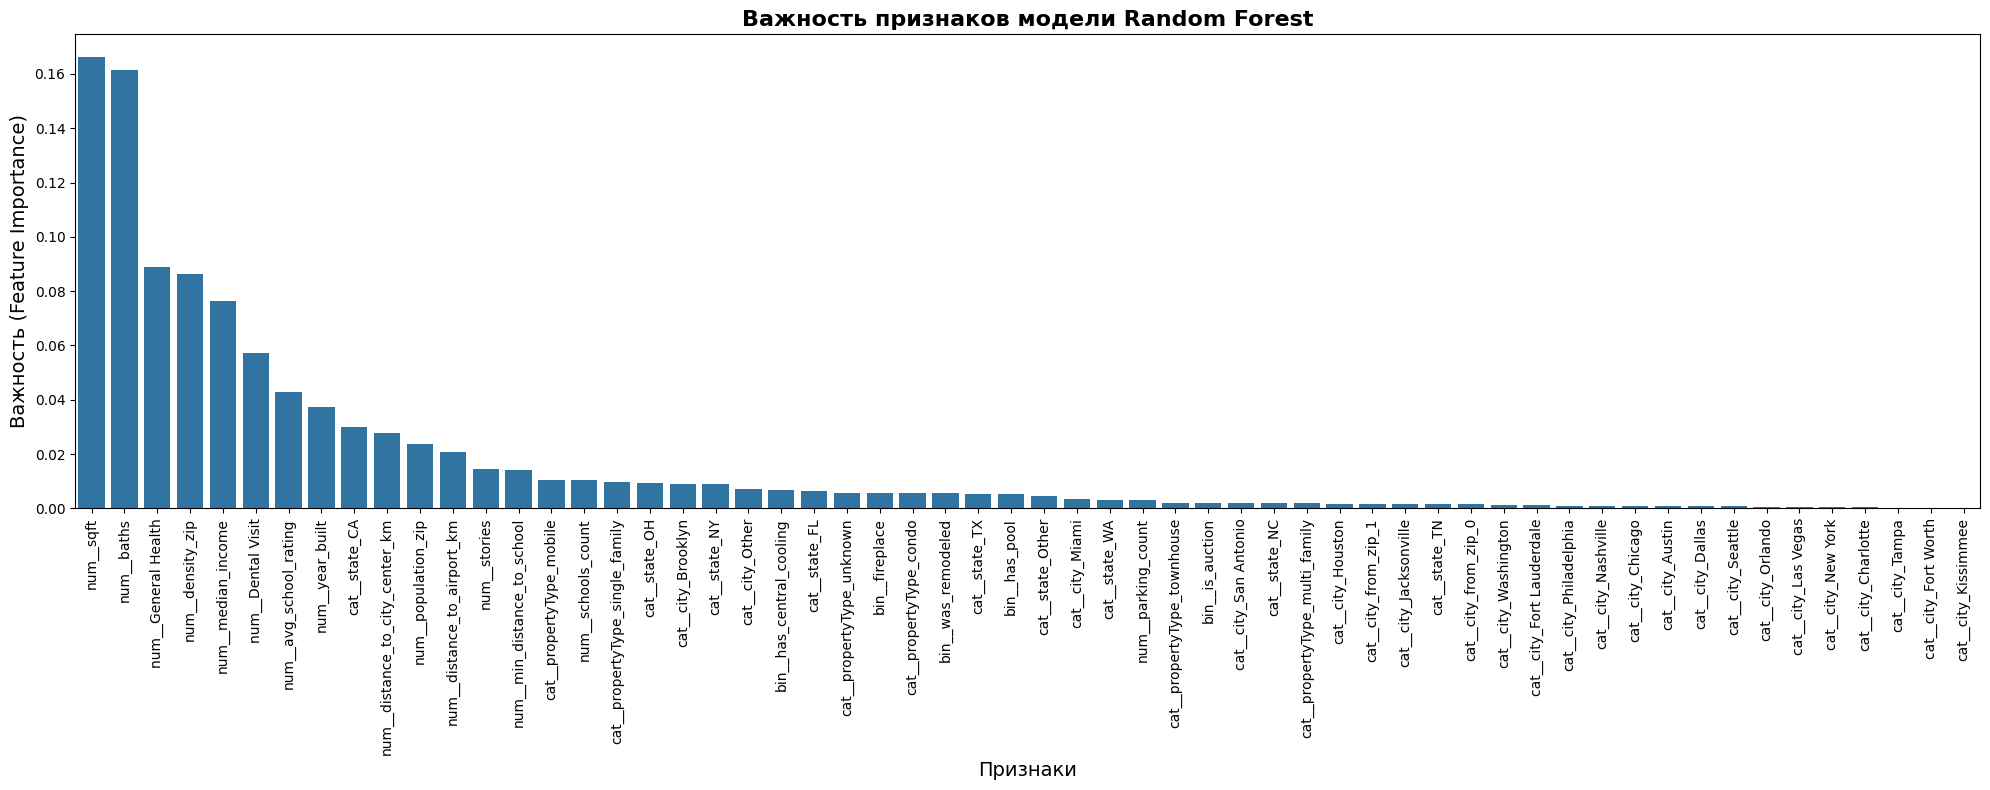

In [225]:
# Достаём пайплайн RF из стака 
rf_pipeline = stack.named_estimators_['rf']   

# Достаем саму модель и навзания признаков
rf_model = rf_pipeline.named_steps['model']
feat_names = rf_pipeline.named_steps['preprocess'].get_feature_names_out()

# Сериес признак и его важность 
rf_importances = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)

# Настройка графика
plt.figure(figsize=(20, 8))
sns.barplot(rf_importances)
plt.xticks(rotation=90)
plt.title("Важность признаков модели Random Forest", fontsize=16, weight='bold')
plt.xlabel("Признаки", fontsize=14)
plt.ylabel("Важность (Feature Importance)", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Анализ важности признаков модели Random Forest

>Анализ важности признаков показал, что наибольшее влияние на предсказание стоимости жилья оказывают физические характеристики объекта и социально-экономические показатели района.
Главные факторы — площадь жилья (num__sqft) и количество ванных комнат (num__baths), что логично отражает базовую зависимость между размером недвижимости и её ценой.

>Среди социально-демографических признаков высокую значимость имеют уровень здоровья населения (num__General Health), плотность населения (num__density_zip) и медианный доход (num__median_income), что указывает на влияние общего уровня жизни и инфраструктуры района.

>Также заметно влияние образовательных и пространственных факторов — рейтинг школ, расстояние до центра города, год постройки дома и штат (например, Калифорния).
Это говорит о том, что модель Random Forest учитывает как индивидуальные характеристики объекта, так и контекстные региональные особенности, что повышает её интерпретируемость и практическую применимость.

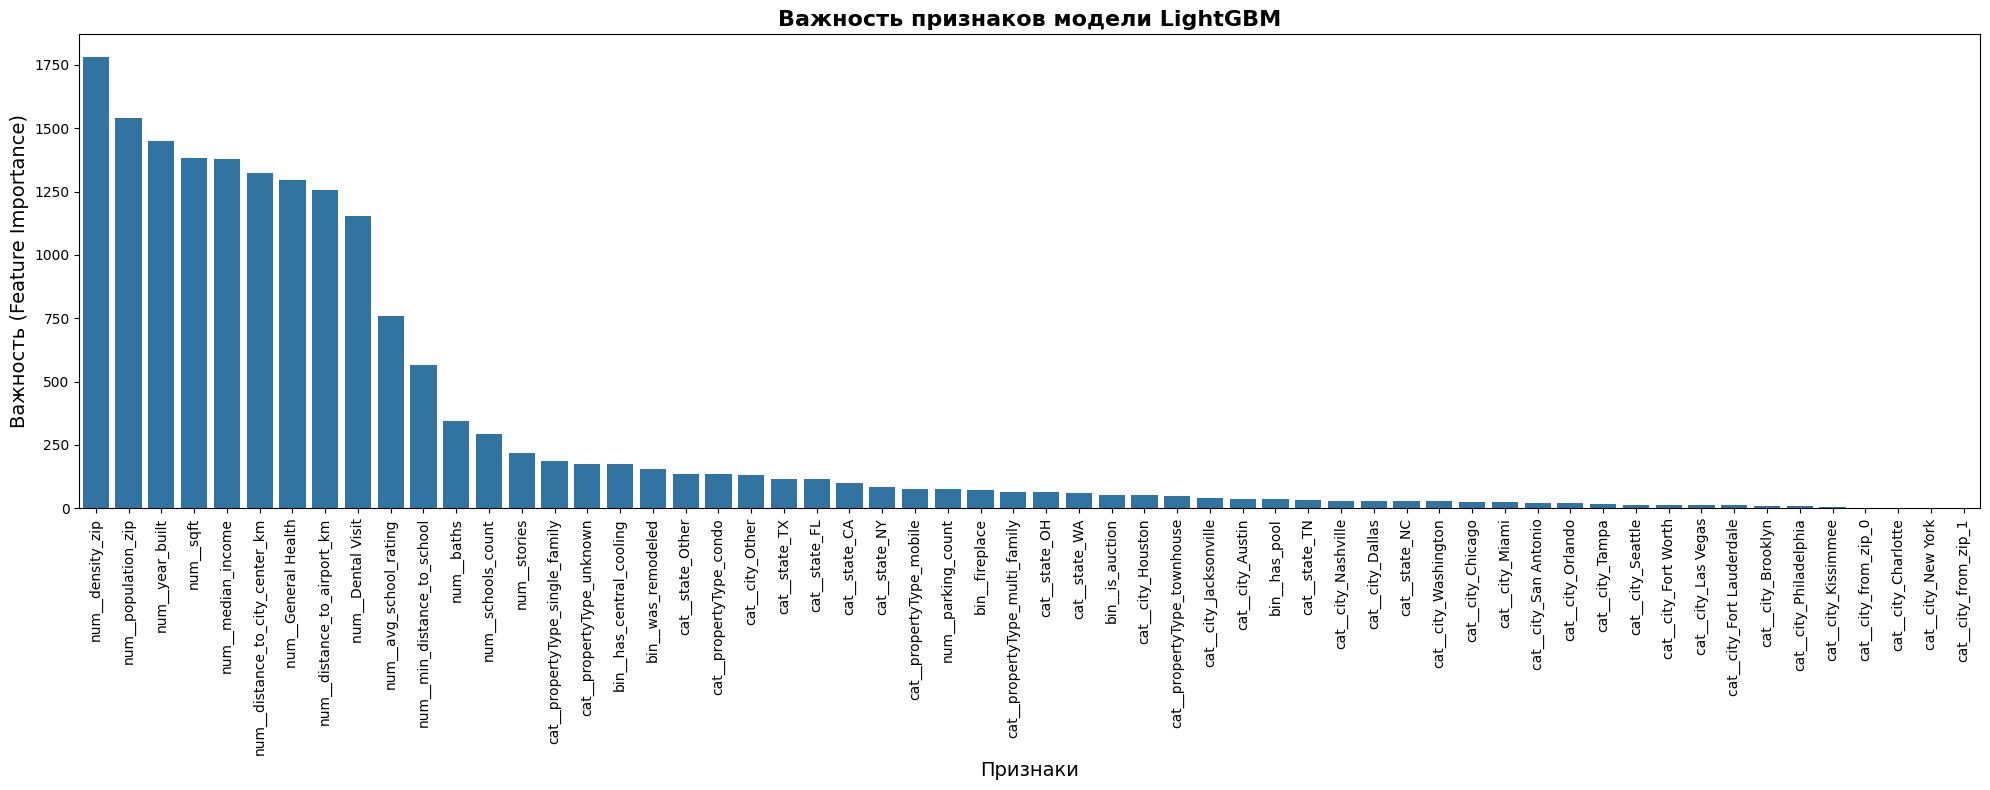

In [226]:
# Достаём пайплайн RF из стака 
lgbm_pipeline = stack.named_estimators_['lgbm']   

# Достаем саму модель и навзания признаков
lgbm_model = lgbm_pipeline.named_steps['model']
feat_names = lgbm_pipeline.named_steps['preprocess'].get_feature_names_out()

# Сериес признак и его важность 
lgbm_importances = pd.Series(lgbm_model.feature_importances_, index=feat_names).sort_values(ascending=False)

# Настройка графика
plt.figure(figsize=(20, 8))
sns.barplot(lgbm_importances)
plt.xticks(rotation=90)
plt.title("Важность признаков модели LightGBM", fontsize=16, weight='bold')
plt.xlabel("Признаки", fontsize=14)
plt.ylabel("Важность (Feature Importance)", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Анализ важности признаков модели LightGBM

>Анализ важности признаков для модели **LightGBM** показывает, что ключевое влияние на предсказание стоимости жилья оказывают:  
- **`num__density_zip`** — плотность населения, отражающая степень урбанизации района;  
- **`num__population_zip`** — общая численность населения, связанная с уровнем спроса;  
- **`num__year_built`** — год постройки, влияющий на возраст и качество объекта;  
- **`num__sqft`** — площадь объекта недвижимости, основной физический фактор стоимости;  
- **`num__median_income`** — медианный доход, отражающий покупательную способность населения;  
- **`num__distance_to_city_center_km`** — расстояние до центра города, влияющее на транспортную доступность и ценность расположения.  

>Также значимыми остаются социальные и инфраструктурные признаки — *уровень здоровья населения*, *рейтинг школ*, *удалённость до школ* и *их количество*.  
Это подтверждает, что модель LightGBM учитывает **как физические параметры объекта, так и социально-демографический контекст**, что делает её результаты интерпретируемыми и практически полезными.

### Сводный вывод по моделям Random Forest и LightGBM

>Сравнение важности признаков в моделях **Random Forest** и **LightGBM** показывает высокую согласованность факторов, определяющих стоимость жилья.  
Обе модели выделяют:
- площадь (`sqft`),  
- количество ванных комнат (`baths`),  
- плотность и численность населения,  
- медианный доход,  
- рейтинг школ,  
- расстояние до центра города  
как наиболее значимые признаки.

>Отличие состоит в том, что **LightGBM** сильнее акцентирует внимание на демографических и инфраструктурных характеристиках,  
в то время как **Random Forest** делает больший упор на физические параметры самого объекта (площадь, количество ванных комнат, год постройки).  

>Такое различие связано с природой алгоритмов:  
- **Random Forest** оценивает значимость через частоту использования признака в деревьях,  
- **LightGBM** — через совокупное уменьшение ошибки при каждом разбиении, что делает его более чувствительным к сложным нелинейным зависимостям.

>В целом обе модели демонстрируют интерпретируемые и экономически логичные результаты, подтверждая, что итоговая стоимость жилья формируется под влиянием **объективных характеристик объекта** и **социально-экономического профиля района**.

Зафиксируем наш пайплайн в финальную модель с помощью TransformedTargetRegressor, чтобы при инференсе прогноз автоматически возвращался в исходной шкале (в долларах), без необходимости ручного обратного преобразования.

In [227]:
# Финальная модель
final_model = TransformedTargetRegressor(
    regressor=stack, 
    func=np.log1p, 
    inverse_func=np.expm1
)

# Обучаем
final_model.fit(X_train_filled, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=StackingRegressor(cv=3,
                                                       estimators=[('lgbm',
                                                                    Pipeline(steps=[('preprocess',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median'))]),
                                                                                                                      ['sqft',
                                                                                                                       'baths',
                                                                                                                       'stories',
                                                                                                                       'year_built',
                                                                                                                       'min_distance_to_school',
                                                                                                                       'schools_count',
                                                                                                                       'avg_schoo...
                                                                                                                       'city_from_zip']),
                                                                                                                     ('bin',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(fill_value=0,
                                                                                                                                                     strategy='constant'))]),
                                                                                                                      ['fireplace',
                                                                                                                       'has_pool',
                                                                                                                       'is_auction',
                                                                                                                       'has_central_cooling',
                                                                                                                       'was_remodeled'])])),
                                                                                    ('model',
                                                                                     RandomForestRegressor(max_features='sqrt',
                                                                                                           min_samples_leaf=5,
                                                                                                           min_samples_split=4,
                                                                                                           n_jobs=-1,
                                                                                                           random_state=42))]))],
                                                       final_estimator=RidgeCV(alphas=[0.1,
                                                                    

Сохраним финальную модель и список признаков в папку artifacts, чтобы использовать их при построении микросервиса и в дальнейшем продакшн-развертывании.

In [228]:
# сохраняем финальную модель
joblib.dump(final_model, '../artifacts/stacking_model.joblib')

# сохраняем порядок признаков
feature_list = X_train_filled.columns.tolist()

with open('../artifacts/feature_list.json', 'w', encoding='utf-8') as f:
    json.dump(feature_list, f)

## Итоговый вывод по проекту 

В ходе выполнения проекта была разработана и реализована информационно-аналитическая система прогнозирования стоимости жилой недвижимости на основе машинного обучения.  
На всех этапах была обеспечена методологическая целостность решения — от предварительного анализа данных до построения ансамблевых моделей, что позволило получить высокое качество прогноза и интерпретируемость результатов.

На этапе **подготовки данных** проведены очистка, нормализация и обогащение исходного набора признаков.  
Были устранены пропуски, выбросы и дубликаты, выполнено кодирование категориальных признаков, а также реализованы дополнительные вычисляемые признаки, отражающие социально-экономические, географические и инфраструктурные характеристики районов.  
В результате сформирован структурированный и сбалансированный датасет, пригодный для статистического анализа и построения моделей машинного обучения.

Этап **разведочного анализа данных (EDA)** позволил выявить закономерности между ключевыми параметрами недвижимости и её стоимостью.  
Определено, что площадь жилья, количество ванных комнат, медианный доход и плотность населения являются основными детерминантами цены.  
Статистические тесты (нормальности, корреляции и значимости различий) подтвердили устойчивость и достоверность обнаруженных связей.

Для оценки влияния признаков на целевую переменную были построены и протестированы несколько моделей:  
линейные (Linear, Ridge, Lasso), деревья решений, случайный лес (Random Forest), бустинговые алгоритмы (HistGradientBoosting, LightGBM) и финальный ансамбль **StackingRegressor**, включающий оптимизированные версии LGBM и RF с метамоделью RidgeCV.  
Для каждой модели выполнен подбор гиперпараметров и перекрёстная валидация, обеспечивающая воспроизводимость результатов.

**Наилучшее качество предсказаний** показали ансамблевые модели — Random Forest и LightGBM, а их комбинация в стекинге позволила дополнительно улучшить точность.  
Финальная метрика на тестовой выборке составила:  
- *R² = 0.72*, (коэффициент детерминации, отражающий долю объяснённой вариации целевой переменной моделью)
- *MAE ≈ 138 тыс. USD*, (средняя абсолютная ошибка, показывающая среднее отклонение предсказаний от реальной стоимости в долларах)  
- *RMSE ≈ 355 тыс. USD*, (среднеквадратическая ошибка, чувствительная к крупным выбросам и характеризующая стабильность предсказаний)
что свидетельствует о хорошем уровне обобщающей способности модели.  

Проведённый анализ важности признаков показал, что модели адекватно интерпретируют логику формирования рыночной стоимости жилья:  
основное влияние оказывают площадь, число ванных комнат, медианный доход, плотность населения, рейтинг школ и расстояние до центра города.  
Таким образом, разработанная модель не только демонстрирует высокую точность, но и сохраняет интерпретируемость, что делает её применимой для аналитических и управленческих целей.

На текущем этапе проект полностью готов для переноса в продакшен-среду.  
Все ключевые компоненты — очистка, преобразование, обучение и оценка моделей — оформлены в виде воспроизводимых пайплайнов.  
Следующим шагом станет упаковка финального стекинг-модуля в сервисное приложение 

Таким образом, поставленная цель — создание эффективной модели прогнозирования стоимости недвижимости с использованием методов машинного обучения — достигнута.  